# Needed libraries

In [1]:
import numpy as np
import os
from sklearn import preprocessing
import json

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import sys
from scipy.stats import binned_statistic_2d
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, auc
thismodule = sys.modules[__name__]

from scipy import interpolate
from scipy.interpolate import interp1d
import pickle 


In [2]:
from read_lhco import read_lhco

In [3]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.lines as mlines
from xgboost import XGBRegressor, XGBClassifier
from scipy.interpolate import bisplrep,bisplev

In [4]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import XG, KDE_fitter, max_num_bins
from AUX_MLL_BL import Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve

In [5]:
import numpy as np
from scipy.optimize import fsolve

def equation(mu, pb_ps, S, B):
    return np.sum(1 / (mu * S + B * pb_ps)) - 1

def find_mu(pb_ps, S, B, mu_guess=1.0):
    mu_solution = fsolve(equation, mu_guess, args=(pb_ps, S, B))
    return mu_solution[0]


In [6]:
BPs2plot = [0,1,2,3,4,5,6,7] # Index (n-1) represent BPn
cmap = cm.get_cmap('Blues', 18)
#cmap = ['coral']
sm_color = 'black'
wjets_color = 'coral'
wgamma_color = 'red'
ttgamma_color = 'purple'

ttjets_color = 'purple'

In [7]:

def create_cyan_to_black_cmap(color1, color2, cmap_name = 'cyan_to_black'):
    colors = [color1, color2]
    return LinearSegmentedColormap.from_list(cmap_name, colors)

In [8]:
colnames = ['BP', 'm_x01', 'm_x02', 'm_x03', 'm_x1', 'BR_x02_x01', 'BR_x03_x02', 'BR_x1_x01W', 'sigma_x1_x02', 'sigma_x1_x03', 'sigma_DD', 'om_DM']
bps_data = pd.read_csv('../data/bps_data.csv', header = None, sep = ',', names = colnames)

In [10]:
bps_data.columns

Index(['BP', 'm_x01', 'm_x02', 'm_x03', 'm_x1', 'BR_x02_x01', 'BR_x03_x02',
       'BR_x1_x01W', 'sigma_x1_x02', 'sigma_x1_x03', 'sigma_DD', 'om_DM'],
      dtype='object')

In [11]:
len(bps_data)

60

# Signal events

In [79]:
signal_NLO  = 1.25
luminosidad = 100

#%cross_section_bps    = np.asarray([185.2, 185.2, 100.5, 100.5, 48.5, 48.5, 26.8, 26.8])
#%branching_ratios_x01_w_bps = np.asarray([0.96 , 0.97 , 0.93 , 0.79 , 0.95, 0.96, 0.94, 0.92])
#%branching_ratios_x02_x01_bps = np.asarray([0.70 , 0.50 , 0.40 , 0.73 , 0.47, 0.71, 0.44, 0.72])
#%branching_ratios_x03_x02_bps = np.asarray([0.89 , 0.89 , 0.91 , 0.92 , 0.84, 0.91, 0.90, 0.92])

#%signal_cross = cross_section_bps * branching_ratios_x01_w_bps * branching_ratios_x02_x01_bps *  0.2134 # fb. 0.2134 is the branching ratios W a ligh leptons

signal_cross_section_n2 = bps_data['sigma_x1_x02'] * bps_data['BR_x02_x01'] * bps_data['BR_x1_x01W'] * 0.2134
signal_cross_section_n3 = bps_data['sigma_x1_x03'] * bps_data['BR_x03_x02'] * bps_data['BR_x02_x01'] * bps_data['BR_x1_x01W'] * 0.2134

fid_cross_sections = np.zeros(len(signal_cross_section_n2))
expected_events = np.zeros(len(signal_cross_section_n2))
sim_events = np.zeros(len(signal_cross_section_n2))
cut_events = np.zeros(len(signal_cross_section_n2))

In [80]:
!ls ../data/BP1/pptox1n2j_nmssm

BP1_1_run100k_1.lhco  BP1_3_run100k_1.lhco
BP1_2_run100k_1.lhco  BP1_4_run100k_1.lhco


In [84]:
write = True
MET_cut = 200

results = {}
for bp_number in ['1_1','1_2','1_3','1_4',
                  '2_1','2_2','2_3','2_4','2_5',
                  '3_1','3_2','3_3','3_4',
                  '4_1','4_2','4_3','4_4','4_5',
                  '5_1','5_2','5_3','5_4','5_5',
                  '6_1','6_2','6_3','6_4','6_5','6_6',
                  '7_1','7_2','7_3','7_4','7_5',
                  '8_1','8_2','8_3','8_4',
                  '9_1','9_2','9_3','9_4',
                  '10_1','10_2','10_3','10_4',
                  '11_1','11_2','11_3','11_4','11_5',
                  '12_1','12_2','12_3','12_4','12_5',
                  '13_1','13_2','13_3','13_4']:

    dir2 = f'../data/BP{bp_number[:-2]}/pptox1n2j_nmssm/'
    signal_runs2 = os.listdir(dir2)
    signal_runs2 = [file for file in signal_runs2 if file.endswith("_run100k_1.lhco")] # To keep only .lhco files
    signal_runs2 = [dir2 + file for file in signal_runs2 if file.startswith("BP"+bp_number)]

    dir3 = f'../data/BP{bp_number[:-2]}/pptox1n3j_nmssm/'
    signal_runs3 = os.listdir(dir3)
    signal_runs3 = [file for file in signal_runs3 if file.endswith("_run100k_1.lhco")] # To keep only .lhco files
    signal_runs3 = [dir3 + file for file in signal_runs3 if file.startswith("BP"+bp_number)]

    signal_runs = signal_runs2 + signal_runs3
    
    aux_dict = {}

    for ii, file in enumerate(signal_runs):
        print(ii)
        inputevents = read_lhco(file, OutputType = 'dict')
        signal_init_ev = len(inputevents)
        
        signal_cut_ev  = 0

        counter_bad_jets = 0
        contador_tau     = 0
        
        for i in range(len(inputevents)):
    
            # at least one: photon, jet and lepton (electron or muon)
            if len(inputevents[i]["photon"]) > 0 and len(inputevents[i]["jet"]) > 0 and (len(inputevents[i]["electron"]) > 0 or len(inputevents[i]["muon"]) > 0):
                if inputevents[i]["jet"][0]["pt"] > 100 and -4.5 < inputevents[i]["jet"][0]["eta"] < 4.5:
                    if inputevents[i]["photon"][0]["pt"] > 10 and -2.37 < inputevents[i]["photon"][0]["eta"] < 2.37:
                        if inputevents[i]["met"][0]["pt"] > MET_cut:
    
                            # lepton info
                            if (len(inputevents[i]["electron"]) > 0) and (len(inputevents[i]["muon"]) > 0):
                                if inputevents[i]["electron"][0]["pt"] > inputevents[i]["muon"][0]["pt"]: 
                                    flag = 'electron'
                                    eta_leading_lepton = inputevents[i]["electron"][0]["eta"]
                                else: 
                                    flag = 'muon'
                                    eta_leading_lepton = -2. # Esto es para q el corte sea solo cuando el leading lepton es un electron
                            elif (len(inputevents[i]["electron"]) > 0) and (len(inputevents[i]["muon"]) == 0): 
                                flag = 'electron'
                                eta_leading_lepton = inputevents[i]["electron"][0]["eta"]
                            elif (len(inputevents[i]["muon"]) > 0) and (len(inputevents[i]["electron"]) == 0): 
                                flag = 'muon'
                                eta_leading_lepton = -2. # Esto es para q el corte sea solo cuando el leading lepton es un electron
    
                            if (-2.47 < eta_leading_lepton < -1.52) or (-1.37 < eta_leading_lepton < 1.37) or (1.52 < eta_leading_lepton < 2.47): 
    
                                # how many jets (total) and total hadronic pT
                                flag_bad_jets = 0                            
                                num_jets = 0
                                HT_had = 0 # hadronic activity HT, defined as the scalar sum of the pT of all reconstructed jets
                                HT = 0 # total HT, defined as the scalar sum of the pT of all reconstructed particles
    
                                for j in range(len(inputevents[i]["jet"])):
                                    if (inputevents[i]["jet"][j]["pt"] > 20) and (-4.5 < inputevents[i]["jet"][j]["eta"] < 4.5):
                                        num_jets += 1
                                        HT_had += inputevents[i]["jet"][j]["pt"]
                                        HT += inputevents[i]["jet"][j]["pt"]
                                    if (np.abs(inputevents[i]["jet"][j]["eta"]) > 4.5) or (inputevents[i]["jet"][j]["pt"] < 20):
                                        flag_bad_jets = 1
    
                                # how many photons                         
                                num_photons = 0
                                for j in range(len(inputevents[i]["photon"])):
                                    if inputevents[i]["photon"][j]["pt"] > 10 and -2.37 < inputevents[i]["photon"][j]["eta"] < 2.37:
                                        num_photons = num_photons + 1
                                        HT += inputevents[i]["photon"][j]["pt"]
    
                                # how many muons                        
                                num_muons = 0
                                for j in range(len(inputevents[i]["muon"])):
                                    if inputevents[i]["muon"][j]["pt"] > 10 and -2.7 < inputevents[i]["muon"][j]["eta"] < 2.7:
                                        num_muons = num_muons + 1
                                        HT += inputevents[i]["muon"][j]["pt"]
    
                                # how many electrons                        
                                num_electrons = 0
                                for j in range(len(inputevents[i]["electron"])):
                                    if inputevents[i]["electron"][j]["pt"] > 10:
                                        eta = inputevents[i]["electron"][j]["eta"]
                                        if (-2.47 < eta < -1.52) or (-1.37 < eta < 1.37) or (1.52 < eta < 2.47): 
                                            num_electrons = num_electrons + 1
                                            HT += inputevents[i]["electron"][j]["pt"]
    
                                if flag_bad_jets == 1: counter_bad_jets += 1 
                                if flag_bad_jets == 0:
                                    num_taus = 0
                                    if len(inputevents[i]["tau"]) > 0: 
                                        contador_tau = contador_tau + 1
                                        # how many taus                    
                                        for j in range(len(inputevents[i]["tau"])):
                                            if inputevents[i]["tau"][j]["pt"] > 20:
                                                eta = inputevents[i]["tau"][j]["eta"]
                                                if (-2.47 < eta < -1.52) or (-1.37 < eta < 1.37) or (1.52 < eta < 2.47): 
                                                    num_taus = num_taus + 1
                                                    HT += inputevents[i]["tau"][j]["pt"]
    
                                    if write:                
                                        # photon info:
                                        with open(f'../data/events_after_cuts/BP{bp_number}_' + file[len(f'../data/BP{bp_number[:-2]}/'):len(f'../data/BP{bp_number[:-2]}/')+8] + f'_photon_{MET_cut}.dat', 'a') as f:
                                            f.write('%f %f %f %d\n' % (inputevents[i]["photon"][0]["pt"],inputevents[i]["photon"][0]["eta"],inputevents[i]["photon"][0]["phi"], num_photons))
    
                                        # jet info:
                                        with open(f'../data/events_after_cuts/BP{bp_number}_' + file[len(f'../data/BP{bp_number[:-2]}/'):len(f'../data/BP{bp_number[:-2]}/')+8] + f'_jet_{MET_cut}.dat', 'a') as f:
                                            f.write('%f %f %f\n' % (inputevents[i]["jet"][0]["pt"],inputevents[i]["jet"][0]["eta"],inputevents[i]["jet"][0]["phi"]))
    
                                        # lepton info
                                        num_leptons = num_electrons + num_muons
                                        if flag == 'electron':
                                            with open(f'../data/events_after_cuts/BP{bp_number}_' + file[len(f'../data/BP{bp_number[:-2]}/'):len(f'../data/BP{bp_number[:-2]}/')+8] + f'_lepton_{MET_cut}.dat', 'a') as f:
                                                f.write('%f %f %f %d %d\n' % (inputevents[i]["electron"][0]["pt"],inputevents[i]["electron"][0]["eta"],inputevents[i]["electron"][0]["phi"], num_leptons, num_taus))
                                        else:
                                            with open(f'../data/events_after_cuts/BP{bp_number}_' + file[len(f'../data/BP{bp_number[:-2]}/'):len(f'../data/BP{bp_number[:-2]}/')+8] + f'_lepton_{MET_cut}.dat', 'a') as f:
                                                f.write('%f %f %f %d %d\n' % (inputevents[i]["muon"][0]["pt"],inputevents[i]["muon"][0]["eta"],inputevents[i]["muon"][0]["phi"], num_leptons, num_taus))
    
                                        # MET (eta=0 by def, but I save phi because I have many jets)
                                        with open(f'../data/events_after_cuts/BP{bp_number}_' + file[len(f'../data/BP{bp_number[:-2]}/'):len(f'../data/BP{bp_number[:-2]}/')+8] + f'_MET_{MET_cut}.dat', 'a') as f:
                                            f.write('%f %f %f\n' % (inputevents[i]["met"][0]["pt"],inputevents[i]["met"][0]["eta"],inputevents[i]["met"][0]["phi"]))
    
                                        # hadronic info
                                        with open(f'../data/events_after_cuts/BP{bp_number}_' + file[len(f'../data/BP{bp_number[:-2]}/'):len(f'../data/BP{bp_number[:-2]}/')+8] + f'_hadinfo_{MET_cut}.dat', 'a') as f:
                                            f.write('%f %f %d\n' % (HT, HT_had, num_jets))
    
                                    # total events that passed the cuts
                                    signal_cut_ev += 1
    
        if len(aux_dict) == 0:
            aux_dict = {file[len(f'../data/BP{bp_number[:-2]}/'):len(f'../data/BP{bp_number[:-2]}/')+8]:
                        {'#Init_events':signal_init_ev, '#After_cuts':signal_cut_ev, '#Taus':contador_tau, 
                         '#Bad_jets':counter_bad_jets, 'aceptance':(signal_cut_ev / signal_init_ev)}
                       }
        else:
            aux_dict.update({file[len(f'../data/BP{bp_number[:-2]}/'):len(f'../data/BP{bp_number[:-2]}/')+8]:
                    {'#Init_events':signal_init_ev, '#After_cuts':signal_cut_ev, '#Taus':contador_tau, 
                     '#Bad_jets':counter_bad_jets, 'aceptance':(signal_cut_ev / signal_init_ev)}
                   })

        print('Finish analyzing ' + file + '...')
        print('Esta run tuvo ' + str(len(inputevents)) + ' eventos en el lhco')
        print('Num initial events: ', signal_init_ev)
        print('Total pasaron los cortes: ', signal_cut_ev)
        print('Hay: ', contador_tau, ' taus')
        print('Hay: ', counter_bad_jets, ' eventos con al menos un jet malo')


    results.update({bp_number:aux_dict})
    #cross       = signal_cross[bp_number-1] * signal_NLO
    #%aceptancia  = signal_cut_ev / signal_init_ev
    
    #%signal_fidcross = cross * aceptancia
    #%signal_expected = cross * aceptancia * luminosidad
    
    #%fid_cross_sections[bp_number - 1] = signal_fidcross
    #%expected_events[bp_number - 1] = signal_expected
    #%sim_events[bp_number - 1] = signal_init_ev
    #%cut_events[bp_number - 1] = signal_cut_ev
    #%print('fiducial cross section: ', signal_fidcross)
    #%print('Events expected: ', signal_expected)

0
Finish analyzing ../data/BP1/pptox1n2j_nmssm/BP1_1_run100k_1.lhco...
Esta run tuvo 100000 eventos en el lhco
Num initial events:  100000
Total pasaron los cortes:  3008
Hay:  53  taus
Hay:  28  eventos con al menos un jet malo
1
Finish analyzing ../data/BP1/pptox1n3j_nmssm/BP1_1_run100k_1.lhco...
Esta run tuvo 100000 eventos en el lhco
Num initial events:  100000
Total pasaron los cortes:  3383
Hay:  59  taus
Hay:  35  eventos con al menos un jet malo
0
Finish analyzing ../data/BP1/pptox1n2j_nmssm/BP1_2_run100k_1.lhco...
Esta run tuvo 100000 eventos en el lhco
Num initial events:  100000
Total pasaron los cortes:  4613
Hay:  82  taus
Hay:  52  eventos con al menos un jet malo
1
Finish analyzing ../data/BP1/pptox1n3j_nmssm/BP1_2_run100k_1.lhco...
Esta run tuvo 100000 eventos en el lhco
Num initial events:  100000
Total pasaron los cortes:  4844
Hay:  75  taus
Hay:  53  eventos con al menos un jet malo
0
Finish analyzing ../data/BP1/pptox1n2j_nmssm/BP1_3_run100k_1.lhco...
Esta run tuvo

In [85]:
for i in list(results.keys()):

    aux = bps_data[bps_data['BP'] == i]

    signal_cross_section_n2 = aux['sigma_x1_x02'] * aux['BR_x02_x01'] * aux['BR_x1_x01W'] * 0.2134 * signal_NLO
    signal_expected = np.asarray(signal_cross_section_n2)[0] * results[i]['pptox1n2']['aceptance'] * luminosidad
    results[i]['pptox1n2'].update({'#Signal_expected':signal_expected})

    signal_cross_section_n3 = aux['sigma_x1_x03'] * aux['BR_x03_x02'] * aux['BR_x02_x01'] * aux['BR_x1_x01W'] * 0.2134 * signal_NLO
    signal_expected = np.asarray(signal_cross_section_n3)[0] * results[i]['pptox1n3']['aceptance'] * luminosidad
    results[i]['pptox1n3'].update({'#Signal_expected':signal_expected})

In [86]:
with open(f'../data/events_after_cuts/lhco_analysis_MET{MET_cut}.pkl', 'wb') as f:
    pickle.dump(results, f)
        
#with open(f'../data/events_after_cuts/lhco_analysis_MET{MET_cut}.pkl', 'rb') as f:
#    results = pickle.load(f)
    
results

{'1_1': {'pptox1n2': {'#Init_events': 100000,
   '#After_cuts': 3008,
   '#Taus': 53,
   '#Bad_jets': 28,
   'aceptance': 0.03008,
   '#Signal_expected': 23.14030522496},
  'pptox1n3': {'#Init_events': 100000,
   '#After_cuts': 3383,
   '#Taus': 59,
   '#Bad_jets': 35,
   'aceptance': 0.03383,
   '#Signal_expected': 19.3861370519894}},
 '1_2': {'pptox1n2': {'#Init_events': 100000,
   '#After_cuts': 4613,
   '#Taus': 82,
   '#Bad_jets': 52,
   'aceptance': 0.04613,
   '#Signal_expected': 59.56820759081498},
  'pptox1n3': {'#Init_events': 100000,
   '#After_cuts': 4844,
   '#Taus': 75,
   '#Bad_jets': 53,
   'aceptance': 0.04844,
   '#Signal_expected': 51.31276334077739}},
 '1_3': {'pptox1n2': {'#Init_events': 100000,
   '#After_cuts': 6290,
   '#Taus': 97,
   '#Bad_jets': 65,
   'aceptance': 0.0629,
   '#Signal_expected': 123.58105053359998},
  'pptox1n3': {'#Init_events': 100000,
   '#After_cuts': 6004,
   '#Taus': 103,
   '#Bad_jets': 74,
   'aceptance': 0.06004,
   '#Signal_expected'

# Analysis (MET > 100)

## Reading SM data

In [12]:
ttgamma_cross = 0.13 * 1000 #[fb]
ttgamma_NLO   = 1.46 # k-factor [14 TeV]

wgamma_cross = 0.944 * 1000 #[fb]
wgamma_NLO   = 2.37 # k-factor [14 TeV]

wjets_cross = 168.12 * 1000 #[fb]
wjets_NLO   = 1.27 # k-factor [14 TeV]

ttjets_cross = 29.0495 * 1000 # [fb]
ttjets_NLO   = 1.47

zjets_cross = 65.85 * 1000 # [fb] solo rama leptonica
zjets_NLO   = 1.35

wz_cross = 0.90 * 1000 # [fb]
wz_NLO   = 1.62

zz_cross = 0.2616 * 1000
zz_NLO   = 1.29

ww_cross = 0.409 * 1000
ww_NLO   = 1.40

tj_cross = 1.598 * 1000
tj_NLO   = 1.03

tb_cross = 2.882 * 1000
tb_NLO   = 1.34

tw_cross = 1.441 * 1000
tw_NLO   = 1.

In [13]:
wgamma_fidcross  = 584.6234
wjets_fidcross   = 600.5788
ttgamma_fidcross = 24.98413

ttjets_fidcross  = 180.510721
zjets_fidcross   = 33.609922
wz_fidcross      = 6.740334
zz_fidcross      = 0.843997
ww_fidcross      = 15.8203
tj_fidcross      = 7.9070
tb_fidcross      = 11.52578
tw_fidcross      = 12.72042

bkg = ['wgamma', 'wjets', 'ttgamma',
       'zjets',
       'ttjets',
       'tj', 'tb', 'tw',
       'ww', 'zz', 'wz'
      ]

B_fidcross_tot = 0
for i, ibkg in enumerate(bkg):
    B_fidcross_tot = B_fidcross_tot + globals()[ibkg + '_fidcross']
B_fidcross_tot

1479.8648040000003

In [14]:
wgamma_aceptancia_init  = wgamma_fidcross / (wgamma_cross * wgamma_NLO)
wjets_aceptancia_init   = wjets_fidcross / (wjets_cross * wjets_NLO)
ttgamma_aceptancia_init = ttgamma_fidcross / (ttgamma_cross * ttgamma_NLO)
ttjets_aceptancia_init  = ttjets_fidcross / (ttjets_cross * ttjets_NLO)
zjets_aceptancia_init   = zjets_fidcross / (zjets_cross * zjets_NLO)
wz_aceptancia_init      = wz_fidcross / (wz_cross * wz_NLO)
zz_aceptancia_init      = zz_fidcross / (zz_cross * zz_NLO)
ww_aceptancia_init      = ww_fidcross / (ww_cross * ww_NLO)
tj_aceptancia_init      = tj_fidcross / (tj_cross * tj_NLO)
tb_aceptancia_init      = tb_fidcross / (tb_cross * tb_NLO)
tw_aceptancia_init      = tw_fidcross / (tw_cross * tw_NLO)

In [15]:
wgamma_expected  = 58462.34
wjets_expected   = 60057.88
ttgamma_expected = 2498.413

ttjets_expected  = 18051.0721
zjets_expected   = 3360.9922
wz_expected      = 674.0334
zz_expected      = 84.3997
ww_expected      = 1582.03
tj_expected      = 790.70
tb_expected      = 1152.578
tw_expected      = 1272.042

B_expected = 0
for i, ibkg in enumerate(bkg):
    B_expected = B_expected + globals()[ibkg + '_expected']
B_expected

147986.4804

In [16]:
sample = 200_000 # Number of signal and background events to train and validate

wgamma_sample  = int(round(sample * wgamma_fidcross / B_fidcross_tot))
wjets_sample   = int(round(sample * wjets_fidcross / B_fidcross_tot))
ttgamma_sample = int(round(sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_sample = int(round(sample * ttjets_fidcross / B_fidcross_tot))
zjets_sample = int(round(sample * zjets_fidcross / B_fidcross_tot))
wz_sample = int(round(sample * wz_fidcross / B_fidcross_tot))
zz_sample = int(round(sample * zz_fidcross / B_fidcross_tot))
ww_sample = int(round(sample * ww_fidcross / B_fidcross_tot))
tj_sample = int(round(sample * tj_fidcross / B_fidcross_tot))
tb_sample = int(round(sample * tb_fidcross / B_fidcross_tot))
tw_sample = int(round(sample * tw_fidcross / B_fidcross_tot))

print(wgamma_sample)
print(wjets_sample)
print(ttgamma_sample)
print(ttjets_sample)
print(zjets_sample)
print(wz_sample)
print(zz_sample)
print(ww_sample)
print(tj_sample)
print(tb_sample)
print(tw_sample)

79010
81167
3377
24396
4542
911
114
2138
1069
1558
1719


In [17]:
datFolderwgamma  = '../../susyatLHC/data/Wgamma/'
datFolderwjets   = '../../susyatLHC/data/Wjets/'
datFolderttgamma = '../../susyatLHC/data/ttGamma/'
datFolderttjets  = '../../susyatLHC/data/ttjets/'
datFolderzjets   = '../../susyatLHC/data/Zlep+j/'
datFolderwz      = '../../susyatLHC/data/wz/'
datFolderww      = '../../susyatLHC/data/ww/'
datFolderzz      = '../../susyatLHC/data/zz/'
datFoldertj      = '../../susyatLHC/data/singleTop+j/'
datFoldertb      = '../../susyatLHC/data/singleTop+b/'
datFoldertw      = '../../susyatLHC/data/singleTop+W/'

for i, ibkg in enumerate(bkg):
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'photon_4.dat', delimiter=' ')
    setattr(thismodule, 'photon_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'jet_4.dat', delimiter=' ')
    setattr(thismodule, 'jet_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'lepton_4.dat', delimiter=' ')
    setattr(thismodule, 'lepton_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'MET_4.dat', delimiter=' ')
    setattr(thismodule, 'MET_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'hadinfo_4.dat', delimiter=' ')
    setattr(thismodule, 'hadinfo_' + ibkg, aux)

In [18]:
for i, ibkg in enumerate(bkg):
    if i == 0:
        photon_SM  = globals()['photon_' + ibkg][:globals()[ibkg + '_sample']]
        jet_SM     = globals()['jet_' + ibkg][:globals()[ibkg + '_sample']]
        lepton_SM  = globals()['lepton_' + ibkg][:globals()[ibkg + '_sample']]
        MET_SM     = globals()['MET_' + ibkg][:globals()[ibkg + '_sample']]
        hadinfo_SM = globals()['hadinfo_' + ibkg][:globals()[ibkg + '_sample']]
    else:
        photon_SM  = np.concatenate([photon_SM, globals()['photon_' + ibkg][:globals()[ibkg + '_sample']]])
        jet_SM     = np.concatenate([jet_SM, globals()['jet_' + ibkg][:globals()[ibkg + '_sample']]])
        lepton_SM  = np.concatenate([lepton_SM, globals()['lepton_' + ibkg][:globals()[ibkg + '_sample']]])
        MET_SM     = np.concatenate([MET_SM, globals()['MET_' + ibkg][:globals()[ibkg + '_sample']]])
        hadinfo_SM = np.concatenate([hadinfo_SM, globals()['hadinfo_' + ibkg][:globals()[ibkg + '_sample']]])

In [19]:
bkg_flag = np.zeros(len(photon_SM))

for i, ibkg in enumerate(bkg):
    if i == 0:
        bkg_flag[:globals()[ibkg + '_sample']] = i + 1
        end_ind = globals()[ibkg + '_sample']
    else:
        init_ind = end_ind
        end_ind  = end_ind + globals()[ibkg + '_sample']
        bkg_flag[(init_ind):(end_ind)] = i + 1

In [20]:
wjets_pool  = len(photon_wjets[wjets_sample:])
pool_sample = int(wjets_pool * B_fidcross_tot / wjets_fidcross)

wgamma_pool_sample  = int(round(pool_sample * wgamma_fidcross / B_fidcross_tot))
wjets_pool_sample   = int(round(pool_sample * wjets_fidcross / B_fidcross_tot))
ttgamma_pool_sample = int(round(pool_sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_pool_sample  = int(round(pool_sample * ttjets_fidcross / B_fidcross_tot))
zjets_pool_sample   = int(round(pool_sample * zjets_fidcross / B_fidcross_tot))
wz_pool_sample      = int(round(pool_sample * wz_fidcross / B_fidcross_tot))
zz_pool_sample      = int(round(pool_sample * zz_fidcross / B_fidcross_tot))
ww_pool_sample      = int(round(pool_sample * ww_fidcross / B_fidcross_tot))
tj_pool_sample      = int(round(pool_sample * tj_fidcross / B_fidcross_tot))
tb_pool_sample      = int(round(pool_sample * tb_fidcross / B_fidcross_tot))
tw_pool_sample      = int(round(pool_sample * tw_fidcross / B_fidcross_tot))

print(wgamma_pool_sample)
print(wjets_pool_sample)
print(ttgamma_pool_sample)
print(ttjets_pool_sample)
print(zjets_pool_sample)
print(wz_pool_sample)
print(zz_pool_sample)
print(ww_pool_sample)
print(tj_pool_sample)
print(tb_pool_sample)
print(tw_sample)

173444
178178
7412
53553
9971
2000
250
4694
2346
3419
1719


In [21]:
for i, ibkg in enumerate(bkg):
    if i == 0:
        photon_SM_pool  = globals()['photon_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        jet_SM_pool     = globals()['jet_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        lepton_SM_pool  = globals()['lepton_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        MET_SM_pool     = globals()['MET_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        hadinfo_SM_pool = globals()['hadinfo_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
    else:
        photon_SM_pool  = np.concatenate([photon_SM_pool, globals()['photon_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        jet_SM_pool     = np.concatenate([jet_SM_pool, globals()['jet_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        lepton_SM_pool  = np.concatenate([lepton_SM_pool, globals()['lepton_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        MET_SM_pool     = np.concatenate([MET_SM_pool, globals()['MET_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        hadinfo_SM_pool = np.concatenate([hadinfo_SM_pool, globals()['hadinfo_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])

In [22]:
bkg_flag_pool = np.zeros(len(photon_SM_pool))

for i, ibkg in enumerate(bkg):
    if i == 0:
        bkg_flag_pool[:globals()[ibkg + '_pool_sample']] = i + 1
        end_ind = globals()[ibkg + '_pool_sample']
    else:
        init_ind = end_ind
        end_ind  = end_ind + globals()[ibkg + '_pool_sample']
        bkg_flag_pool[(init_ind):(end_ind)] = i + 1

In [23]:
print(photon_wjets.shape)
print(photon_ttgamma.shape)
print(photon_wgamma.shape)
print(photon_ttjets.shape)
print(photon_zjets.shape)
print(photon_wz.shape)
print(photon_zz.shape)
print(photon_ww.shape)
print(photon_tj.shape)
print(photon_tb.shape)
print(photon_tw.shape)

(259345, 4)
(2710879, 4)
(3579946, 4)
(92997, 4)
(15123, 4)
(9246, 4)
(2501, 4)
(27629, 4)
(4804, 4)
(5969, 4)
(17655, 4)


### Other variables

In [24]:
for i, ibkg in enumerate(bkg):
    aux = globals()['photon_' + ibkg][:,0] + globals()['lepton_' + ibkg][:,0] + globals()['jet_' + ibkg][:,0]
    setattr(thismodule, 'ST_' + ibkg, aux)
    
    aux = np.divide( globals()['MET_' + ibkg][:,0], np.sqrt(globals()['hadinfo_' + ibkg][:,0]) )
    setattr(thismodule, 'MET_sig_' + ibkg, aux)
    
    aux = globals()['MET_' + ibkg][:,0] + globals()['photon_' + ibkg][:,0] + globals()['lepton_' + ibkg][:,0] + globals()['jet_' + ibkg][:,0]
    setattr(thismodule, 'm_eff_' + ibkg, aux)
    
    aux = np.absolute( globals()['MET_' + ibkg][:,2] - globals()['photon_' + ibkg][:,2] )
    setattr(thismodule, 'phi_MET_photon_' + ibkg, aux)
    
    aux = np.absolute( globals()['MET_' + ibkg][:,2] - globals()['jet_' + ibkg][:,2] )
    setattr(thismodule, 'phi_MET_jet_' + ibkg, aux)
    
    aux = np.absolute( globals()['MET_' + ibkg][:,2] - globals()['lepton_' + ibkg][:,2] )
    setattr(thismodule, 'phi_MET_lepton_' + ibkg, aux)
    
    aux = np.sqrt( (2*globals()['photon_' + ibkg][:,0] * globals()['MET_' + ibkg][:,0]) * (1 - np.cos(globals()['phi_MET_photon_' + ibkg])) )
    setattr(thismodule, 'mT_photon_' + ibkg, aux)
    
    aux = np.sqrt( (2*globals()['jet_' + ibkg][:,0] * globals()['MET_' + ibkg][:,0]) * (1 - np.cos(globals()['phi_MET_jet_' + ibkg])) )
    setattr(thismodule, 'mT_jet_' + ibkg, aux)
    
    aux = np.sqrt( (2*globals()['lepton_' + ibkg][:,0] * globals()['MET_' + ibkg][:,0]) * (1 - np.cos(globals()['phi_MET_lepton_' + ibkg])) )
    setattr(thismodule, 'mT_lepton_' + ibkg, aux)
    
    aux = np.absolute( globals()['photon_' + ibkg][:,2] - globals()['jet_' + ibkg][:,2] )
    setattr(thismodule, 'phi_photon_jet_' + ibkg, aux)    
    globals()['phi_photon_jet_' + ibkg][globals()['phi_photon_jet_' + ibkg] > np.pi] = (2.* np.pi) - globals()['phi_photon_jet_' + ibkg][globals()['phi_photon_jet_' + ibkg] > np.pi]
    
    aux = np.absolute( globals()['photon_' + ibkg][:,2] - globals()['lepton_' + ibkg][:,2] )
    setattr(thismodule, 'phi_photon_lepton_' + ibkg, aux)    
    globals()['phi_photon_lepton_' + ibkg][globals()['phi_photon_lepton_' + ibkg] > np.pi] = (2.* np.pi) - globals()['phi_photon_lepton_' + ibkg][globals()['phi_photon_lepton_' + ibkg] > np.pi]
        
    aux = np.absolute( globals()['lepton_' + ibkg][:,2] - globals()['jet_' + ibkg][:,2] )
    setattr(thismodule, 'phi_lepton_jet_' + ibkg, aux)    
    globals()['phi_lepton_jet_' + ibkg][globals()['phi_lepton_jet_' + ibkg] > np.pi] = (2.* np.pi) - globals()['phi_lepton_jet_' + ibkg][globals()['phi_lepton_jet_' + ibkg] > np.pi]
    
    aux = np.sqrt( (globals()['photon_' + ibkg][:,1] - globals()['jet_' + ibkg][:,1])**2 + (globals()['phi_photon_jet_' + ibkg])**2 )
    setattr(thismodule, 'deltaR0_photon_jet_' + ibkg, aux)  
    
    aux = np.sqrt( (globals()['photon_' + ibkg][:,1] - globals()['lepton_' + ibkg][:,1])**2 + (globals()['phi_photon_lepton_' + ibkg])**2 )
    setattr(thismodule, 'deltaR0_photon_lepton_' + ibkg, aux)
    
    aux = np.sqrt( (globals()['lepton_' + ibkg][:,1] - globals()['jet_' + ibkg][:,1])**2 + (globals()['phi_lepton_jet_' + ibkg])**2 )
    setattr(thismodule, 'deltaR0_lepton_jet_' + ibkg, aux)

In [25]:
# other variables

ST_SM = photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

MET_sig_SM = np.divide( MET_SM[:,0],np.sqrt(hadinfo_SM[:,0]) )

m_eff_SM = MET_SM[:,0] + photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

phi_MET_photon_SM = np.absolute( MET_SM[:,2] - photon_SM[:,2] )
phi_MET_jet_SM    = np.absolute( MET_SM[:,2] - jet_SM[:,2] )
phi_MET_lepton_SM = np.absolute( MET_SM[:,2] - lepton_SM[:,2] )

mT_photon_SM = np.sqrt( (2*photon_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_photon_SM)) )
mT_jet_SM    = np.sqrt( (2*jet_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_jet_SM)) )
mT_lepton_SM = np.sqrt( (2*lepton_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_lepton_SM)) )

phi_photon_jet_SM    = np.absolute( photon_SM[:,2] - jet_SM[:,2] )
phi_photon_lepton_SM = np.absolute( photon_SM[:,2] - lepton_SM[:,2] )
phi_lepton_jet_SM    = np.absolute( lepton_SM[:,2] - jet_SM[:,2] )

phi_photon_jet_SM[phi_photon_jet_SM>np.pi]       = (2.* np.pi) - phi_photon_jet_SM[phi_photon_jet_SM>np.pi]
phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi] = (2.* np.pi) - phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi]
phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]

deltaR_photon_jet_SM    = np.sqrt( (photon_SM[:,1]-jet_SM[:,1])**2 + (phi_photon_jet_SM)**2 )
deltaR_photon_lepton_SM = np.sqrt( (photon_SM[:,1]-lepton_SM[:,1])**2 + (phi_photon_lepton_SM)**2 )
deltaR_lepton_jet_SM    = np.sqrt( (lepton_SM[:,1]-jet_SM[:,1])**2 + (phi_lepton_jet_SM)**2 )

In [26]:
# other variables, individual channels pool sample:

ST_SM_pool = photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

MET_sig_SM_pool = np.divide( MET_SM_pool[:,0],np.sqrt(hadinfo_SM_pool[:,0]) )

m_eff_SM_pool = MET_SM_pool[:,0] + photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

phi_MET_photon_SM_pool = np.absolute( MET_SM_pool[:,2] - photon_SM_pool[:,2] )
phi_MET_jet_SM_pool    = np.absolute( MET_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_MET_lepton_SM_pool = np.absolute( MET_SM_pool[:,2] - lepton_SM_pool[:,2] )

mT_photon_SM_pool = np.sqrt( (2*photon_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_photon_SM_pool)) )
mT_jet_SM_pool    = np.sqrt( (2*jet_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_jet_SM_pool)) )
mT_lepton_SM_pool = np.sqrt( (2*lepton_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_lepton_SM_pool)) )

phi_photon_jet_SM_pool    = np.absolute( photon_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_photon_lepton_SM_pool = np.absolute( photon_SM_pool[:,2] - lepton_SM_pool[:,2] )
phi_lepton_jet_SM_pool    = np.absolute( lepton_SM_pool[:,2] - jet_SM_pool[:,2] )

phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]
phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi] = (2.* np.pi) - phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi]
phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]

deltaR_photon_jet_SM_pool    = np.sqrt( (photon_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_photon_jet_SM_pool)**2 )
deltaR_photon_lepton_SM_pool = np.sqrt( (photon_SM_pool[:,1]-lepton_SM_pool[:,1])**2 + (phi_photon_lepton_SM_pool)**2 )
deltaR_lepton_jet_SM_pool    = np.sqrt( (lepton_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_lepton_jet_SM_pool)**2 )

## Reading NP data

In [27]:
MET_cut = 100
with open(f'../data/events_after_cuts/lhco_analysis_MET{MET_cut}.pkl', 'rb') as f:
    results = pickle.load(f)
    
results

{'1_1': {'pptox1n2': {'#Init_events': 100000,
   '#After_cuts': 7677,
   '#Taus': 87,
   '#Bad_jets': 74,
   'aceptance': 0.07677,
   '#Signal_expected': 59.05855159974001},
  'pptox1n3': {'#Init_events': 100000,
   '#After_cuts': 8629,
   '#Taus': 124,
   '#Bad_jets': 74,
   'aceptance': 0.08629,
   '#Signal_expected': 49.448116057232205}},
 '1_2': {'pptox1n2': {'#Init_events': 100000,
   '#After_cuts': 11273,
   '#Taus': 142,
   '#Bad_jets': 131,
   'aceptance': 0.11273,
   '#Signal_expected': 145.56956517911496},
  'pptox1n3': {'#Init_events': 100000,
   '#After_cuts': 11868,
   '#Taus': 153,
   '#Bad_jets': 121,
   'aceptance': 0.11868,
   '#Signal_expected': 125.71838879610779}},
 '1_3': {'pptox1n2': {'#Init_events': 100000,
   '#After_cuts': 13388,
   '#Taus': 170,
   '#Bad_jets': 139,
   'aceptance': 0.13388,
   '#Signal_expected': 263.03705954592},
  'pptox1n3': {'#Init_events': 100000,
   '#After_cuts': 13459,
   '#Taus': 174,
   '#Bad_jets': 136,
   'aceptance': 0.13459,
   '

In [28]:
BPs = ['1_1','1_2','1_3','1_4',
      '2_1','2_2','2_3','2_4','2_5',
      '3_1','3_2','3_3','3_4',
      '4_1','4_2','4_3','4_4','4_5',
      '5_1','5_2','5_3','5_4','5_5',
      '6_1','6_2','6_3','6_4','6_5','6_6',
      '7_1','7_2','7_3','7_4','7_5',
      '8_1','8_2','8_3','8_4',
      '9_1','9_2','9_3','9_4',
      '10_1','10_2','10_3','10_4',
      '11_1','11_2','11_3','11_4','11_5',
      '12_1','12_2','12_3','12_4','12_5',
      '13_1','13_2','13_3','13_4']

In [29]:
datFolderNP = '../data/events_after_cuts/'

photon_NP  = []
jet_NP     = []
lepton_NP  = []
MET_NP     = []
hadinfo_NP = []
name       = []
for i in BPs:
    for j in [2,3]:
        name.append('BP' + str(i) + '_n' + str(j))
        photon_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_pptox1n' + str(j) + '_photon_' + str(MET_cut) + '.dat', delimiter=' ') )
        jet_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_pptox1n' + str(j) + '_jet_' + str(MET_cut) + '.dat', delimiter=' ') )
        lepton_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_pptox1n' + str(j) + '_lepton_' + str(MET_cut) + '.dat', delimiter=' ') )
        MET_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_pptox1n' + str(j) + '_MET_' + str(MET_cut) + '.dat', delimiter=' ') )
        hadinfo_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_pptox1n' + str(j) + '_hadinfo_' + str(MET_cut) + '.dat', delimiter=' ') )

In [30]:
print('SM', lepton_SM.shape)
for i in range(len(jet_NP)):
    print(name[i], lepton_NP[i].shape)

SM (200001, 5)
BP1_1_n2 (7677, 5)
BP1_1_n3 (8629, 5)
BP1_2_n2 (11273, 5)
BP1_2_n3 (11868, 5)
BP1_3_n2 (13388, 5)
BP1_3_n3 (13459, 5)
BP1_4_n2 (9737, 5)
BP1_4_n3 (10719, 5)
BP2_1_n2 (6182, 5)
BP2_1_n3 (6815, 5)
BP2_2_n2 (9609, 5)
BP2_2_n3 (10481, 5)
BP2_3_n2 (11786, 5)
BP2_3_n3 (12364, 5)
BP2_4_n2 (13759, 5)
BP2_4_n3 (13841, 5)
BP2_5_n2 (8729, 5)
BP2_5_n3 (10607, 5)
BP3_1_n2 (6587, 5)
BP3_1_n3 (7622, 5)
BP3_2_n2 (9395, 5)
BP3_2_n3 (10372, 5)
BP3_3_n2 (13623, 5)
BP3_3_n3 (13844, 5)
BP3_4_n2 (5517, 5)
BP3_4_n3 (9498, 5)
BP4_1_n2 (4277, 5)
BP4_1_n3 (4186, 5)
BP4_2_n2 (6506, 5)
BP4_2_n3 (7250, 5)
BP4_3_n2 (12563, 5)
BP4_3_n3 (13301, 5)
BP4_4_n2 (13240, 5)
BP4_4_n3 (13568, 5)
BP4_5_n2 (5691, 5)
BP4_5_n3 (9755, 5)
BP5_1_n2 (5633, 5)
BP5_1_n3 (6589, 5)
BP5_2_n2 (9413, 5)
BP5_2_n3 (10539, 5)
BP5_3_n2 (11582, 5)
BP5_3_n3 (12576, 5)
BP5_4_n2 (13408, 5)
BP5_4_n3 (13967, 5)
BP5_5_n2 (6216, 5)
BP5_5_n3 (9900, 5)
BP6_1_n2 (6036, 5)
BP6_1_n3 (6936, 5)
BP6_2_n2 (9407, 5)
BP6_2_n3 (10479, 5)
BP6_3_n2 (1

In [31]:
jet_NP[7].shape

(10719, 3)

In [32]:
results['1_1']['pptox1n2'].keys()

dict_keys(['#Init_events', '#After_cuts', '#Taus', '#Bad_jets', 'aceptance', '#Signal_expected'])

In [33]:
# other variables NEW PHYSICS
ST_NP      = []
MET_sig_NP = []
m_eff_NP   = []

phi_MET_photon_NP = []
phi_MET_jet_NP    = []
phi_MET_lepton_NP = []

mT_photon_NP = []
mT_jet_NP    = []
mT_lepton_NP = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

deltaR_photon_jet_NP    = []
deltaR_photon_lepton_NP = []
deltaR_lepton_jet_NP    = []

for i in range(len(photon_NP)):
    ST_NP.append( photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    MET_sig_NP.append( np.divide( MET_NP[i][:,0],np.sqrt(hadinfo_NP[i][:,0]) ) )

    m_eff_NP.append( MET_NP[i][:,0] + photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    phi_MET_photon_NP.append( np.absolute( MET_NP[i][:,2] - photon_NP[i][:,2] ) )
    phi_MET_jet_NP.append( np.absolute( MET_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_MET_lepton_NP.append( np.absolute( MET_NP[i][:,2] - lepton_NP[i][:,2] ) )

    mT_photon_NP.append( np.sqrt( (2*photon_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_photon_NP[i])) ) )
    mT_jet_NP.append( np.sqrt( (2*jet_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_jet_NP[i])) ) )
    mT_lepton_NP.append( np.sqrt( (2*lepton_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_lepton_NP[i])) ) )

    phi_photon_jet_NP.append( np.absolute( photon_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_photon_lepton_NP.append( np.absolute( photon_NP[i][:,2] - lepton_NP[i][:,2] ) )
    phi_lepton_jet_NP.append( np.absolute( lepton_NP[i][:,2] - jet_NP[i][:,2] ) )

    phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]
    phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi] = (2.* np.pi) - phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi]
    phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]

    deltaR_photon_jet_NP.append( np.sqrt( (photon_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_photon_jet_NP[i])**2 ) )
    deltaR_photon_lepton_NP.append( np.sqrt( (photon_NP[i][:,1]-lepton_NP[i][:,1])**2 + (phi_photon_lepton_NP[i])**2 ) )
    deltaR_lepton_jet_NP.append( np.sqrt( (lepton_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_lepton_jet_NP[i])**2 ) )

## Plots

In [34]:
BPs2plot = ['BP1_3','BP2_4','BP3_3','BP4_4'] 
cmap = cm.get_cmap('Blues', 18)
#cmap = ['coral']
sm_color = 'black'
wjets_color = 'coral'
wgamma_color = 'red'
ttgamma_color = 'purple'

ttjets_color = 'purple'

In [35]:
sm_color = (1.0, 0.498, 0.314)
wjets_color = 'gray'
wgamma_color = 'gray'
ttgamma_color = 'gray'
NP_cmap = create_cyan_to_black_cmap('black', mcolors.to_rgb('darkcyan'), cmap_name = 'NP_cmap')

In [36]:
bkg_labels = ['W + jets', '$W \ \\gamma$', '$t \\bar{t}$ + jets', 'Z + jets', 'Single-top', '$t \\bar{t} \ \\gamma$', 'Diboson']
cmap = plt.cm.get_cmap('Reds', 8)
colors = [mpl.colors.to_hex(cmap(i+1)) for i in range(len(bkg_labels))]
cmap = cm.get_cmap('Blues', 10)

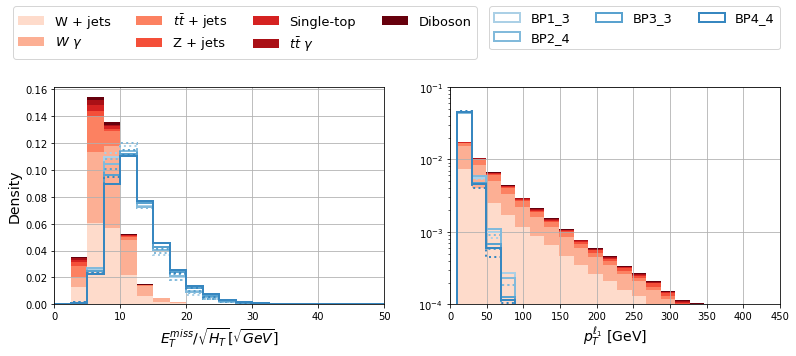

In [43]:
fig,ax = plt.subplots(1,2, figsize = (13,4))

# MET sig -----------------------------------------------------------------------------------------------------------------------
ncol = 0
nbins = 20 
bin_range = [0,50]

bkg_list = [MET_sig_wjets[:wjets_sample], MET_sig_wgamma[:wgamma_sample], MET_sig_ttjets[:ttjets_sample],
            MET_sig_zjets[:zjets_sample], 
            np.concatenate((MET_sig_tj[:tj_sample], MET_sig_tb[:tb_sample], MET_sig_tw[:tw_sample])), 
            MET_sig_ttgamma[:ttgamma_sample], 
            np.concatenate((MET_sig_zz[:zz_sample], MET_sig_wz[:wz_sample], MET_sig_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , nbins, stacked=True, density=True, color = colors, range = bin_range)
ax[ncol].legend(labels = bkg_labels,fontsize=13,bbox_to_anchor=(1.30, 1.4), ncol = 4) 

for i, bps2plot in enumerate(BPs2plot):
    ind0 = np.where(np.asarray(name) == bps2plot + '_n2')[0][0]
    ax[ncol].hist(MET_sig_NP[ind0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True)
    ind1 = np.where(np.asarray(name) == bps2plot + '_n3')[0][0]
    ax[ncol].hist(MET_sig_NP[ind1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True, ls = ':')
    #%ax[ncol].hist(np.hstack((MET_sig_NP[ind0],MET_sig_NP[ind1])), bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True)
    
ax[ncol].grid()
ax[ncol].set_xlabel(r"$E_{T}^{miss} / \sqrt{H_{T}} [\sqrt{GeV}]$",fontsize=14)
ax[ncol].set_ylabel("Density",fontsize=14)
#ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,50)
#ax[ncol].set_ylim(5e-5,1)

# Pt lepton -----------------------------------------------------------------------------------------------------------------------
ncol = 1
nbins  = 50
bin_range = [10,1000]

bkg_list = [lepton_wjets[:wjets_sample,0], lepton_wgamma[:wgamma_sample,0], lepton_ttjets[:ttjets_sample,0],
            lepton_zjets[:zjets_sample,0],
            np.concatenate((lepton_tj[:tj_sample,0], lepton_tb[:tb_sample,0], lepton_tw[:tw_sample,0])), 
            lepton_ttgamma[:ttgamma_sample,0], 
            np.concatenate((lepton_zz[:zz_sample,0], lepton_wz[:wz_sample,0], lepton_ww[:ww_sample,0]))]

ax[ncol].hist(bkg_list , nbins, stacked=True, density=True, color = colors, range = bin_range)


for i, bps2plot in enumerate(BPs2plot):
    ind0 = np.where(np.asarray(name) == bps2plot + '_n2')[0][0]
    ax[ncol].hist(lepton_NP[ind0][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True, label = bps2plot)
    ind1 = np.where(np.asarray(name) == bps2plot + '_n3')[0][0]
    ax[ncol].hist(lepton_NP[ind1][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True, ls = ':')
    #ax[ncol].hist(np.hstack((lepton_NP[ind0][:,0],lepton_NP[ind1][:,0])), bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True, label = bps2plot)
ax[ncol].legend(loc='upper right',fontsize=13,bbox_to_anchor=(1.02, 1.4), ncol = 3)


ax[ncol].grid()
ax[ncol].set_xlabel(r"$p_{T}^{\ell_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_ylim(1e-4,0.1)
ax[ncol].set_xlim(0,450)

plt.savefig('../graph/MET_sig_PT_lepton_BPs_z5.pdf', bbox_inches='tight')

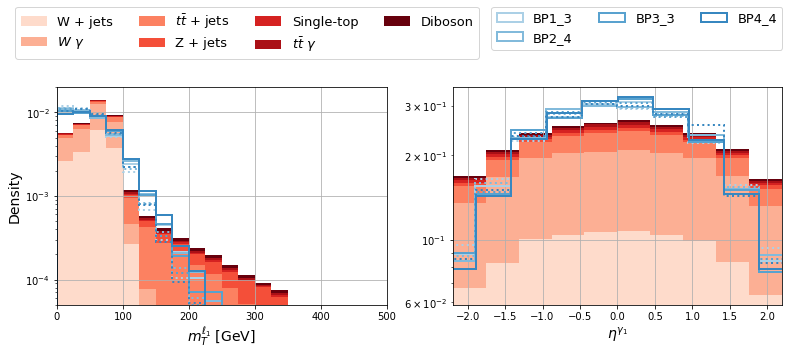

In [49]:
fig,ax = plt.subplots(1,2, figsize = (13,4))


# Mt lepton info -----------------------------------------------------------------------------------------------------------------------
ncol = 0
nbins = 20
bin_range = [0,500]

bkg_list = [mT_lepton_wjets[:wjets_sample], mT_lepton_wgamma[:wgamma_sample], mT_lepton_ttjets[:ttjets_sample],
            mT_lepton_zjets[:zjets_sample], 
            np.concatenate((mT_lepton_tj[:tj_sample], mT_lepton_tb[:tb_sample], mT_lepton_tw[:tw_sample])),
            mT_lepton_ttgamma[:ttgamma_sample],
            np.concatenate((mT_lepton_zz[:zz_sample], mT_lepton_wz[:wz_sample], mT_lepton_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , nbins, stacked=True, density=True, color = colors, range = bin_range)
ax[ncol].legend(labels = bkg_labels,fontsize=13,bbox_to_anchor=(1.3, 1.4), ncol = 4) 

for i, bps2plot in enumerate(BPs2plot):
    ind0 = np.where(np.asarray(name) == bps2plot + '_n2')[0][0]
    ax[ncol].hist(mT_lepton_NP[ind0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True)
    ind1 = np.where(np.asarray(name) == bps2plot + '_n3')[0][0]
    ax[ncol].hist(mT_lepton_NP[ind1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True, ls = ':')


ax[ncol].grid()
ax[ncol].set_xlabel(r"$m_{T}^{\ell_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,500)
ax[ncol].set_ylim(5e-5,2e-2)
ax[ncol].set_ylabel("Density",fontsize=14)

# eta Photon -----------------------------------------------------------------------------------------------------------------------
ncol = 1
nbins = 10
bin_range = [-2.2,2.2]

bkg_list = [photon_wjets[:wjets_sample,1], photon_wgamma[:wgamma_sample,1], photon_ttjets[:ttjets_sample,1],
            photon_zjets[:zjets_sample,1], 
            np.concatenate((photon_tj[:tj_sample,1], photon_tb[:tb_sample,1], photon_tw[:tw_sample,1])),
            photon_ttgamma[:ttgamma_sample,1],
            np.concatenate((photon_zz[:zz_sample,1],photon_wz[:wz_sample,1],photon_ww[:ww_sample,1]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i, bps2plot in enumerate(BPs2plot):
    ind0 = np.where(np.asarray(name) == bps2plot + '_n2')[0][0]
    ax[ncol].hist(photon_NP[ind0][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, label = bps2plot)
    ind1 = np.where(np.asarray(name) == bps2plot + '_n3')[0][0]
    ax[ncol].hist(photon_NP[ind1][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, ls = ':')


ax[ncol].legend(loc='upper right',fontsize=13,bbox_to_anchor=(1.02, 1.4), ncol = 3)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$\eta^{\gamma_{1}}$",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(-2.2,2.2)
#ax[ncol].set_ylabel("Density",fontsize=14)


plt.savefig('../graph/mt_lepton_eta_photon_BPs_z5.pdf', bbox_inches='tight')

In [ ]:

# Mt photon
ncol = 1
nbins = 20
bin_range = [0,500]

bkg_list = [mT_photon_wjets[:wjets_sample], mT_photon_wgamma[:wgamma_sample], mT_photon_ttjets[:ttjets_sample],
            mT_photon_zjets[:zjets_sample], 
            np.concatenate((mT_photon_tj[:tj_sample], mT_photon_tb[:tb_sample], mT_photon_tw[:tw_sample])),
            mT_photon_ttgamma[:ttgamma_sample],
            np.concatenate((mT_photon_zz[:zz_sample], mT_photon_wz[:wz_sample], mT_photon_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , nbins, stacked=True, density=True, color = colors, range = bin_range)

for i, bps2plot in enumerate(BPs2plot):
    ind0 = np.where(np.asarray(name) == bps2plot + '_n2')[0][0]
    ax[ncol].hist(mT_photon_NP[ind0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True, label = bps2plot)
    ind1 = np.where(np.asarray(name) == bps2plot + '_n3')[0][0]
    ax[ncol].hist(mT_photon_NP[ind1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True, ls = ':')
#ax[ncol].legend(loc='upper right',fontsize=13,bbox_to_anchor=(1., 1.4), ncol = 3)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$m_{T}^{\gamma_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_ylim(1e-4,2e-2)
ax[ncol].set_xlim(0,500)


(150.0, 1600.0)

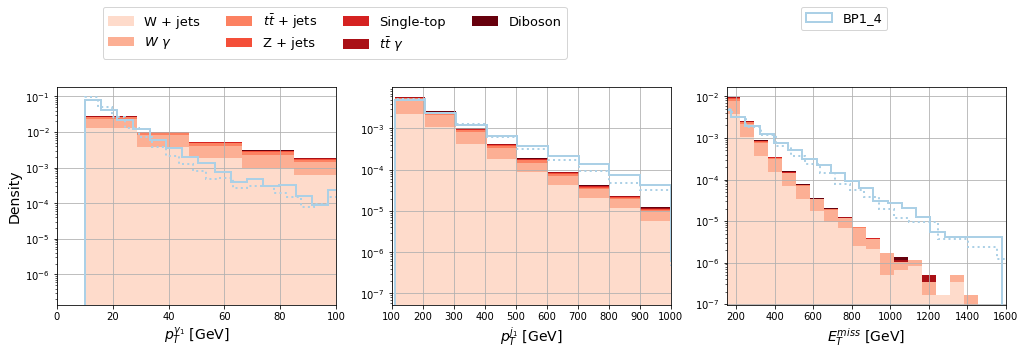

In [417]:
fig,ax = plt.subplots(1,3, figsize = (17,4))

# Pt Photon -----------------------------------------------------------------------------------------------------------------------
ncol  = 0
nbins = 100#np.array([  10.,  109.,  208.,  307.,  406.,  505.,  604.,  703.,  802.,
         #901., 1000.,10000])

bkg_list = [photon_wjets[:wjets_sample,0], photon_wgamma[:wgamma_sample,0], photon_ttjets[:ttjets_sample,0], 
            photon_zjets[:zjets_sample,0], 
            np.concatenate((photon_tj[:tj_sample,0], photon_tb[:tb_sample,0], photon_tw[:tw_sample,0])),
            photon_ttgamma[:ttgamma_sample,0], 
            np.concatenate((photon_zz[:zz_sample,0],photon_wz[:wz_sample,0],photon_ww[:ww_sample,0]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)
ax[ncol].legend(labels = bkg_labels,fontsize=13,bbox_to_anchor=(1.85, 1.4), ncol = 4) 


for i, bps2plot in enumerate(BPs2plot):
    ind0 = np.where(np.asarray(name) == bps2plot + '_n2')[0][0]
    ax[ncol].hist(photon_NP[ind0][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)
    ind1 = np.where(np.asarray(name) == bps2plot + '_n3')[0][0]
    ax[ncol].hist(photon_NP[ind1][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, ls = ':')

ax[ncol].grid()
ax[ncol].set_xlabel(r"$p_{T}^{\gamma_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,100)
ax[ncol].set_ylabel("Density",fontsize=14)


# Pt jet -----------------------------------------------------------------------------------------------------------------------
ncol = 1
nbins = np.array([109.,  208.,  307.,  406.,  505.,  604.,  703.,  802.,
         901., 1000.,10000])

bkg_list = [jet_wjets[:wjets_sample,0], jet_wgamma[:wgamma_sample,0], jet_ttjets[:ttjets_sample,0], 
            jet_zjets[:zjets_sample,0], 
            np.concatenate((jet_tj[:tj_sample,0], jet_tb[:tb_sample,0], jet_tw[:tw_sample,0])),
            jet_ttgamma[:ttgamma_sample,0],
            np.concatenate((jet_zz[:zz_sample,0],jet_wz[:wz_sample,0],jet_ww[:ww_sample,0]))
           ]
ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)

for i, bps2plot in enumerate(BPs2plot):
    ind0 = np.where(np.asarray(name) == bps2plot + '_n2')[0][0]
    ax[ncol].hist(jet_NP[ind0][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, label = bps2plot)
    ind1 = np.where(np.asarray(name) == bps2plot + '_n3')[0][0]
    ax[ncol].hist(jet_NP[ind1][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, ls = ':')
ax[ncol].legend(loc='upper right',fontsize=13,bbox_to_anchor=(1.8, 1.4), ncol = 3)
    
ax[ncol].grid()
ax[ncol].set_xlabel(r"$p_{T}^{j_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(100,1000)



# Pt MET -----------------------------------------------------------------------------------------------------------------------
ncol = 2
nbins = 20
bin_range = [150,1600]

bkg_list = [MET_wjets[:wjets_sample,0], MET_wgamma[:wgamma_sample,0], MET_ttjets[:ttjets_sample,0], 
            MET_zjets[:zjets_sample,0], 
            np.concatenate((MET_tj[:tj_sample,0], MET_tb[:tb_sample,0], MET_tw[:tw_sample,0])),
            MET_ttgamma[:ttgamma_sample,0],
            np.concatenate((MET_zz[:zz_sample,0],MET_wz[:wz_sample,0],MET_ww[:ww_sample,0]))
           ]
ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i, bps2plot in enumerate(BPs2plot):
    ind0 = np.where(np.asarray(name) == bps2plot + '_n2')[0][0]
    ax[ncol].hist(MET_NP[ind0][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)
    ind1 = np.where(np.asarray(name) == bps2plot + '_n3')[0][0]
    ax[ncol].hist(MET_NP[ind1][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, ls = ':')


ax[ncol].grid()
ax[ncol].set_xlabel(r"$E_{T}^{miss}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(150,1600)

#plt.savefig('../graph/PT_photon_PT_jet_ETmiss.pdf', bbox_inches='tight')

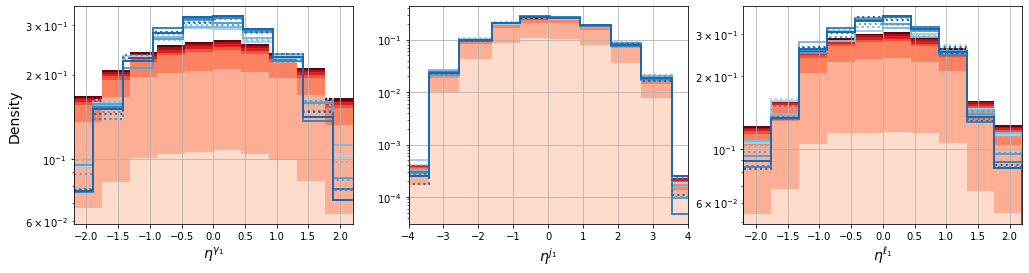

In [40]:
fig,ax = plt.subplots(1,3, figsize = (17,4))

# eta Photon -----------------------------------------------------------------------------------------------------------------------
ncol = 0
nbins = 10
bin_range = [-2.2,2.2]

bkg_list = [photon_wjets[:wjets_sample,1], photon_wgamma[:wgamma_sample,1], photon_ttjets[:ttjets_sample,1],
            photon_zjets[:zjets_sample,1], 
            np.concatenate((photon_tj[:tj_sample,1], photon_tb[:tb_sample,1], photon_tw[:tw_sample,1])),
            photon_ttgamma[:ttgamma_sample,1],
            np.concatenate((photon_zz[:zz_sample,1],photon_wz[:wz_sample,1],photon_ww[:ww_sample,1]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i, bps2plot in enumerate(BPs2plot):
    ind0 = np.where(np.asarray(name) == bps2plot + '_n2')[0][0]
    ax[ncol].hist(photon_NP[ind0][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)
    ind1 = np.where(np.asarray(name) == bps2plot + '_n3')[0][0]
    ax[ncol].hist(photon_NP[ind1][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, ls = ':')

ax[ncol].grid()
ax[ncol].set_xlabel(r"$\eta^{\gamma_{1}}$",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(-2.2,2.2)
ax[ncol].set_ylabel("Density",fontsize=14)


# eta jet -----------------------------------------------------------------------------------------------------------------------
ncol = 1
nbins = np.asarray([-8.3 , -3.42, -2.55, -1.62, -0.80, 0.063 , 0.93, 1.80, 2.68, 3.55, 8.42])

bkg_list = [jet_wjets[:wjets_sample,1], jet_wgamma[:wgamma_sample,1], jet_ttjets[:ttjets_sample,1],
            jet_zjets[:zjets_sample,1], 
            np.concatenate((jet_tj[:tj_sample,1], jet_tb[:tb_sample,1], jet_tw[:tw_sample,1])),
            jet_ttgamma[:ttgamma_sample,1], 
            np.concatenate((jet_zz[:zz_sample,1],jet_wz[:wz_sample,1],jet_ww[:ww_sample,1]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i, bps2plot in enumerate(BPs2plot):
    ind0 = np.where(np.asarray(name) == bps2plot + '_n2')[0][0]
    ax[ncol].hist(jet_NP[ind0][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)
    ind1 = np.where(np.asarray(name) == bps2plot + '_n3')[0][0]
    ax[ncol].hist(jet_NP[ind1][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, ls = ':')

ax[ncol].grid()
ax[ncol].set_xlabel(r"$\eta^{j_{1}}$",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(-4.,4.)


# eta lepton -----------------------------------------------------------------------------------------------------------------------
ncol = 2
nbins = 10
bin_range = [-2.2,2.2]

bkg_list = [lepton_wjets[:wjets_sample,1], lepton_wgamma[:wgamma_sample,1], lepton_ttjets[:ttjets_sample,1],
            lepton_zjets[:zjets_sample,1], 
            np.concatenate((lepton_tj[:tj_sample,1], lepton_tb[:tb_sample,1], lepton_tw[:tw_sample,1])),
            lepton_ttgamma[:ttgamma_sample,1],
            np.concatenate((lepton_zz[:zz_sample,1],lepton_wz[:wz_sample,1],lepton_ww[:ww_sample,1]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i, bps2plot in enumerate(BPs2plot):
    ind0 = np.where(np.asarray(name) == bps2plot + '_n2')[0][0]
    ax[ncol].hist(lepton_NP[ind0][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range)
    ind1 = np.where(np.asarray(name) == bps2plot + '_n3')[0][0]
    ax[ncol].hist(lepton_NP[ind1][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range, ls = ':')

ax[ncol].grid()
ax[ncol].set_xlabel(r"$\eta^{\ell_{1}}$",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(-2.2,2.2)

plt.savefig('../graph/eta_photon_lepton_jet_dist.pdf', bbox_inches='tight')

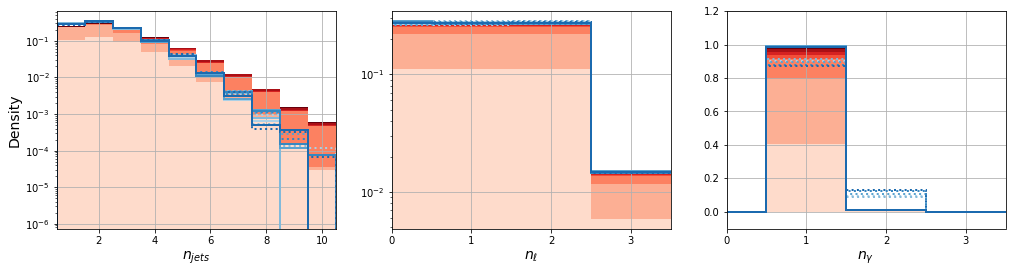

In [41]:
fig,ax = plt.subplots(1,3, figsize = (17,4))


# Num jets
ncol = 0
nbins = np.asarray([-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,25])

bkg_list = [hadinfo_wjets[:wjets_sample,2], hadinfo_wgamma[:wgamma_sample,2], hadinfo_ttjets[:ttjets_sample,2],
            hadinfo_zjets[:zjets_sample,2], 
            np.concatenate((hadinfo_tj[:tj_sample,2], hadinfo_tb[:tb_sample,2], hadinfo_tw[:tw_sample,2])),
            hadinfo_ttgamma[:ttgamma_sample,2],
            np.concatenate((hadinfo_zz[:zz_sample,2],hadinfo_wz[:wz_sample,2],hadinfo_ww[:ww_sample,2]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)

for i, bps2plot in enumerate(BPs2plot):
    ind0 = np.where(np.asarray(name) == bps2plot + '_n2')[0][0]
    ax[ncol].hist(hadinfo_NP[ind0][:,2], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)
    ind1 = np.where(np.asarray(name) == bps2plot + '_n3')[0][0]
    ax[ncol].hist(hadinfo_NP[ind1][:,2], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, ls = ':')

ax[ncol].grid()
ax[ncol].set_xlabel(r"$n_{jets}$ ",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0.5,10.5)

ax[ncol].set_ylabel("Density",fontsize=14)

# Num leptons
ncol = 1
nbins = np.asarray([-0.5,0.5,1.5,2.5,14.5])

bkg_list = [lepton_wjets[:wjets_sample,2], lepton_wgamma[:wgamma_sample,2], lepton_ttjets[:ttjets_sample,2],
            lepton_zjets[:zjets_sample,2], 
            np.concatenate((lepton_tj[:tj_sample,2], lepton_tb[:tb_sample,2], lepton_tw[:tw_sample,2])),
            lepton_ttgamma[:ttgamma_sample,2],
            np.concatenate((lepton_zz[:zz_sample,2],lepton_wz[:wz_sample,2],lepton_ww[:ww_sample,2]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)

for i, bps2plot in enumerate(BPs2plot):
    ind0 = np.where(np.asarray(name) == bps2plot + '_n2')[0][0]
    ax[ncol].hist(lepton_NP[ind0][:,2], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)
    ind1 = np.where(np.asarray(name) == bps2plot + '_n3')[0][0]
    ax[ncol].hist(lepton_NP[ind1][:,2], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, ls = ':')

ax[ncol].grid()
ax[ncol].set_xlabel(r"$n_{\ell}$ ",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0.5,3.5)
ax[ncol].set_xticks([0,1,2,3])


# Num photons
ncol = 2
bins = [0.5,1.5,2.5,3.5,4.5]

bkg_list = [photon_wjets[:wjets_sample,3], photon_wgamma[:wgamma_sample,3], photon_ttjets[:ttjets_sample,3],
            photon_zjets[:zjets_sample,3], 
            np.concatenate((photon_tj[:tj_sample,3], photon_tb[:tb_sample,3], photon_tw[:tw_sample,3])),
            photon_ttgamma[:ttgamma_sample,3],
            np.concatenate((photon_zz[:zz_sample,3],photon_wz[:wz_sample,3],photon_ww[:ww_sample,3]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)

for i, bps2plot in enumerate(BPs2plot):
    ind0 = np.where(np.asarray(name) == bps2plot + '_n2')[0][0]
    ax[ncol].hist(photon_NP[ind0][:,3], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)
    ind1 = np.where(np.asarray(name) == bps2plot + '_n3')[0][0]
    ax[ncol].hist(photon_NP[ind1][:,3], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, ls = ':')

ax[ncol].grid()
ax[ncol].set_xlabel(r"$n_{\gamma}$",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_xlim(0.5,3.5)
ax[ncol].set_ylim(-0.1,1.2)
ax[ncol].set_xticks([0,1,2,3])

plt.savefig('../graph/njets_nleptons_nphoton.pdf', bbox_inches='tight')

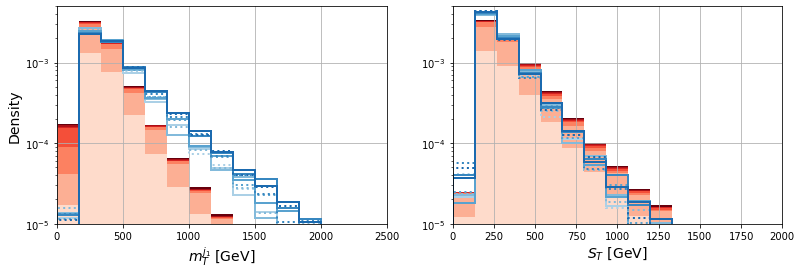

In [42]:
fig,ax = plt.subplots(1,2, figsize = (13,4))

# Mt jet info -----------------------------------------------------------------------------------------------------------------------
ncol = 0
nbins = 15
bin_range = [0,2500]

bkg_list = [mT_jet_wjets[:wjets_sample], mT_jet_wgamma[:wgamma_sample], mT_jet_ttjets[:ttjets_sample],
            mT_jet_zjets[:zjets_sample], 
            np.concatenate((mT_jet_tj[:tj_sample], mT_jet_tb[:tb_sample], mT_jet_tw[:tw_sample])),
            mT_jet_ttgamma[:ttgamma_sample],
            np.concatenate((mT_jet_zz[:zz_sample], mT_jet_wz[:wz_sample], mT_jet_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i, bps2plot in enumerate(BPs2plot):
    ind0 = np.where(np.asarray(name) == bps2plot + '_n2')[0][0]
    ax[ncol].hist(mT_jet_NP[ind0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range)
    ind1 = np.where(np.asarray(name) == bps2plot + '_n3')[0][0]
    ax[ncol].hist(mT_jet_NP[ind1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range, ls = ':')

ax[ncol].grid()
ax[ncol].set_xlabel(r"$m_{T}^{j_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,2500)
ax[ncol].set_ylim(1e-5,5e-3)
ax[ncol].set_ylabel("Density",fontsize=14)


# ST info
ncol = 1
nbins = 15
bin_range = [0,2000]

bkg_list = [ST_wjets[:wjets_sample], ST_wgamma[:wgamma_sample], ST_ttjets[:ttjets_sample],
            ST_zjets[:zjets_sample], 
            np.concatenate((ST_tj[:tj_sample], ST_tb[:tb_sample], ST_tw[:tw_sample])),
            ST_ttgamma[:ttgamma_sample],
            np.concatenate((ST_zz[:zz_sample], ST_wz[:wz_sample], ST_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i, bps2plot in enumerate(BPs2plot):
    ind0 = np.where(np.asarray(name) == bps2plot + '_n2')[0][0]
    ax[ncol].hist(ST_NP[ind0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range)
    ind1 = np.where(np.asarray(name) == bps2plot + '_n3')[0][0]
    ax[ncol].hist(ST_NP[ind1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range, ls = ':')

ax[ncol].grid()
ax[ncol].set_xlabel(r"$S_{T}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,2000)
ax[ncol].set_ylim(1e-5,5e-3)

plt.savefig('../graph/mt_jet_ST.pdf', bbox_inches='tight')

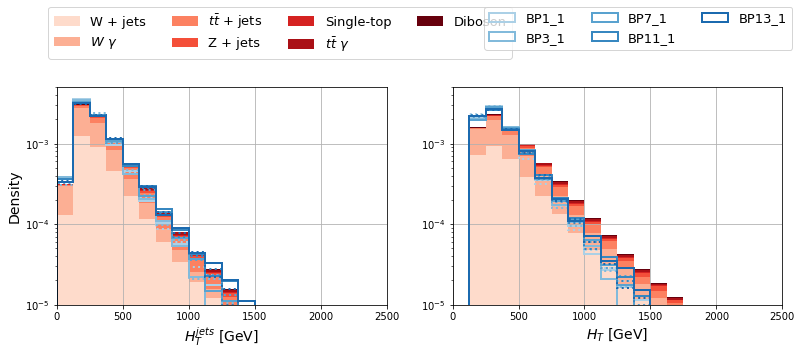

In [43]:
nbins = 20#np.asarray([121.16, 467.7, 814.2, 1160.8, 1507.3, 1853.9, 2200.4, 2546.9, 2893.5, 3240.0, 10000])

fig,ax = plt.subplots(1,2, figsize = (13,4))

# Ht info -----------------------------------------------------------------------------------------------------------------------
ncol = 0
xlabels = [r"$H_{T}^{jets}$ [GeV]", r"$H_{T}^{jets}$ [GeV]"]
bin_range = [0,2500]
nbins = 20

bkg_list = [hadinfo_wjets[:wjets_sample,1], hadinfo_wgamma[:wgamma_sample,1], hadinfo_ttjets[:ttjets_sample,1],
            hadinfo_zjets[:zjets_sample,1], 
            np.concatenate((hadinfo_tj[:tj_sample,1], hadinfo_tb[:tb_sample,1], hadinfo_tw[:tw_sample,1])),
            hadinfo_ttgamma[:ttgamma_sample,1],
            np.concatenate((hadinfo_zz[:zz_sample,1],hadinfo_wz[:wz_sample,1],hadinfo_ww[:ww_sample,1]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)
ax[ncol].legend(labels = bkg_labels,fontsize=13,bbox_to_anchor=(1.40, 1.4), ncol = 4) 

for i, bps2plot in enumerate(BPs2plot):
    ind0 = np.where(np.asarray(name) == bps2plot + '_n2')[0][0]
    ax[ncol].hist(hadinfo_NP[ind0][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range)
    ind1 = np.where(np.asarray(name) == bps2plot + '_n3')[0][0]
    ax[ncol].hist(hadinfo_NP[ind1][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range, ls = ':')

ax[ncol].grid()
ax[ncol].set_xlabel(r"$H_{T}^{jets}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("Density",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,2500)
ax[ncol].set_ylim(1e-5,5e-3)

# HT
ncol = 1

bkg_list = [hadinfo_wjets[:wjets_sample,0], hadinfo_wgamma[:wgamma_sample,0], hadinfo_ttjets[:ttjets_sample,0],
            hadinfo_zjets[:zjets_sample,0], 
            np.concatenate((hadinfo_tj[:tj_sample,0], hadinfo_tb[:tb_sample,0], hadinfo_tw[:tw_sample,0])),
            hadinfo_ttgamma[:ttgamma_sample,0],
            np.concatenate((hadinfo_zz[:zz_sample,0],hadinfo_wz[:wz_sample,0],hadinfo_ww[:ww_sample,0]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i, bps2plot in enumerate(BPs2plot):
    ind0 = np.where(np.asarray(name) == bps2plot + '_n2')[0][0]
    ax[ncol].hist(hadinfo_NP[ind0][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range, label = bps2plot)
    ind1 = np.where(np.asarray(name) == bps2plot + '_n3')[0][0]
    ax[ncol].hist(hadinfo_NP[ind1][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range, ls = ':')
ax[ncol].legend(loc='upper right',fontsize=13,bbox_to_anchor=(1.05, 1.4), ncol = 3)
    
ax[ncol].grid()
ax[ncol].set_xlabel(r"$H_{T}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,2500)
ax[ncol].set_ylim(1e-5,5e-3)

plt.savefig('../graph/HT_info_dist.pdf', bbox_inches='tight')

## ML Analysis

In [631]:
Z_BL_loops          = list(np.load('../data/models/Z_BL_MET100_BPI.npy'))
Z_BL_std_loops      = list(np.load('../data/models/Z_BL_std_MET100_BPI.npy'))
muhat_BL_loops      = list(np.load('../data/models/muhat_BL_MET100_BPI.npy'))
Z_MLL_loops         = list(np.load('../data/models/Z_MLL_MET100_BPI.npy'))
Z_MLL_std_loops     = list(np.load('../data/models/Z_MLL_std_MET100_BPI.npy'))
muhat_MLL_loops     = list(np.load('../data/models/muhat_MLL_MET100_BPI.npy'))
Z_MLL_new_loops     = list(np.load('../data/models/Z_MLL_new_MET100_BPI.npy'))
Z_MLL_new_std_loops = list(np.load('../data/models/Z_MLL_new_std_MET100_BPI.npy'))
muhat_MLL_new_loops = list(np.load('../data/models/muhat_MLL_new_MET100_BPI.npy'))
#Z_sbc_loops         = list(np.load('../data/models/Z_sbc_MET100_BPI.npy'))
#Z_sbc_std_loops     = list(np.load('../data/models/Z_sbc_std_MET100_BPI.npy'))

In [632]:
len(Z_BL_loops)

9

In [633]:
lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

In [634]:
len(photon_NP)

120

In [635]:
nobs = len(photon_SM)
BPS_trained = np.arange(60)
BPs_names = list(results.keys())
nobs_bp = round(nobs / len(BPS_trained))

SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

df = pd.DataFrame()

#np.random.seed(28890)

mask_list = []
for bp in BPS_trained:
    print(BPs_names[bp])
    
    n2_expected = results[BPs_names[bp]]['pptox1n2']['#Signal_expected']
    n3_expected = results[BPs_names[bp]]['pptox1n3']['#Signal_expected']
    tot_expected = n2_expected + n3_expected

    nobs_n2 = int(nobs_bp * n2_expected / tot_expected)
    nobs_n3 = int(nobs_bp * n3_expected / tot_expected)

    if len(photon_NP[2*bp]) < nobs_n2:
        print('HAY QUE SIMULAR MAS ' + BPs_names[bp] + '_n2')
        BP_indices_n2 = np.random.choice(np.arange(len(photon_NP[2*bp])), size = nobs_n2, replace = True)
    else:
        BP_indices_n2 = np.random.choice(np.arange(len(photon_NP[2*bp])), size = nobs_n2, replace = False)
    if len(photon_NP[2*bp+1]) < nobs_n3:
        print('HAY QUE SIMULAR MAS ' + BPs_names[bp] + '_n3')
        BP_indices_n3 = np.random.choice(np.arange(len(photon_NP[2*bp+1])), size = nobs_n3, replace = True)
    else:
        BP_indices_n3 = np.random.choice(np.arange(len(photon_NP[2*bp+1])), size = nobs_n3, replace = False)
    
    mask = np.ones(len(photon_NP[2*bp]), dtype=bool)
    mask[BP_indices_n2] = False
    mask_list.append( mask )
    mask = np.ones(len(photon_NP[2*bp+1]), dtype=bool)
    mask[BP_indices_n3] = False
    mask_list.append( mask )
    
    if bp == 0:
        
        df[lst[0]] = np.concatenate([photon_SM[SM_indices,0],photon_NP[2*bp][BP_indices_n2,0],photon_NP[2*bp+1][BP_indices_n3,0]])
        df[lst[1]] = np.concatenate([photon_SM[SM_indices,1],photon_NP[2*bp][BP_indices_n2,1],photon_NP[2*bp+1][BP_indices_n3,1]])
        df[lst[2]] = np.concatenate([photon_SM[SM_indices,2],photon_NP[2*bp][BP_indices_n2,2],photon_NP[2*bp+1][BP_indices_n3,2]])
        df[lst[3]] = np.concatenate([photon_SM[SM_indices,3],photon_NP[2*bp][BP_indices_n2,3],photon_NP[2*bp+1][BP_indices_n3,3]])

        df[lst[4]] = np.concatenate([jet_SM[SM_indices,0],jet_NP[2*bp][BP_indices_n2,0],jet_NP[2*bp+1][BP_indices_n3,0]])
        df[lst[5]] = np.concatenate([jet_SM[SM_indices,1],jet_NP[2*bp][BP_indices_n2,1],jet_NP[2*bp+1][BP_indices_n3,1]])
        df[lst[6]] = np.concatenate([jet_SM[SM_indices,2],jet_NP[2*bp][BP_indices_n2,2],jet_NP[2*bp+1][BP_indices_n3,2]])

        df[lst[7]] = np.concatenate([lepton_SM[SM_indices,0],lepton_NP[2*bp][BP_indices_n2,0],lepton_NP[2*bp+1][BP_indices_n3,0]])
        df[lst[8]] = np.concatenate([lepton_SM[SM_indices,1],lepton_NP[2*bp][BP_indices_n2,1],lepton_NP[2*bp+1][BP_indices_n3,1]])
        df[lst[9]] = np.concatenate([lepton_SM[SM_indices,2],lepton_NP[2*bp][BP_indices_n2,2],lepton_NP[2*bp+1][BP_indices_n3,2]])
        df[lst[10]] = np.concatenate([lepton_SM[SM_indices,3],lepton_NP[2*bp][BP_indices_n2,3],lepton_NP[2*bp+1][BP_indices_n3,3]])
        df[lst[11]] = np.concatenate([lepton_SM[SM_indices,4],lepton_NP[2*bp][BP_indices_n2,4],lepton_NP[2*bp+1][BP_indices_n3,4]])

        df[lst[12]] = np.concatenate([MET_SM[SM_indices,0],MET_NP[2*bp][BP_indices_n2,0],MET_NP[2*bp+1][BP_indices_n3,0]])
        df[lst[13]] = np.concatenate([MET_SM[SM_indices,2],MET_NP[2*bp][BP_indices_n2,2],MET_NP[2*bp+1][BP_indices_n3,2]])

        df[lst[14]] = np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[2*bp][BP_indices_n2,0],hadinfo_NP[2*bp+1][BP_indices_n3,0]])
        df[lst[15]] = np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[2*bp][BP_indices_n2,1],hadinfo_NP[2*bp+1][BP_indices_n3,1]])
        df[lst[16]] = np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[2*bp][BP_indices_n2,2],hadinfo_NP[2*bp+1][BP_indices_n3,2]])

        df[lst[17]] = np.concatenate([ST_SM[SM_indices], ST_NP[2*bp][BP_indices_n2], ST_NP[2*bp+1][BP_indices_n3]])
        df[lst[18]] = np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[2*bp][BP_indices_n2], MET_sig_NP[2*bp+1][BP_indices_n3]])

        df[lst[19]] = np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[2*bp][BP_indices_n2], mT_photon_NP[2*bp+1][BP_indices_n3]])
        df[lst[20]] = np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[2*bp][BP_indices_n2], mT_jet_NP[2*bp+1][BP_indices_n3]])
        df[lst[21]] = np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[2*bp][BP_indices_n2], mT_lepton_NP[2*bp+1][BP_indices_n3]])


        df['bkg_flag'] = np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[2*bp][BP_indices_n2])), np.zeros(len(photon_NP[2*bp+1][BP_indices_n3]))) )

        df[lst[22]] = np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[2*bp][BP_indices_n2])), np.ones(len(photon_NP[2*bp+1][BP_indices_n3]))])
        
        df['bp_flag'] = np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[2*bp][BP_indices_n2])) * (bp+1), np.ones(len(photon_NP[2*bp+1][BP_indices_n3])) * (bp+1) ])
    else:
        df_aux = pd.DataFrame()
        
        df_aux[lst[0]] = np.concatenate([photon_NP[2*bp][BP_indices_n2,0],photon_NP[2*bp+1][BP_indices_n3,0]]) 
        df_aux[lst[1]] = np.concatenate([photon_NP[2*bp][BP_indices_n2,1],photon_NP[2*bp+1][BP_indices_n3,1]]) 
        df_aux[lst[2]] = np.concatenate([photon_NP[2*bp][BP_indices_n2,2],photon_NP[2*bp+1][BP_indices_n3,2]]) 
        df_aux[lst[3]] = np.concatenate([photon_NP[2*bp][BP_indices_n2,3],photon_NP[2*bp+1][BP_indices_n3,3]]) 

        df_aux[lst[4]] = np.concatenate([ jet_NP[2*bp][BP_indices_n2,0],jet_NP[2*bp+1][BP_indices_n3,0] ]) 
        df_aux[lst[5]] = np.concatenate([ jet_NP[2*bp][BP_indices_n2,1],jet_NP[2*bp+1][BP_indices_n3,1] ]) 
        df_aux[lst[6]] = np.concatenate([ jet_NP[2*bp][BP_indices_n2,2],jet_NP[2*bp+1][BP_indices_n3,2] ]) 

        df_aux[lst[7]] = np.concatenate([ lepton_NP[2*bp][BP_indices_n2,0],lepton_NP[2*bp+1][BP_indices_n3,0] ]) 
        df_aux[lst[8]] = np.concatenate([ lepton_NP[2*bp][BP_indices_n2,1],lepton_NP[2*bp+1][BP_indices_n3,1] ]) 
        df_aux[lst[9]] = np.concatenate([ lepton_NP[2*bp][BP_indices_n2,2],lepton_NP[2*bp+1][BP_indices_n3,2] ]) 
        df_aux[lst[10]] = np.concatenate([ lepton_NP[2*bp][BP_indices_n2,3],lepton_NP[2*bp+1][BP_indices_n3,3] ]) 
        df_aux[lst[11]] = np.concatenate([ lepton_NP[2*bp][BP_indices_n2,4],lepton_NP[2*bp+1][BP_indices_n3,4] ]) 

        df_aux[lst[12]] = np.concatenate([ MET_NP[2*bp][BP_indices_n2,0], MET_NP[2*bp+1][BP_indices_n3,0] ]) 
        df_aux[lst[13]] = np.concatenate([ MET_NP[2*bp][BP_indices_n2,2], MET_NP[2*bp+1][BP_indices_n3,2] ]) 

        df_aux[lst[14]] = np.concatenate([ hadinfo_NP[2*bp][BP_indices_n2,0], hadinfo_NP[2*bp+1][BP_indices_n3,0] ]) 
        df_aux[lst[15]] = np.concatenate([ hadinfo_NP[2*bp][BP_indices_n2,1], hadinfo_NP[2*bp+1][BP_indices_n3,1] ]) 
        df_aux[lst[16]] = np.concatenate([ hadinfo_NP[2*bp][BP_indices_n2,2], hadinfo_NP[2*bp+1][BP_indices_n3,2] ]) 

        df_aux[lst[17]] = np.concatenate([ ST_NP[2*bp][BP_indices_n2], ST_NP[2*bp+1][BP_indices_n3] ])
        df_aux[lst[18]] = np.concatenate([ MET_sig_NP[2*bp][BP_indices_n2], MET_sig_NP[2*bp+1][BP_indices_n3] ]) 

        df_aux[lst[19]] = np.concatenate([ mT_photon_NP[2*bp][BP_indices_n2], mT_photon_NP[2*bp+1][BP_indices_n3] ]) 
        df_aux[lst[20]] = np.concatenate([ mT_jet_NP[2*bp][BP_indices_n2], mT_jet_NP[2*bp+1][BP_indices_n3] ]) 
        df_aux[lst[21]] = np.concatenate([ mT_lepton_NP[2*bp][BP_indices_n2], mT_lepton_NP[2*bp+1][BP_indices_n3] ]) 


        df_aux['bkg_flag'] = np.concatenate([ np.zeros(len(photon_NP[2*bp][BP_indices_n2])), np.zeros(len(photon_NP[2*bp+1][BP_indices_n3])) ])

        df_aux[lst[22]] = np.concatenate([ np.ones(len(photon_NP[2*bp][BP_indices_n2])), np.ones(len(photon_NP[2*bp+1][BP_indices_n3])) ])
        df_aux['bp_flag'] = np.concatenate([ np.ones(len(photon_NP[2*bp][BP_indices_n2])), np.ones(len(photon_NP[2*bp+1][BP_indices_n3])) ]) * (bp+1) 
        
        df = pd.concat((df, df_aux))
df_array = np.asarray(df)
df

1_1
1_2
1_3
1_4
2_1
2_2
2_3
2_4
2_5
3_1
3_2
3_3
3_4
4_1
4_2
4_3
4_4
4_5
5_1
5_2
5_3
5_4
5_5
6_1
6_2
6_3
6_4
6_5
6_6
7_1
7_2
7_3
7_4
7_5
8_1
8_2
8_3
8_4
9_1
9_2
9_3
9_4
10_1
10_2
10_3
10_4
11_1
11_2
11_3
11_4
11_5
12_1
12_2
12_3
12_4
12_5
13_1
13_2
13_3
13_4


,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag,SM=0 - NP=1,bp_flag
0,13.84,-1.553,-1.275,1.0,137.97,-2.206,-2.072,21.15,0.564,-2.909,...,231.55,3.0,172.96,6.592530,75.819040,238.379547,77.205054,2.0,0.0,0.0
1,22.06,1.802,-2.907,1.0,261.08,1.898,0.438,85.16,0.214,-2.148,...,528.35,3.0,368.30,8.864556,20.012759,482.687113,64.646083,3.0,0.0,0.0
2,35.59,0.356,0.044,1.0,155.80,1.814,0.085,69.03,1.020,-2.565,...,155.80,1.0,260.42,6.412380,120.085328,250.443034,67.703273,1.0,0.0,0.0
3,17.55,-0.697,-0.747,1.0,191.58,-2.102,2.489,10.07,-0.217,-1.550,...,221.00,2.0,219.20,8.457803,6.574391,319.612645,33.160338,2.0,0.0,0.0
4,28.15,-0.148,-0.901,1.0,197.26,-3.460,0.209,66.53,-0.600,2.983,...,436.55,5.0,291.94,7.522422,139.709161,317.089106,75.065762,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3327,10.43,-0.942,-0.543,1.0,218.63,-2.156,-2.078,18.24,-0.958,2.256,...,331.39,3.0,247.30,15.616134,73.773409,507.516065,91.767398,0.0,1.0,60.0
3328,13.29,0.064,-2.736,1.0,391.40,-0.889,-2.346,12.07,-0.357,0.423,...,391.40,1.0,416.76,16.622471,135.772390,745.482941,19.382969,0.0,1.0,60.0
3329,18.09,1.384,-2.743,2.0,175.29,0.847,-0.768,18.35,0.964,0.773,...,224.81,2.0,211.73,12.141663,76.375409,374.785865,78.555975,0.0,1.0,60.0
3330,14.68,0.400,-1.405,2.0,239.40,-1.118,1.830,10.10,-0.092,1.264,...,338.06,2.0,264.18,14.468787,28.482762,509.693644,95.288254,0.0,1.0,60.0


In [636]:
print('There are ' + str(len(np.where(df_array[:,24] == 0)[0])) + ' bkg events')
for i in np.arange(len(BPs_names)):
    print('There are ' + str(len(np.where(df_array[:,24] == (i+1))[0])) + ' BP' +BPs_names[i] + ' events')

There are 200001 bkg events
There are 3332 BP1_1 events
There are 3332 BP1_2 events
There are 3332 BP1_3 events
There are 3332 BP1_4 events
There are 3332 BP2_1 events
There are 3332 BP2_2 events
There are 3332 BP2_3 events
There are 3332 BP2_4 events
There are 3332 BP2_5 events
There are 3332 BP3_1 events
There are 3332 BP3_2 events
There are 3332 BP3_3 events
There are 3332 BP3_4 events
There are 3332 BP4_1 events
There are 3332 BP4_2 events
There are 3332 BP4_3 events
There are 3332 BP4_4 events
There are 3332 BP4_5 events
There are 3332 BP5_1 events
There are 3332 BP5_2 events
There are 3332 BP5_3 events
There are 3332 BP5_4 events
There are 3332 BP5_5 events
There are 3332 BP6_1 events
There are 3332 BP6_2 events
There are 3332 BP6_3 events
There are 3332 BP6_4 events
There are 3332 BP6_5 events
There are 3332 BP6_6 events
There are 3332 BP7_1 events
There are 3332 BP7_2 events
There are 3332 BP7_3 events
There are 3332 BP7_4 events
There are 3332 BP7_5 events
There are 3332 BP8_1

In [637]:
bp = 0
        
n2_expected = results[BPs_names[bp]]['pptox1n2']['#Signal_expected']
n3_expected = results[BPs_names[bp]]['pptox1n3']['#Signal_expected']
tot_expected = n2_expected + n3_expected

nobs_bp = np.min((len(mask_list[2*bp]), len(mask_list[2*bp+1])))
nobs_n2 = int(nobs_bp * n2_expected / tot_expected)
nobs_n3 = int(nobs_bp * n3_expected / tot_expected)

mask_n2 = np.where(mask_list[2*bp] == True)[0][:nobs_n2]


In [638]:
SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

BPS_analyzed = np.arange(60)

df_test = pd.DataFrame()

for bp in BPS_analyzed:
        
    n2_expected = results[BPs_names[bp]]['pptox1n2']['#Signal_expected']
    n3_expected = results[BPs_names[bp]]['pptox1n3']['#Signal_expected']
    tot_expected = n2_expected + n3_expected

    
    nobs_bp = np.min((len(np.where(mask_list[2*bp] == True)[0]), len(np.where(mask_list[2*bp+1] == True)[0])))
    nobs_n2 = int(nobs_bp * n2_expected / tot_expected)
    nobs_n3 = int(nobs_bp * n3_expected / tot_expected)
    
    mask_n2 = np.where(mask_list[2*bp] == True)[0][:nobs_n2]
    mask_n3 = np.where(mask_list[2*bp+1] == True)[0][:nobs_n3]
    
    print(BPs_names[bp])
    #mask = mask_list[bp]
    #mask[np.random.choice(np.arange(len(mask)), (len(mask) - 100_000), replace = False)] = False # Set to false everything but 15000
    if bp == 0:
        
        df_test[lst[0]] = np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[2*bp][mask_n2,0], photon_NP[2*bp+1][mask_n3,0] ])
        df_test[lst[1]] = np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[2*bp][mask_n2,1], photon_NP[2*bp+1][mask_n3,1] ])
        df_test[lst[2]] = np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[2*bp][mask_n2,2], photon_NP[2*bp+1][mask_n3,2] ])
        df_test[lst[3]] = np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[2*bp][mask_n2,3], photon_NP[2*bp+1][mask_n3,3] ])

        df_test[lst[4]] = np.concatenate([jet_SM_pool[SM_indices,0], jet_NP[2*bp][mask_n2,0], jet_NP[2*bp+1][mask_n3,0] ])
        df_test[lst[5]] = np.concatenate([jet_SM_pool[SM_indices,1], jet_NP[2*bp][mask_n2,1], jet_NP[2*bp+1][mask_n3,1] ])
        df_test[lst[6]] = np.concatenate([jet_SM_pool[SM_indices,2], jet_NP[2*bp][mask_n2,2], jet_NP[2*bp+1][mask_n3,2] ])

        df_test[lst[7]] = np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[2*bp][mask_n2,0],lepton_NP[2*bp+1][mask_n3,0] ])
        df_test[lst[8]] = np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[2*bp][mask_n2,1],lepton_NP[2*bp+1][mask_n3,1] ])
        df_test[lst[9]] = np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[2*bp][mask_n2,2],lepton_NP[2*bp+1][mask_n3,2] ])
        df_test[lst[10]] = np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[2*bp][mask_n2,3],lepton_NP[2*bp+1][mask_n3,3] ])
        df_test[lst[11]] = np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[2*bp][mask_n2,4],lepton_NP[2*bp+1][mask_n3,4] ])

        df_test[lst[12]] = np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[2*bp][mask_n2,0], MET_NP[2*bp+1][mask_n3,0] ])
        df_test[lst[13]] = np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[2*bp][mask_n2,2], MET_NP[2*bp+1][mask_n3,2] ])

        df_test[lst[14]] = np.concatenate([hadinfo_SM_pool[SM_indices,0], hadinfo_NP[2*bp][mask_n2,0], hadinfo_NP[2*bp+1][mask_n3,0] ])
        df_test[lst[15]] = np.concatenate([hadinfo_SM_pool[SM_indices,1], hadinfo_NP[2*bp][mask_n2,1], hadinfo_NP[2*bp+1][mask_n3,1] ])
        df_test[lst[16]] = np.concatenate([hadinfo_SM_pool[SM_indices,2], hadinfo_NP[2*bp][mask_n2,2], hadinfo_NP[2*bp+1][mask_n3,2] ])

        df_test[lst[17]] = np.concatenate([ST_SM_pool[SM_indices], ST_NP[2*bp][mask_n2],  ST_NP[2*bp+1][mask_n3]])
        df_test[lst[18]] = np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[2*bp][mask_n2], MET_sig_NP[2*bp+1][mask_n3] ])

        df_test[lst[19]] = np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[2*bp][mask_n2], mT_photon_NP[2*bp+1][mask_n3] ])
        df_test[lst[20]] = np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[2*bp][mask_n2], mT_jet_NP[2*bp+1][mask_n3] ])
        df_test[lst[21]] = np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[2*bp][mask_n2], mT_lepton_NP[2*bp+1][mask_n3] ])


        df_test['bkg_flag_pool'] = np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[2*bp][mask_n2])), np.zeros(len(photon_NP[2*bp+1][mask_n3]))) )

        df_test[lst[22]] = np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[2*bp][mask_n2])), np.ones(len(photon_NP[2*bp+1][mask_n3])) ])
        
        df_test['bp_flag'] = np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[2*bp][mask_n2])) * (bp+1), np.ones(len(photon_NP[2*bp+1][mask_n3])) * (bp+1) ])
        
    else:
        df_aux = pd.DataFrame()
        
        df_aux[lst[0]] = np.concatenate([ photon_NP[2*bp][mask_n2,0], photon_NP[2*bp+1][mask_n3,0] ])
        df_aux[lst[1]] = np.concatenate([ photon_NP[2*bp][mask_n2,1], photon_NP[2*bp+1][mask_n3,1] ])
        df_aux[lst[2]] = np.concatenate([ photon_NP[2*bp][mask_n2,2], photon_NP[2*bp+1][mask_n3,2] ])
        df_aux[lst[3]] = np.concatenate([ photon_NP[2*bp][mask_n2,3], photon_NP[2*bp+1][mask_n3,3] ])

        df_aux[lst[4]] = np.concatenate([ jet_NP[2*bp][mask_n2,0], jet_NP[2*bp+1][mask_n3,0] ])
        df_aux[lst[5]] = np.concatenate([ jet_NP[2*bp][mask_n2,1], jet_NP[2*bp+1][mask_n3,1] ])
        df_aux[lst[6]] = np.concatenate([ jet_NP[2*bp][mask_n2,2], jet_NP[2*bp+1][mask_n3,2] ])

        df_aux[lst[7]] = np.concatenate([ lepton_NP[2*bp][mask_n2,0], lepton_NP[2*bp+1][mask_n3,0] ])
        df_aux[lst[8]] = np.concatenate([ lepton_NP[2*bp][mask_n2,1], lepton_NP[2*bp+1][mask_n3,1] ])
        df_aux[lst[9]] = np.concatenate([ lepton_NP[2*bp][mask_n2,2], lepton_NP[2*bp+1][mask_n3,2] ])
        df_aux[lst[10]] = np.concatenate([ lepton_NP[2*bp][mask_n2,3], lepton_NP[2*bp+1][mask_n3,3] ])
        df_aux[lst[11]] = np.concatenate([ lepton_NP[2*bp][mask_n2,4], lepton_NP[2*bp+1][mask_n3,4] ])

        df_aux[lst[12]] = np.concatenate([ MET_NP[2*bp][mask_n2,0], MET_NP[2*bp+1][mask_n3,0] ])
        df_aux[lst[13]] = np.concatenate([ MET_NP[2*bp][mask_n2,2], MET_NP[2*bp+1][mask_n3,2] ])

        df_aux[lst[14]] = np.concatenate([ hadinfo_NP[2*bp][mask_n2,0], hadinfo_NP[2*bp+1][mask_n3,0] ])
        df_aux[lst[15]] = np.concatenate([ hadinfo_NP[2*bp][mask_n2,1], hadinfo_NP[2*bp+1][mask_n3,1] ])
        df_aux[lst[16]] = np.concatenate([ hadinfo_NP[2*bp][mask_n2,2], hadinfo_NP[2*bp+1][mask_n3,2] ])

        df_aux[lst[17]] = np.concatenate([ ST_NP[2*bp][mask_n2], ST_NP[2*bp+1][mask_n3] ])
        df_aux[lst[18]] = np.concatenate([ MET_sig_NP[2*bp][mask_n2], MET_sig_NP[2*bp+1][mask_n3] ])

        df_aux[lst[19]] = np.concatenate([ mT_photon_NP[2*bp][mask_n2],mT_photon_NP[2*bp+1][mask_n3] ])
        df_aux[lst[20]] = np.concatenate([ mT_jet_NP[2*bp][mask_n2], mT_jet_NP[2*bp+1][mask_n3] ])
        df_aux[lst[21]] = np.concatenate([ mT_lepton_NP[2*bp][mask_n2], mT_lepton_NP[2*bp+1][mask_n3] ])


        df_aux['bkg_flag_pool'] = np.concatenate([ np.zeros(len(photon_NP[2*bp][mask_n2])), np.zeros(len(photon_NP[2*bp+1][mask_n3])) ])

        df_aux[lst[22]] = np.concatenate([ np.ones(len(photon_NP[2*bp][mask_n2])), np.ones(len(photon_NP[2*bp+1][mask_n3])) ])
        
        df_aux['bp_flag'] = np.concatenate([ np.ones(len(photon_NP[2*bp][mask_n2])) * (bp+1), np.ones(len(photon_NP[2*bp+1][mask_n3])) * (bp+1) ])
        
        df_test = pd.concat((df_test, df_aux))
df_test_array = np.asarray(df_test)
df_test

1_1
1_2
1_3
1_4
2_1
2_2
2_3
2_4
2_5
3_1
3_2
3_3
3_4
4_1
4_2
4_3
4_4
4_5
5_1
5_2
5_3
5_4
5_5
6_1
6_2
6_3
6_4
6_5
6_6
7_1
7_2
7_3
7_4
7_5
8_1
8_2
8_3
8_4
9_1
9_2
9_3
9_4
10_1
10_2
10_3
10_4
11_1
11_2
11_3
11_4
11_5
12_1
12_2
12_3
12_4
12_5
13_1
13_2
13_3
13_4


,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag_pool,SM=0 - NP=1,bp_flag
0,12.25,-1.705,2.795,1.0,179.94,-0.136,1.151,40.30,-0.262,-2.919,...,278.28,3.0,232.49,6.354483,42.653453,285.349380,42.678245,2.0,0.0,0.0
1,29.25,-0.389,-2.448,1.0,106.74,0.354,0.733,32.73,-0.277,-1.780,...,168.26,2.0,168.72,9.200812,30.503946,235.897242,73.523851,1.0,0.0,0.0
2,72.95,0.358,0.735,1.0,372.75,-0.081,2.329,164.50,-1.063,-0.079,...,1109.93,7.0,610.20,8.643659,167.511897,675.315746,80.002310,3.0,0.0,0.0
3,59.78,-2.151,2.489,1.0,405.45,-1.832,-0.948,24.72,-0.950,2.935,...,464.32,2.0,489.95,16.053762,35.304294,780.643813,64.491865,2.0,0.0,0.0
4,81.59,-1.566,1.049,1.0,108.89,-1.962,-1.487,21.09,-2.252,2.341,...,186.23,2.0,211.57,7.557647,130.885448,218.716346,4.942908,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6716,10.11,0.775,-2.103,1.0,167.38,2.548,-0.207,17.62,-0.817,1.804,...,427.43,5.0,195.11,14.631714,98.778221,411.392343,16.872729,0.0,1.0,60.0
6717,13.27,1.153,-1.394,1.0,389.39,1.520,2.259,12.45,-0.186,-2.480,...,629.46,3.0,415.11,18.750231,6.701631,844.933437,85.369760,0.0,1.0,60.0
6718,25.07,0.214,0.931,1.0,639.83,0.960,-1.668,14.77,0.729,2.287,...,709.45,2.0,679.67,23.973482,67.682139,1295.944275,78.667184,0.0,1.0,60.0
6719,10.77,1.504,1.139,1.0,418.72,1.222,-0.631,13.35,1.548,-2.522,...,446.45,2.0,442.84,18.661181,85.577805,823.260692,83.755302,0.0,1.0,60.0


In [639]:
print('There are ' + str(len(np.where(df_test_array[:,24] == 0)[0])) + ' bkg events')
for i in np.arange(len(BPs_names)):
    print('There are ' + str(len(np.where(df_test_array[:,24] == (i+1))[0])) + ' BP' + BPs_names[i] + ' events')

There are 439041 bkg events
There are 5862 BP1_1 events
There are 9484 BP1_2 events
There are 11580 BP1_3 events
There are 8004 BP1_4 events
There are 4231 BP2_1 events
There are 7813 BP2_2 events
There are 9997 BP2_3 events
There are 11954 BP2_4 events
There are 7081 BP2_5 events
There are 4732 BP3_1 events
There are 7619 BP3_2 events
There are 11845 BP3_3 events
There are 4165 BP3_4 events
There are 1944 BP4_1 events
There are 4606 BP4_2 events
There are 10788 BP4_3 events
There are 11466 BP4_4 events
There are 4342 BP4_5 events
There are 3712 BP5_1 events
There are 7654 BP5_2 events
There are 9836 BP5_3 events
There are 11647 BP5_4 events
There are 4806 BP5_5 events
There are 4129 BP6_1 events
There are 7649 BP6_2 events
There are 9527 BP6_3 events
There are 12677 BP6_4 events
There are 11333 BP6_5 events
There are 5093 BP6_6 events
There are 7031 BP7_1 events
There are 8454 BP7_2 events
There are 12911 BP7_3 events
There are 11685 BP7_4 events
There are 7802 BP7_5 events
There are 

In [640]:
nobs = len(df_array)

train_size = int(0.80 * nobs)
val_size   = nobs - train_size 

random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_indices = random_indices[:train_size]
val_indices   = random_indices[train_size:]

In [641]:
print('Variables to analyze:', df.columns[:22])

Variables to analyze: Index(['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$', 'lepton $p_T$ [GeV]',
       'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$', '$H_T$ [GeV]', '$H_T$ (jets) [GeV]',
       'num_jets', '$S_T$ [GeV]', 'MET sig [GeV]', '$m_T$ photon [GeV]',
       '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]'],
      dtype='object')


In [642]:
print('Bkg flag:', df.columns[22]) # Just to check

Bkg flag: bkg_flag


In [643]:
print('y:', df.columns[-2]) # Just to check

y: SM=0 - NP=1


In [644]:
x_train        = df_array[train_indices, :22]
bkg_flag_train = df_array[train_indices, 22]
y_train        = df_array[train_indices, -2]

x_test        = df_test_array[:, :22]
bkg_flag_test = df_test_array[:, 22]
y_test        = df_test_array[:, -2]

x_val        = df_array[val_indices, :22]
bkg_flag_val = df_array[val_indices, 22]
y_val        = df_array[val_indices, -2]

In [645]:
for i, ibkg in enumerate(bkg):
    ind_train = np.where(bkg_flag_train == (i + 1))[0]
    if(len(ind_train) < globals()[ibkg + '_expected']): 
        print('In training there are less ' + ibkg + ' events {} than expected {}'.format(len(ind_train), globals()[ibkg + '_expected']))
        
    ind_test = np.where(bkg_flag_test == (i + 1))[0]
    if(len(ind_test) < globals()[ibkg + '_expected']): 
        print('In testing there are less ' + ibkg + ' events {} than expected {}'.format(len(ind_test), globals()[ibkg + '_expected']))
        
    ind_val = np.where(bkg_flag_val == (i + 1))[0]
    if(len(ind_val) < globals()[ibkg + '_expected']): 
        print('In val there are less ' + ibkg + ' events {} than expected {}'.format(len(ind_val), globals()[ibkg + '_expected']))

In val there are less wgamma events 15670 than expected 58462.34
In val there are less wjets events 16286 than expected 60057.88
In val there are less ttgamma events 705 than expected 2498.413
In val there are less zjets events 899 than expected 3360.9922
In val there are less ttjets events 4857 than expected 18051.0721
In val there are less tj events 205 than expected 790.7
In val there are less tb events 280 than expected 1152.578
In val there are less tw events 312 than expected 1272.042
In val there are less ww events 440 than expected 1582.03
In training there are less zz events 81 than expected 84.3997
In val there are less zz events 33 than expected 84.3997
In val there are less wz events 167 than expected 674.0334


In [646]:
# to normalize
x_scaler = preprocessing.MinMaxScaler()
x_scaler = x_scaler.fit(x_train)

x_train = x_scaler.transform(x_train)
x_test  = x_scaler.transform(x_test)
x_val   = x_scaler.transform(x_val)

In [647]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators  = 500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    early_stopping_rounds = 50,#early stopping
    eval_metric = 'logloss',
    gamma = 0.0, objective = 'binary:logistic',
    max_depth = 5)

# FIT
fit = True
if fit:
    classifier.fit(x_train, y_train, 
                   eval_set = [(x_train, y_train), (x_val, y_val)],
                   verbose  =True)
    classifier.save_model(f'../data/models/BPI_MET100_{len(Z_BL_loops)}.json')
else:
    classifier.load_model(f'../data/models/BPI_MET100_{len(Z_BL_loops)}.json')


[0]	validation_0-logloss:0.64841	validation_1-logloss:0.64894
[1]	validation_0-logloss:0.61128	validation_1-logloss:0.61223
[2]	validation_0-logloss:0.58019	validation_1-logloss:0.58152
[3]	validation_0-logloss:0.55375	validation_1-logloss:0.55531
[4]	validation_0-logloss:0.53098	validation_1-logloss:0.53289
[5]	validation_0-logloss:0.51163	validation_1-logloss:0.51371
[6]	validation_0-logloss:0.49464	validation_1-logloss:0.49680
[7]	validation_0-logloss:0.47990	validation_1-logloss:0.48226
[8]	validation_0-logloss:0.46733	validation_1-logloss:0.46991
[9]	validation_0-logloss:0.45585	validation_1-logloss:0.45851
[10]	validation_0-logloss:0.44544	validation_1-logloss:0.44821
[11]	validation_0-logloss:0.43680	validation_1-logloss:0.43969
[12]	validation_0-logloss:0.42903	validation_1-logloss:0.43211
[13]	validation_0-logloss:0.42168	validation_1-logloss:0.42483
[14]	validation_0-logloss:0.41508	validation_1-logloss:0.41831
[15]	validation_0-logloss:0.40935	validation_1-logloss:0.41266
[1

In [648]:
# PREDICTIONS
y_pred_xg = classifier.predict_proba(x_test).T[1]

In [649]:
# Let's estimate the ROC Curve
nvals = 50
tpr_total = np.zeros(nvals) 
fpr_total = np.zeros(nvals) 
tpr_bkg   = np.zeros((len(bkg), nvals))
fpr_bkg   = np.zeros((len(bkg), nvals))

for ith, th in tqdm(enumerate(np.linspace(0,1, nvals))):
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_total[ith] = len(tp) / (len(tp) + len(fn))
    fpr_total[ith] = len(fp) / (len(fp) + len(tn))

    for i, ibkg in enumerate(bkg):
        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == (i + 1)) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == (i + 1)) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]
    
        tpr_bkg[i, ith] = len(tp) / (len(tp) + len(fn))
        fpr_bkg[i, ith] = len(fp) / (len(fp) + len(tn))

50it [00:01, 25.26it/s]


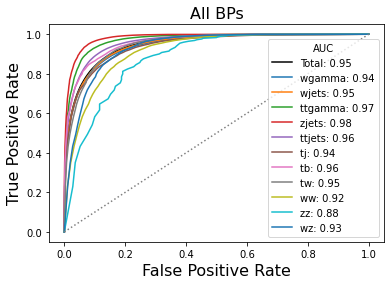

In [650]:
plt.plot(fpr_total, tpr_total, c = 'black', label = 'Total: {:.2f}'.format(auc(fpr_total, tpr_total)))

for i, ibkg in enumerate(bkg):
    plt.plot(fpr_bkg[i,:], tpr_bkg[i,:], label = ibkg + ': {:.2f}'.format(auc(fpr_bkg[i,:], tpr_bkg[i,:])))
plt.legend(title = 'AUC')

plt.ylabel("True Positive Rate",fontsize=16)
plt.xlabel("False Positive Rate",fontsize=16)
plt.plot([0,1],[0,1],ls=":",color="grey")
plt.title(r"All BPs",fontsize=16)
plt.savefig(f'../graph/ROC_MET100_BPI_{len(Z_BL_loops)}.pdf', bbox_inches='tight')

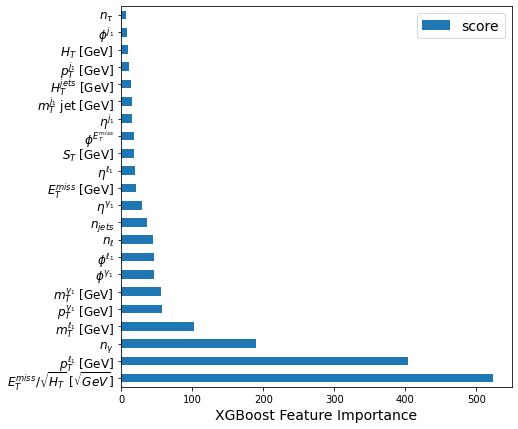

In [651]:
lst1 = ['$p_T^{\gamma_1}$ [GeV]', '$\eta^{\gamma_1}$', '$\phi^{\gamma_1}$', '$n_\gamma$',
       '$p_T^{j_1}$ [GeV]', '$\eta^{j_1}$', '$\phi^{j_1}$',
       '$p_T^{\ell_1}$ [GeV]', '$\eta^{\ell_1}$', '$\phi^{\ell_1}$', '$n_\ell$', '$n_{\\tau}$',
       '$E_T^{miss}$ [GeV]', '$\phi^{E_T^{miss}}$',
       '$H_T$ [GeV]', '$H_T^{jets}$ [GeV]', '$n_{jets}$',
       '$S_T$ [GeV]', 
       '$E_T^{miss}/\sqrt{H_T}$ [$\sqrt{GeV}$]',
       '$m_T^{\gamma_1}$ [GeV]', '$m_T^{j_{1}}$ jet [GeV]', '$m_T^{\ell_1}$ [GeV]',
       'SM=0 - NP=1']

fig, ax = plt.subplots(figsize = (7,7))

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(len(lst) - 1, columns="score").plot(kind='barh', ax = ax) ## plot top 20 features

ax.set_xlabel("XGBoost Feature Importance", fontsize = 14)
ax.set_yticklabels(np.asarray(lst1)[np.argsort(values)[::-1]], fontsize = 12)

ax.legend(fontsize = 14)

plt.savefig(f'../graph/ImpVars_MET100_BPI_{len(Z_BL_loops)}.pdf', bbox_inches='tight')

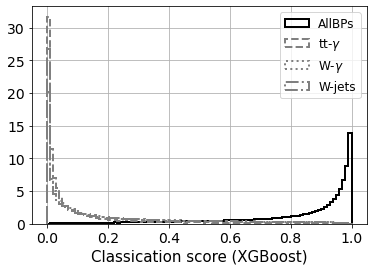

In [652]:
plt.hist(y_pred_xg[np.where(bkg_flag_test == 0)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'black', label = 'AllBPs', lw = 2)
plt.hist(y_pred_xg[np.where(bkg_flag_test == 3)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 1)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 2)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
#plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.savefig(f'../graph/MLOutput_dist_MET100_BPI_{len(Z_BL_loops)}.pdf', bbox_inches="tight")

In [653]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [654]:
len(np.where(bkg_flag_test != 0)[0])

439041

In [655]:
len(np.where(bkg_flag_test == 0)[0])

527118

## Sequential selection criteria

In [186]:
nbins = 10
indices_aux = np.arange(len(df_test_array))

n_np0 = []
for bp in np.arange(8):
    n_np0.append( len(np.where(df_test_array[:, 24] == (bp+1))[0]) )
    
n_wgamma0  = len(np.where(df_test_array[:, 22] == 1)[0])
n_wjets0   = len(np.where(df_test_array[:, 22] == 2)[0])
n_ttgamma0 = len(np.where(df_test_array[:, 22] == 3)[0])
n_ttjets0  = len(np.where(df_test_array[:, 22] == 4)[0])
n_zjets0   = len(np.where(df_test_array[:, 22] == 5)[0])
n_wz0      = len(np.where(df_test_array[:, 22] == 6)[0])
n_zz0      = len(np.where(df_test_array[:, 22] == 7)[0])
n_ww0      = len(np.where(df_test_array[:, 22] == 8)[0])
n_tj0      = len(np.where(df_test_array[:, 22] == 9)[0])
n_tb0      = len(np.where(df_test_array[:, 22] == 10)[0])
n_tw0      = len(np.where(df_test_array[:, 22] == 11)[0])

sup_cuts = {}
inf_cuts = {}
random_vars = np.random.choice(range(len(df_test.columns) - 3), size = 100, replace = True)
random_vars = np.concatenate((np.random.choice(range(len(df_test.columns) - 3), size = len(df_test.columns) - 3, replace = False), random_vars))

for ivar in random_vars:
    #print(indices_aux)
    cuts = np.linspace(np.min(df_test_array[indices_aux,ivar]), np.max(df_test_array[indices_aux,ivar]), nbins)
    ZN_sup = np.zeros(nbins)
    ZN_inf = np.zeros(nbins)

    indices = []
    Z = []
    for icut, cut in enumerate(cuts): 
        
        # Superior ------------------------------------------------------------------------------------
        indices_sup = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cut) )[0]]
        indices.append(indices_sup)
        
        n_wgamma  = len(np.where(df_test_array[indices_sup, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_sup, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_sup, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_sup, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_sup, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_sup, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_sup, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_sup, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_sup, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_sup, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_sup, 22] == 11)[0])
        
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        wgamma_expected  = wgamma_cross * wgamma_NLO * luminosidad * (n_wgamma * wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = wjets_cross * wjets_NLO * luminosidad * (n_wjets * wjets_aceptancia_init / n_wjets0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)
        
        S_expected_aux = np.zeros(8)
        for bp in np.arange(8):
            n_np = len(np.where( (df_test_array[indices_sup, 24] == (bp+1)) )[0])
            S_expected_aux[bp] = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0[bp]))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        #if B_expected > 5: Z_sup[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and ( np.min(S_expected_aux) > 5):
            Z_norm = np.zeros(8)
            for bp in np.arange(8):
                Z_norm[bp] = np.sqrt(2 * ((B_expected_aux + S_expected_aux[bp]) * np.log(1 + S_expected_aux[bp] / B_expected_aux) - S_expected_aux[bp]))
                Z_norm[bp] = Z_norm[bp] / S_expected[bp]
            ZN_sup[icut] = np.mean(Z_norm)
            Z.append( ZN_sup[icut] )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------

        # Inferior ------------------------------------------------------------------------------------
        indices_inf = indices_aux[np.where( (df_test_array[indices_aux,ivar] <= cut) )[0]]
        indices.append(indices_inf)
        
        n_np      = len(np.where(df_test_array[indices_inf, 22] == 0)[0])
        
        n_wgamma  = len(np.where(df_test_array[indices_inf, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_inf, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_inf, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_inf, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_inf, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_inf, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_inf, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_inf, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_inf, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_inf, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_inf, 22] == 11)[0])
        
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        wgamma_expected  = wgamma_cross * wgamma_NLO * luminosidad * (n_wgamma * wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = wjets_cross * wjets_NLO * luminosidad * (n_wjets * wjets_aceptancia_init / n_wjets0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)
        
        S_expected_aux = np.zeros(8)
        for bp in np.arange(8):
            n_np = len(np.where( (df_test_array[indices_inf, 24] == (bp+1)) )[0])
            S_expected_aux[bp] = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0[bp]))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        #if B_expected > 5: Z_inf[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (np.min(S_expected_aux) > 5):
            Z_norm = np.zeros(8)
            for bp in np.arange(8):
                Z_norm[bp] = np.sqrt(2 * ((B_expected_aux + S_expected_aux[bp]) * np.log(1 + S_expected_aux[bp] / B_expected_aux) - S_expected_aux[bp]))
                Z_norm[bp] = Z_norm[bp] / S_expected[bp]
            ZN_inf[icut] = np.mean(Z_norm)
            Z.append( ZN_inf[icut] )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------
    max_cut     = np.argmax(np.asarray(Z))
    indices_aux = indices[max_cut]
    max_cut     = np.argmax((ZN_inf, ZN_sup))
    if max_cut >= len(ZN_inf):
        print(df_test.columns[ivar] + ' >= ' + str(cuts[max_cut - len(ZN_sup)]) + '; <Z Norm> = ' + str(ZN_sup[max_cut - len(ZN_inf)]))
        if df.columns[ivar] in inf_cuts.keys():
            inf_cuts[df_test.columns[ivar]] = cuts[max_cut - len(ZN_sup)]
        inf_cuts.setdefault(df_test.columns[ivar], cuts[max_cut - len(ZN_sup)])
        sup_cuts.setdefault(df_test.columns[ivar], 999999)
    else:
        print(df_test.columns[ivar] + ' <= ' + str(cuts[max_cut]) + '; <Z Norm> = ' + str(ZN_inf[max_cut]))
        if df.columns[ivar] in sup_cuts.keys():
            sup_cuts[df_test.columns[ivar]] = cuts[max_cut]
        sup_cuts.setdefault(df_test.columns[ivar], cuts[max_cut])
        inf_cuts.setdefault(df_test.columns[ivar], -999999)   
    
    

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
wgamma_expected  = wgamma_cross * wgamma_NLO * luminosidad * (n_wgamma * wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = wjets_cross * wjets_NLO * luminosidad * (n_wjets * wjets_aceptancia_init / n_wjets0)
ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

S_expected_aux = np.zeros(8)
for bp in np.arange(8):
    n_np = len(np.where( (df_test_array[indices_inf, 24] == (bp+1)) )[0])
    S_expected_aux[bp] = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0[bp]))
    
# Formula discovery
B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                     zjets_expected + wz_expected + zz_expected + ww_expected + \
                     tj_expected + tb_expected + tw_expected)
if (B_expected_aux > 5) and (np.min(S_expected_aux) > 5): 
    for bp in np.arange(8):
        print('\n')
        print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux[bp]) * np.log(1 + S_expected_aux[bp] / B_expected_aux) - S_expected_aux[bp])))
        print('Expected Background = ' + str(B_expected_aux))
        print('Expected Signal = ' + str(S_expected_aux[bp]))

MET sig [GeV] >= 12.841278563780092; <Z Norm> = 0.0038650044381625523
num_taus <= 1.1111111111111112; <Z Norm> = 0.0038650044381625523
MET $\phi$ <= 3.142; <Z Norm> = 0.0038650044381625523
photon $\eta$ >= -1.8425555555555557; <Z Norm> = 0.0038785823253272432
num_jets <= 7.666666666666667; <Z Norm> = 0.0038825157812826666
jet $\eta$ <= 3.4717777777777776; <Z Norm> = 0.0038827972005563674
lepton $\phi$ <= 3.142; <Z Norm> = 0.0038827972005563674
num photon <= 2.0; <Z Norm> = 0.0038827972005563674
$S_T$ [GeV] <= 1468.09; <Z Norm> = 0.0038909185425014445
num lepton <= 2.2222222222222223; <Z Norm> = 0.0038917707483813553
lepton $p_T$ [GeV] <= 94.03333333333333; <Z Norm> = 0.004223654072117798
jet $p_T$ [GeV] <= 1271.832222222222; <Z Norm> = 0.004224389998743378
$H_T$ (jets) [GeV] <= 1808.2766666666666; <Z Norm> = 0.004224389998743378
lepton $\eta$ <= 2.498; <Z Norm> = 0.004224389998743378
$m_T$ lepton [GeV] <= 375.92592391967935; <Z Norm> = 0.004225863006838271
$H_T$ [GeV] <= 2153.586666666

In [187]:
write = True
if write:
    with open(f'../data/cuts/MET100_BPI_supCuts_{len(Z_BL_loops)}.txt', "w") as fp:
        json.dump(sup_cuts, fp)

    with open(f'../data/cuts/MET100_BPI_infCuts_{len(Z_BL_loops)}.txt', "w") as fp:
        json.dump(inf_cuts, fp)
else:
    with open(f'../data/cuts/MET100_BPI_supCuts_{len(Z_BL_loops)}.txt', "r") as fp:
        # Load the dictionary from the file
        sup_cuts = json.load(fp)
    with open(f'../data/cuts/MET100_BPI_infCuts_{len(Z_BL_loops)}.txt', "r") as fp:
        # Load the dictionary from the file
        inf_cuts = json.load(fp)

100%|██████████████████████████████| 2000/2000 [00:18<00:00, 106.38it/s]


Final results: for BP 1
 
Z = 2.228334926623205; Z_std = 0.204918849298954
B_exp = 2904.717; B_exp_std = 43.56825577183461
S_exp = 121.041; S_exp_std = 11.061343453667822


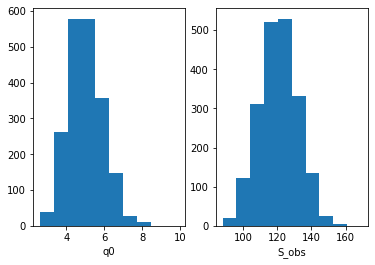

100%|██████████████████████████████| 2000/2000 [00:18<00:00, 109.69it/s]

Final results: for BP 2
 
Z = 1.1160147996798084; Z_std = 0.14484415014864416
B_exp = 2905.2375; B_exp_std = 44.023074560393894
S_exp = 60.843; S_exp_std = 7.677652701184132


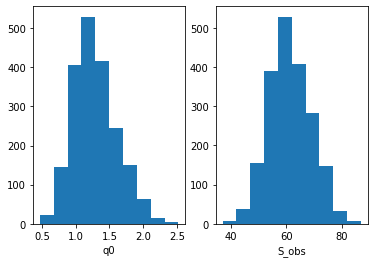

100%|███████████████████████████████| 2000/2000 [00:31<00:00, 64.16it/s]


Final results: for BP 3
 
Z = 0.40492765662102964; Z_std = 0.08880127544406036
B_exp = 2903.1725; B_exp_std = 44.260058108298956
S_exp = 21.785; S_exp_std = 4.657765021982109


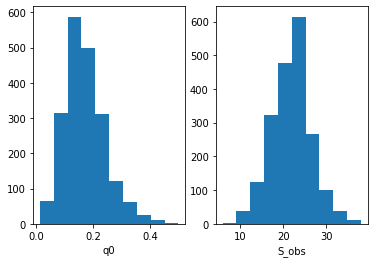

100%|███████████████████████████████| 2000/2000 [00:34<00:00, 58.42it/s]


Final results: for BP 4
 
Z = 1.1437563076031312; Z_std = 0.14668958296574935
B_exp = 2901.6045; B_exp_std = 43.07172018563921
S_exp = 62.137; S_exp_std = 7.836085183304226


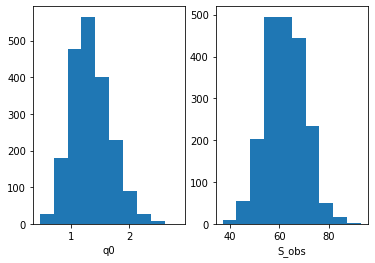

100%|███████████████████████████████| 2000/2000 [00:43<00:00, 46.16it/s]


Final results: for BP 5
 
Z = 0.3709331155822313; Z_std = 0.08789010994808036
B_exp = 2904.4585; B_exp_std = 43.153415597725285
S_exp = 20.1995; S_exp_std = 4.5180415834739724


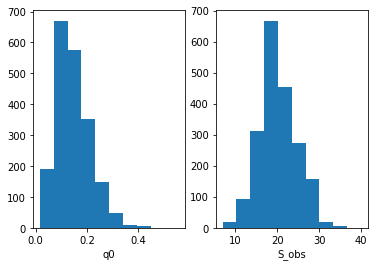

100%|██████████████████████████████| 2000/2000 [00:18<00:00, 109.95it/s]


Final results: for BP 6
 
Z = 0.8282417810300885; Z_std = 0.12510647984135184
B_exp = 2901.4165; B_exp_std = 44.17688340919943
S_exp = 44.732; S_exp_std = 6.699490726913502


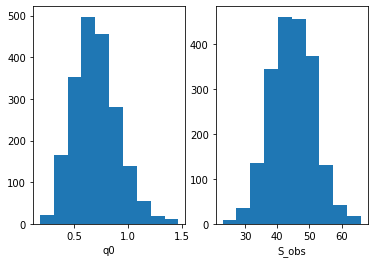

100%|██████████████████████████████| 2000/2000 [00:18<00:00, 110.66it/s]


Final results: for BP 7
 
Z = 0.20329750155216808; Z_std = 0.06492603334729229
B_exp = 2903.3095; B_exp_std = 44.525966690797404
S_exp = 10.9325; S_exp_std = 3.2974147070091138


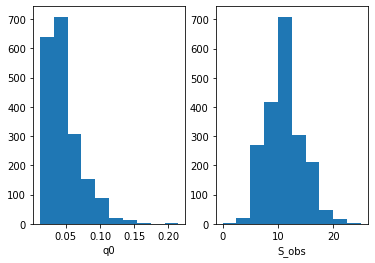

100%|██████████████████████████████| 2000/2000 [00:18<00:00, 110.13it/s]


Final results: for BP 8
 
Z = 0.4988477788354525; Z_std = 0.0968299600285335
B_exp = 2903.5755; B_exp_std = 43.59543897875098
S_exp = 26.9135; S_exp_std = 5.108132511006346


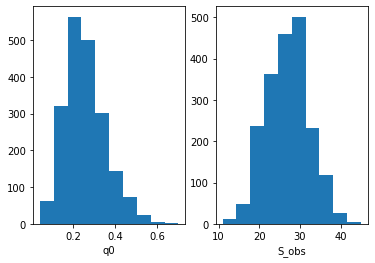

In [188]:
nexperiments = 2000

SM_test_pool = np.where(df_test_array[:,22] > 0)[0]

Z_sbc_std_BPs = np.ones(8) * (-99)
Z_sbc_BPs = np.ones(8) * (-99)
for bp in np.arange(8):
    
    NP_test_pool = np.where(df_test_array[:,24] == (bp+1))[0]

    q0_exp = np.zeros(nexperiments)
    B_observed_exp = np.zeros(nexperiments)
    S_observed_exp = np.zeros(nexperiments)
    for nexp in tqdm(range(nexperiments)):
        # Let's create a pseudo-experiment
        SM_indices = np.random.choice(SM_test_pool, size = np.random.poisson(int(B_expected)), replace = False)
        NP_indices = np.random.choice(NP_test_pool, size = np.random.poisson(int(S_expected[bp])), replace = False)
        indices_aux = np.concatenate((NP_indices, SM_indices))

        # Let's make the cuts

        variables = list(sup_cuts.keys())
        for i in range(len(variables)):
            ind_var = np.where(df_test.columns == variables[i])[0][0]
            indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                                    (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                                   )[0]]
        # Let's calculate everything

        n_np = len(np.where(df_test_array[indices_aux, 24] == (bp+1))[0])

        n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

        S_observed_exp[nexp] = n_np

        # Formula discovery
        B_observed_exp[nexp] = n_ttgamma + n_wgamma + n_wjets + \
                               n_ttjets + n_zjets + n_wz + \
                               n_zz + n_ww + n_tj + \
                               n_tb + n_tw

        N_observed = n_np + n_ttgamma + n_wgamma + n_wjets+ \
                     n_ttjets + n_zjets + n_wz + \
                     n_zz + n_ww + n_tj + \
                     n_tb + n_tw
        
        if (B_observed_exp[nexp] >= 5) and (n_np > 5): 
            q0_exp[nexp] = -2 * N_observed * np.log(B_observed_exp[nexp] / N_observed) -2 * (N_observed - B_observed_exp[nexp])
        else:
            q0_exp[nexp] = -99
            
    q0_exp = q0_exp[np.where(q0_exp > 0)[0]]
    Z_sbc_BPs[bp] = np.sqrt(np.median(q0_exp))
    Z_sbc_std_BPs[bp] = np.std(q0_exp) / (2 * np.sqrt(np.median(q0_exp)))
    print('Final results: for BP ' + str(bp+1) + '\n ')
    print('Z = ' + str(np.sqrt(np.median(q0_exp))) + '; Z_std = ' + str(np.std(q0_exp) / (2 * np.sqrt(np.median(q0_exp)))))
    print('B_exp = ' + str(np.mean(B_observed_exp)) + '; B_exp_std = ' + str(np.std(B_observed_exp)))
    print('S_exp = ' + str(np.mean(S_observed_exp)) + '; S_exp_std = ' + str(np.std(S_observed_exp)))
    fig,ax = plt.subplots(1,2)
    
    ax[0].hist(q0_exp)
    ax[0].set_xlabel('q0')
    ax[1].hist(S_observed_exp)
    ax[1].set_xlabel('S_obs')
    plt.show()

In [125]:
imp_vars = np.asarray(lst)[np.argsort(values)[::-1]][:4]
print(imp_vars)

['MET sig [GeV]' 'lepton $p_T$ [GeV]' 'num photon' '$m_T$ lepton [GeV]']


In [140]:
name_imp_vars = np.asarray(lst1)[np.argsort(values)[::-1]][:4]
print(name_imp_vars)

['$p_T^{\\ell_1}$ [GeV]' '$E_T^{miss}/\\sqrt{H_T}$ [$\\sqrt{GeV}$]'
 '$n_\\gamma$' '$m_T^{\\ell_1}$ [GeV]']


In [144]:
np.argsort(values)[::-1][:4]

array([ 7, 18,  3, 21])

In [148]:
np.min( [np.min(SM[imp_vars[0]]),np.min(NP[imp_vars[0]])])

10.01

In [138]:
NP_cmap = create_cyan_to_black_cmap('black', mcolors.to_rgb('white'), cmap_name = 'NP_cmap')

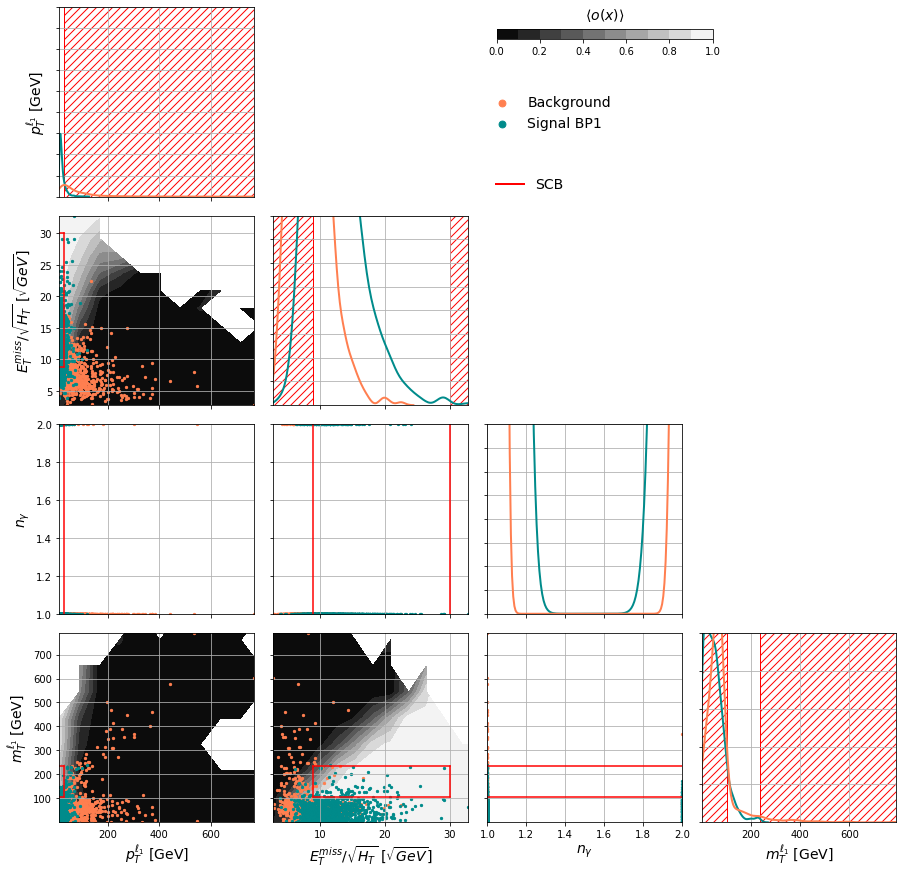

In [151]:
SM = df_test.loc[df_test['bkg_flag_pool'] != 0]
NP = df_test.loc[df_test['bp_flag'] == 1]

pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

rand_ind = np.random.choice(range(len(NP)), size =  1000, replace = False)
NP = NP.iloc[rand_ind]
pred_XG_NP = pred_XG_NP[rand_ind]

rand_ind = np.random.choice(range(len(SM)), size =  1000, replace = False)
SM = SM.iloc[rand_ind]
pred_XG_SM = pred_XG_SM[rand_ind]

#limites = [[4,35], [0,250], [0,5], [0,500]]
limites = [[np.min( [np.min(SM[imp_vars[0]]),np.min(NP[imp_vars[0]])]), np.max( [np.max(SM[imp_vars[0]]),np.max(NP[imp_vars[0]])])],
           [np.min( [np.min(SM[imp_vars[1]]),np.min(NP[imp_vars[1]])]), np.max( [np.max(SM[imp_vars[1]]),np.max(NP[imp_vars[1]])])],
           [np.min( [np.min(SM[imp_vars[2]]),np.min(NP[imp_vars[2]])]), np.max( [np.max(SM[imp_vars[2]]),np.max(NP[imp_vars[2]])])],
           [np.min( [np.min(SM[imp_vars[3]]),np.min(NP[imp_vars[3]])]), np.max( [np.max(SM[imp_vars[3]]),np.max(NP[imp_vars[3]])])]
            ]
ylimites = [[0,0.18], [0,0.04], [0,0.02], [0,0.01]]

rand_ind = np.random.choice(range(len(df_test)), size =  len(df_test), replace = False)
aux = df_test.iloc[rand_ind]
y_pred_aux = y_pred_xg[rand_ind]

with open(f'../data/cuts/MET100_BPI_supCuts_{len(Z_BL_loops)}.txt', "r") as fp:
    # Load the dictionary from the file
    sup_cuts = json.load(fp)
with open(f'../data/cuts/MET100_BPI_infCuts_{len(Z_BL_loops)}.txt', "r") as fp:
    # Load the dictionary from the file
    inf_cuts = json.load(fp)
        
fig,ax = plt.subplots(4,4, figsize = (15,15), gridspec_kw={'hspace':0.1, 'wspace':0.1})

for i in range(4):
    for j in range(4):
        if i != 3: ax[i,j].set_xticklabels([])
        if j != 0: ax[i,j].set_yticklabels([])
        if i >= j:
            if i==j:
                sns.kdeplot(NP[imp_vars[i]], ax = ax[i,j], color = 'darkcyan', lw=2, ls = 'solid')
                sns.kdeplot(SM[imp_vars[i]], ax = ax[i,j], color = 'coral', lw=2, ls = 'solid')
                ax[i,j].set_ylabel('')
                ax[i,j].set_xlabel('')
                ax[i,j].set_xlim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = sup_cuts[imp_vars[i]], x2 = 1000, facecolor = 'none', edgecolor = 'red', zorder = 0, hatch = '///')
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = -1, x2 = inf_cuts[imp_vars[i]], facecolor = 'none', edgecolor = 'red', zorder = 0, hatch = '///')
                ax[i,j].set_ylim(ylimites[i])
            else:
                stats, xedge, yedge, _ = binned_statistic_2d(aux[imp_vars[j]], aux[imp_vars[i]], y_pred_aux, bins = 22)
                im_NP = ax[i,j].contourf(xedge[:-1], yedge[:-1], stats.T, cmap=NP_cmap, zorder = 0, levels = np.linspace(0,1,11))
                ax[i,j].scatter(SM[imp_vars[j]], SM[imp_vars[i]], s = 20.8, marker = '.', 
                                        c = 'coral', rasterized=True, label = 'Background')
                ax[i,j].scatter(NP[imp_vars[j]], NP[imp_vars[i]], s = 20.8, marker = '.', 
                                        c = 'darkcyan', rasterized=True, label = 'Signal BP1')
                ax[i,j].set_xlim(SM[imp_vars[j]].min(), SM[imp_vars[j]].max())
                ax[i,j].set_ylim(SM[imp_vars[i]].min(), SM[imp_vars[i]].max())
                ax[i,j].set_xlim(limites[j])
                ax[i,j].set_ylim(limites[i])
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], inf_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[sup_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], inf_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([sup_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')

                
            ax[i,j].grid(which = 'both')
        else:
            ax[i,j].axis('off')

ax[3,0].set_xlabel(name_imp_vars[0], fontsize = 14)
ax[3,1].set_xlabel(name_imp_vars[1], fontsize = 14)
ax[3,2].set_xlabel(name_imp_vars[2], fontsize = 14)
ax[3,3].set_xlabel(name_imp_vars[3], fontsize = 14)

ax[0,0].set_ylabel(name_imp_vars[0], fontsize = 14)
ax[1,0].set_ylabel(name_imp_vars[1], fontsize = 14)
ax[2,0].set_ylabel(name_imp_vars[2], fontsize = 14)
ax[3,0].set_ylabel(name_imp_vars[3], fontsize = 14)

ax[0,0].set_xticklabels([])

ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])

ax[2,2].set_yticklabels([])
ax[2,2].set_xticklabels([])

ax[3,3].set_yticklabels([])
ax[0,0].set_yticklabels([])



# Legends------------------------------------------

ax[1,0].legend(loc = 'upper right', bbox_to_anchor=(2.9, 1.7), fontsize = 14, frameon = False, markerscale=3)

cax = fig.add_axes([0.53, 0.85, 0.2, 0.01])
cbar_NP = plt.colorbar(im_NP, cax=cax, orientation = 'horizontal')
cbar_NP.set_label(r'$\langle o(x) \rangle$', labelpad=-50, fontsize = 14)

patch1 = mlines.Line2D([], [], color='red', label='SCB', linestyle='-', markerfacecolor='none', markeredgewidth=2, lw = 2)
patch2 = mlines.Line2D([], [], color='red', label='BP 1', linestyle='-.', markerfacecolor='none', markeredgewidth=2, lw = 2)

# Add custom legend with boxes
ax[0,0].legend(handles=[patch1], loc = 'lower left', bbox_to_anchor=(2.18, -0.04), fontsize = 14, frameon = False )

plt.savefig(f'../graph/MET100_BPI_ImpVars_dist_{len(Z_BL_loops)}.pdf', bbox_inches='tight')

## Binned likelihood

In [656]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [657]:
print(pred_XG_SM.shape)
print(pred_XG_NP.shape)

(439041,)
(527118,)


In [658]:
B_expected = int(B_expected)

B_expected:  147986

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


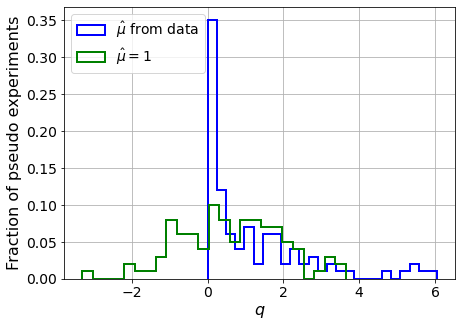

BP1_1

S_expected:  108
muhat mean:  0.9790000000000002
Z_bins:  0.752815612215827
std Z_bins:  0.9663181072519648
Z_bins mu=1:  0.7505082557394549
std Z_bins mu=1:  0.8914634794285217

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


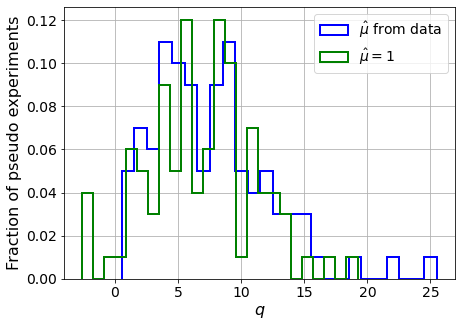

BP1_2

S_expected:  271
muhat mean:  1.0670000000000002
Z_bins:  2.6256725769803166
std Z_bins:  0.868295544610093
Z_bins mu=1:  2.6235152860728297
std Z_bins mu=1:  0.8051680054830074

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


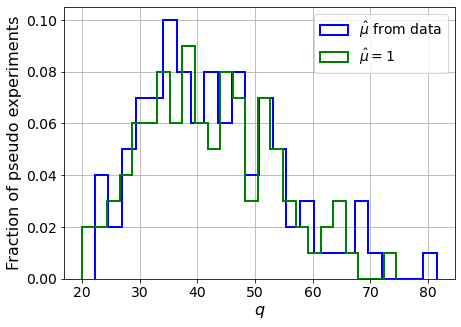

BP1_3

S_expected:  484
muhat mean:  1.0625000000000002
Z_bins:  6.445479664628139
std Z_bins:  0.9224520672899129
Z_bins mu=1:  6.442605898027983
std Z_bins mu=1:  0.8691705629600647

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


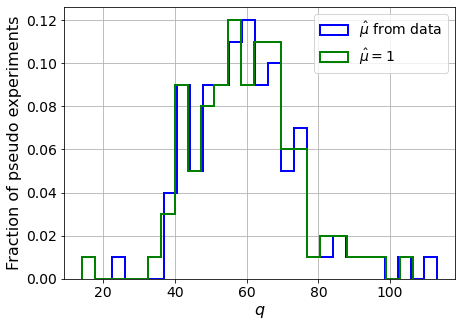

BP1_4

S_expected:  420
muhat mean:  1.0119999999999998
Z_bins:  7.705077188845764
std Z_bins:  0.9466154179525799
Z_bins mu=1:  7.705077188845764
std Z_bins mu=1:  0.9419680690007584

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


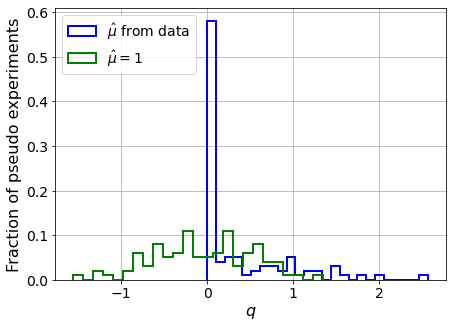

BP2_1

S_expected:  46
muhat mean:  0.8250000000000002
Z_bins:  0.11979016456337438
std Z_bins:  2.261642018576428
Z_bins mu=1:  0.17855106971495624
std Z_bins mu=1:  1.592007200561634

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


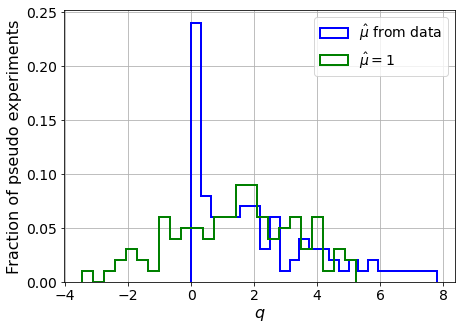

BP2_2

S_expected:  135
muhat mean:  1.0370000000000001
Z_bins:  1.2564258499464294
std Z_bins:  0.7913954939038181
Z_bins mu=1:  1.2523512802434882
std Z_bins mu=1:  0.7675361714419074

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


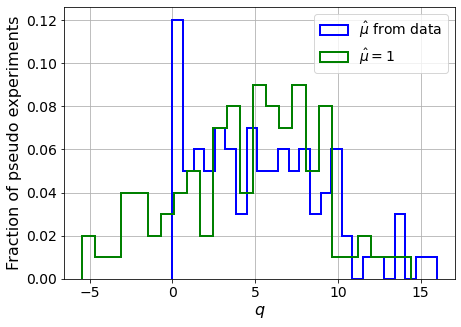

BP2_3

S_expected:  223
muhat mean:  0.9710000000000001
Z_bins:  2.252040046498817
std Z_bins:  0.8460023254856109
Z_bins mu=1:  2.2524696304785614
std Z_bins mu=1:  0.9445181769299343

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


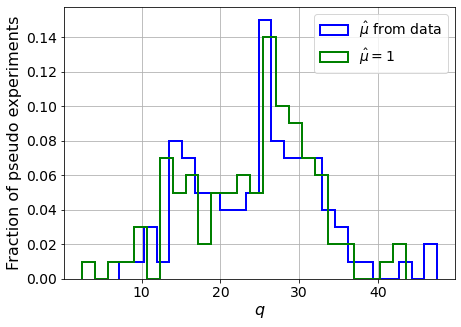

BP2_4

S_expected:  368
muhat mean:  1.0345
Z_bins:  5.08194637285987
std Z_bins:  0.7763858246792402
Z_bins mu=1:  5.077595447902398
std Z_bins mu=1:  0.7788087843163262

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


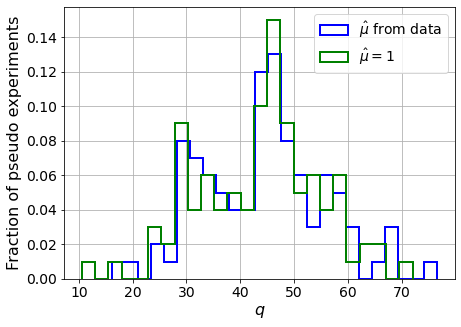

BP2_5

S_expected:  319
muhat mean:  1.0375
Z_bins:  6.711299223178953
std Z_bins:  0.8537499103628206
Z_bins mu=1:  6.709502144770107
std Z_bins mu=1:  0.8518477647405898

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


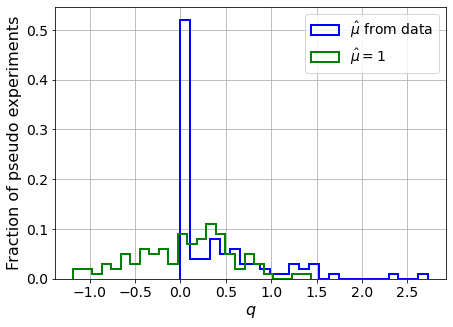

BP3_1

S_expected:  46
muhat mean:  0.9955000000000002
Z_bins:  0.2985793581985464
std Z_bins:  0.9049764486251678
Z_bins mu=1:  0.2948459716758805
std Z_bins mu=1:  0.8984879345496966

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


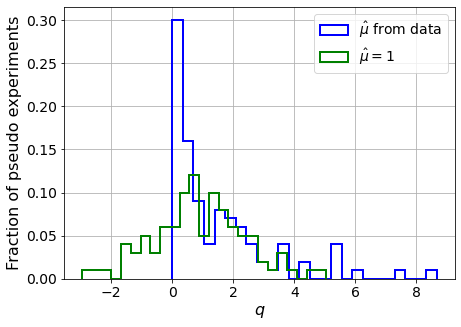

BP3_2

S_expected:  103
muhat mean:  1.0525000000000002
Z_bins:  0.9096258038733928
std Z_bins:  0.950071356158321
Z_bins mu=1:  0.9093112035541208
std Z_bins mu=1:  0.8122245019847646

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


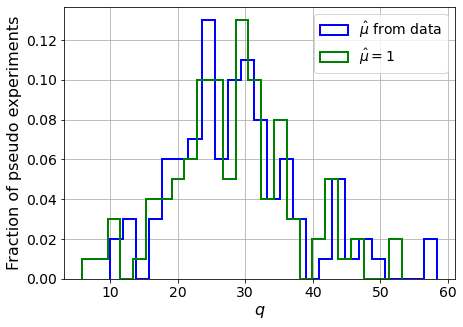

BP3_3

S_expected:  346
muhat mean:  1.0335
Z_bins:  5.335064643615186
std Z_bins:  0.8647658274207
Z_bins mu=1:  5.338283068515292
std Z_bins mu=1:  0.8407586008275707

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


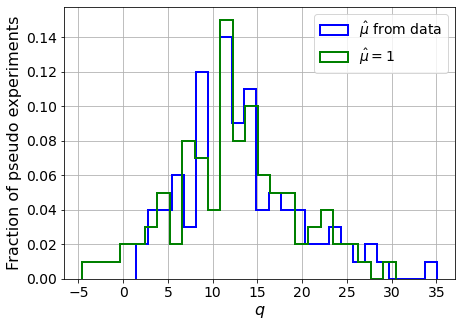

BP3_4

S_expected:  167
muhat mean:  0.9745
Z_bins:  3.4946996737996154
std Z_bins:  0.9313435113796097
Z_bins mu=1:  3.488336455204688
std Z_bins mu=1:  0.9628294726111937

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


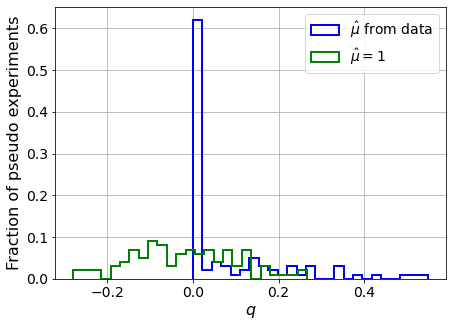

BP4_1

S_expected:  11
muhat mean:  0.8185000000000001
Z_bins:  0.0
std Z_bins:  inf
Z_bins mu=1:  0.15431594216347352
std Z_bins mu=1:  0.38725213778145007

--------



/home/martinrios/martin/trabajos/MLLHC/codes/AUX_MLL_BL.py:611: RuntimeWarning: divide by zero encountered in double_scalars
  Z_bins_std = np.std(q_muhat_bins) / (2.*Z_bins)


Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


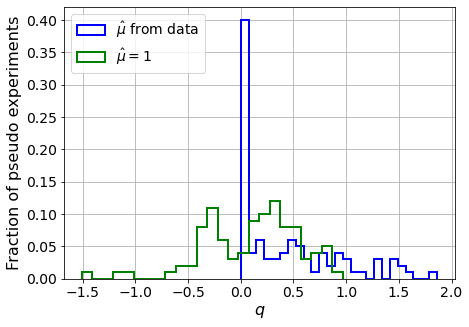

BP4_2

S_expected:  36
muhat mean:  1.1954999999999998
Z_bins:  0.47799543663300637
std Z_bins:  0.5080160457203644
Z_bins mu=1:  0.42910986324018546
std Z_bins mu=1:  0.5203070779366896

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


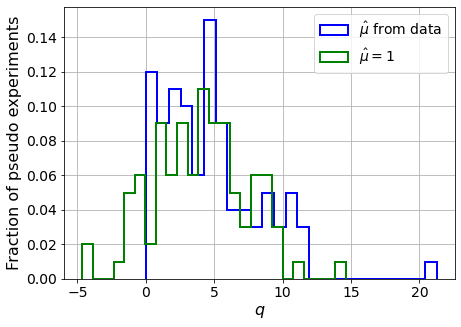

BP4_3

S_expected:  182
muhat mean:  1.0255
Z_bins:  2.0910869472846687
std Z_bins:  0.8495722873711096
Z_bins mu=1:  2.090304353028806
std Z_bins mu=1:  0.8206929389918041

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


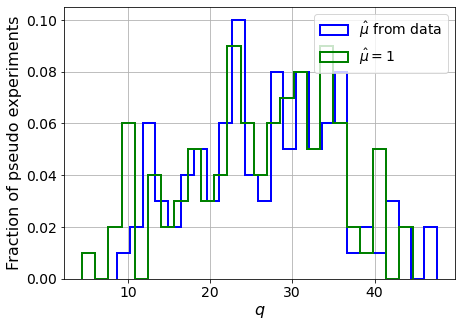

BP4_4

S_expected:  302
muhat mean:  1.0295
Z_bins:  5.254454347397646
std Z_bins:  0.8523001439246881
Z_bins mu=1:  5.252632732528716
std Z_bins mu=1:  0.8652881641959558

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


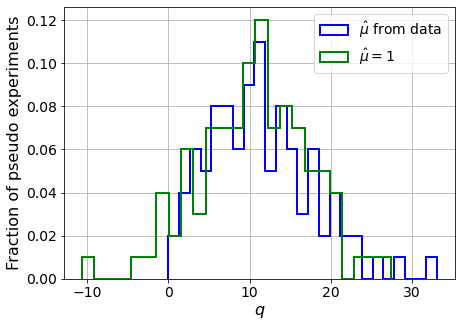

BP4_5

S_expected:  149
muhat mean:  0.9995000000000002
Z_bins:  3.3029886509189126
std Z_bins:  0.9623613504966487
Z_bins mu=1:  3.3029886509189126
std Z_bins mu=1:  0.9991680486168922

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


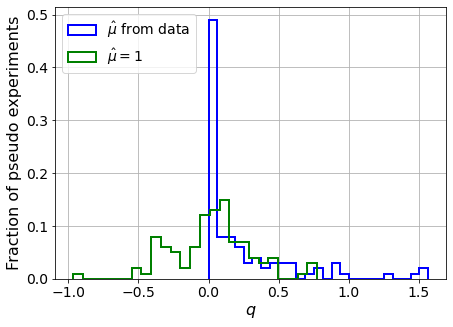

BP5_1

S_expected:  21
muhat mean:  1.1115000000000002
Z_bins:  0.2761059789174303
std Z_bins:  0.6420561189172623
Z_bins mu=1:  0.2491535931624347
std Z_bins mu=1:  0.5786527612232436

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


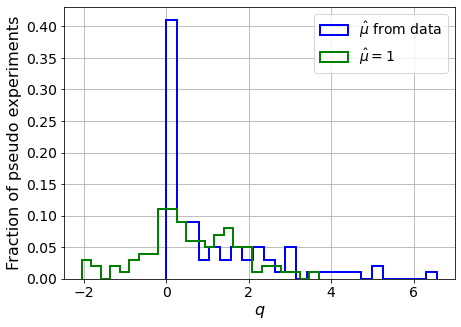

BP5_2

S_expected:  76
muhat mean:  1.0964999999999998
Z_bins:  0.7146915770143165
std Z_bins:  0.9743499313375359
Z_bins mu=1:  0.7146829441433905
std Z_bins mu=1:  0.7922324606070377

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


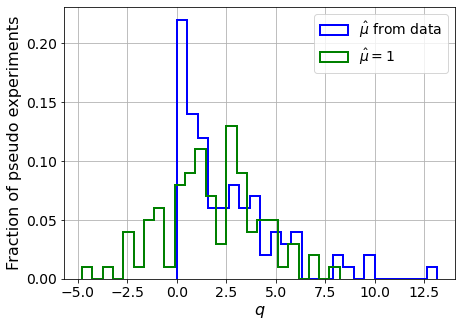

BP5_3

S_expected:  127
muhat mean:  1.0225
Z_bins:  1.3293728441391026
std Z_bins:  0.9556239782034246
Z_bins mu=1:  1.3304052393514576
std Z_bins mu=1:  0.8874172191989149

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


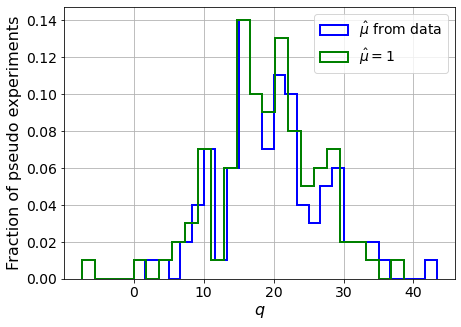

BP5_4

S_expected:  262
muhat mean:  1.0300000000000002
Z_bins:  4.373763313041757
std Z_bins:  0.8310484779380986
Z_bins mu=1:  4.376371640220933
std Z_bins mu=1:  0.8475971974533075

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


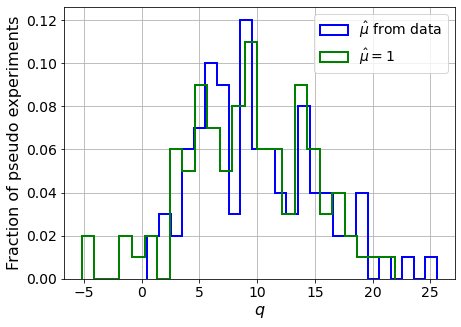

BP5_5

S_expected:  138
muhat mean:  0.997
Z_bins:  3.0277873843374565
std Z_bins:  0.846078679705634
Z_bins mu=1:  3.0277873843374565
std Z_bins mu=1:  0.875945635984015

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


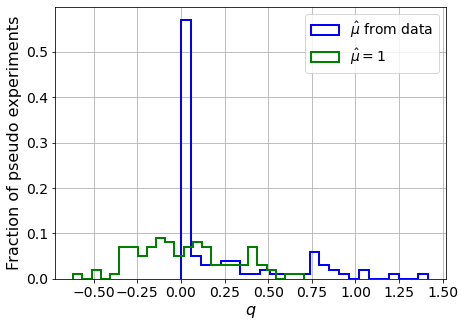

BP6_1

S_expected:  21
muhat mean:  0.936
Z_bins:  0.08268441897400981
std Z_bins:  2.0706902779744056
Z_bins mu=1:  0.03735386843784738
std Z_bins mu=1:  3.622140377548518

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


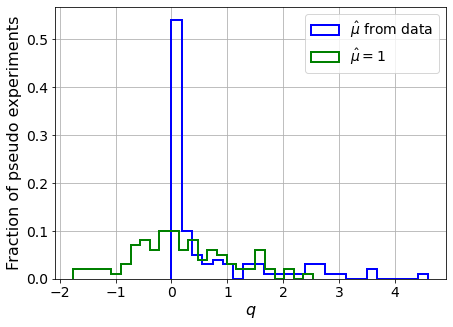

BP6_2

S_expected:  61
muhat mean:  0.8425000000000001
Z_bins:  0.3700720719533784
std Z_bins:  1.3544562704670549
Z_bins mu=1:  0.3346953741193546
std Z_bins mu=1:  1.3231357937080812

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


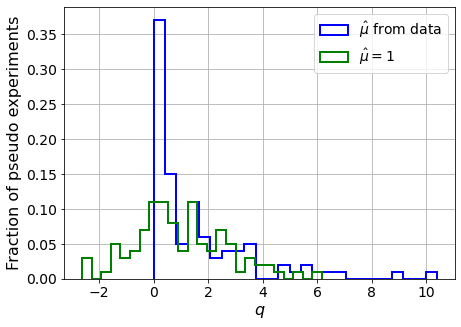

BP6_3

S_expected:  101
muhat mean:  0.9470000000000001
Z_bins:  0.8647963602525168
std Z_bins:  1.1511246878323904
Z_bins mu=1:  0.8494083011852723
std Z_bins mu=1:  0.9976442345447291

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


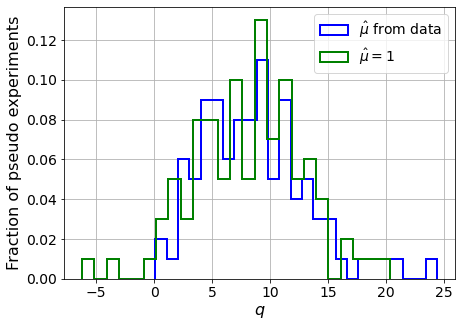

BP6_4

S_expected:  206
muhat mean:  1.0025
Z_bins:  2.9354449697292813
std Z_bins:  0.7695368584287813
Z_bins mu=1:  2.9369359044701047
std Z_bins mu=1:  0.786577633449856

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


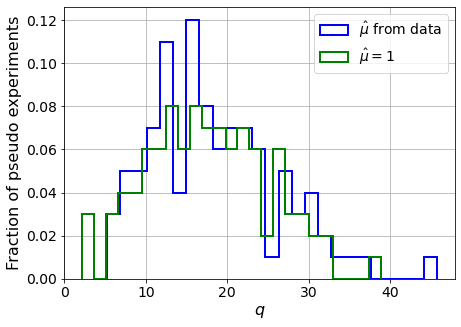

BP6_5

S_expected:  222
muhat mean:  1.0505
Z_bins:  4.177142119517409
std Z_bins:  0.933463092387512
Z_bins mu=1:  4.177644587098856
std Z_bins mu=1:  0.8872253813204384

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


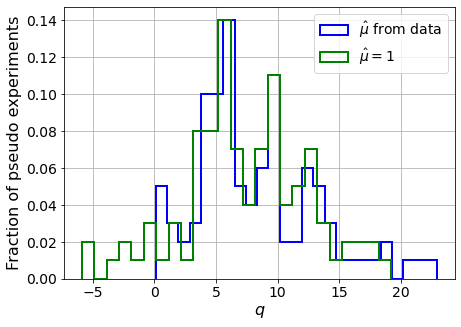

BP6_6

S_expected:  124
muhat mean:  0.9880000000000001
Z_bins:  2.642476659037315
std Z_bins:  0.9213551510779807
Z_bins mu=1:  2.6364809372290665
std Z_bins mu=1:  0.9594186894101684

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


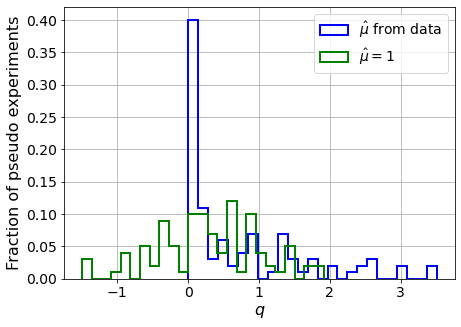

BP7_1

S_expected:  49
muhat mean:  1.108
Z_bins:  0.5143204855887241
std Z_bins:  0.8681063458939303
Z_bins mu=1:  0.5469196956311654
std Z_bins mu=1:  0.6674485708681037

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


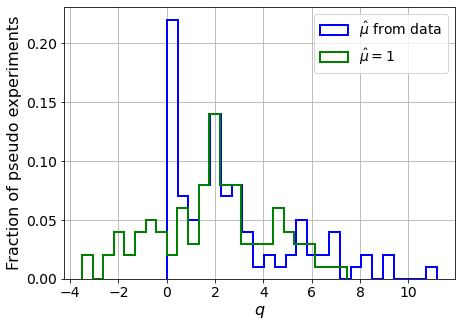

BP7_2

S_expected:  119
muhat mean:  1.036
Z_bins:  1.4243729116332906
std Z_bins:  0.8958195478239853
Z_bins mu=1:  1.423893765261961
std Z_bins mu=1:  0.8424554953986367

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


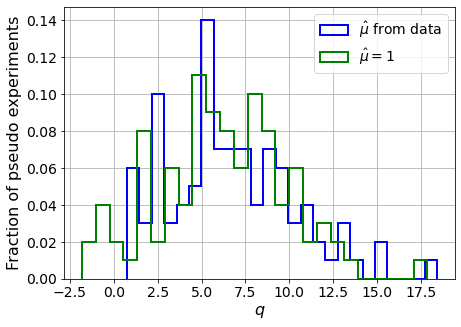

BP7_3

S_expected:  176
muhat mean:  1.0134999999999998
Z_bins:  2.471562227223758
std Z_bins:  0.7268061792687531
Z_bins mu=1:  2.471562227223758
std Z_bins mu=1:  0.7436645205386464

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


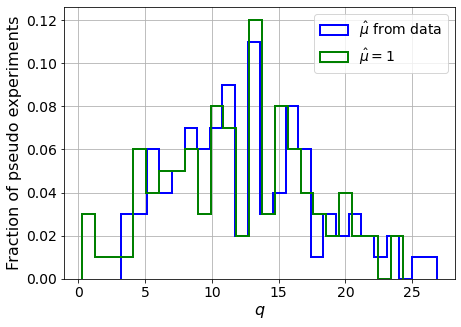

BP7_4

S_expected:  198
muhat mean:  0.995
Z_bins:  3.429639405143161
std Z_bins:  0.7733944752801372
Z_bins mu=1:  3.429639405143161
std Z_bins mu=1:  0.7900611892545009

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


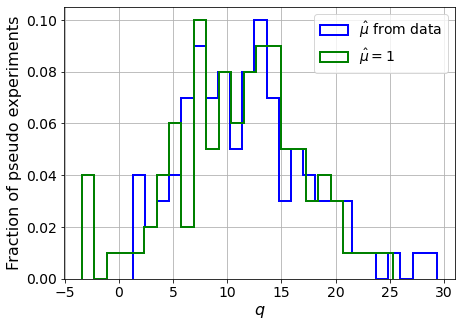

BP7_5

S_expected:  154
muhat mean:  1.0155
Z_bins:  3.391551803779441
std Z_bins:  0.847724703577662
Z_bins mu=1:  3.3935093928153583
std Z_bins mu=1:  0.8663712654549833

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


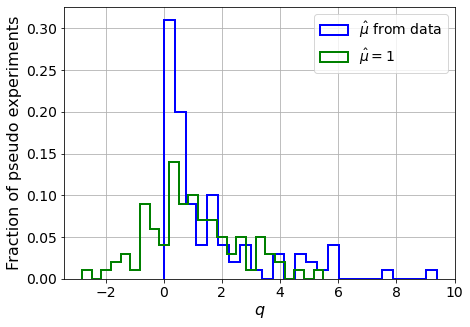

BP8_1

S_expected:  84
muhat mean:  1.016
Z_bins:  0.8396601091490222
std Z_bins:  1.1411359772480738
Z_bins mu=1:  0.9020465766486943
std Z_bins mu=1:  0.84943510785409

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


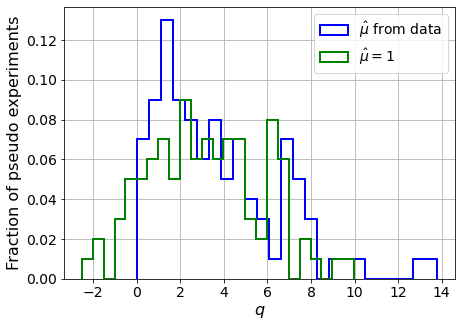

BP8_2

S_expected:  133
muhat mean:  1.0539999999999998
Z_bins:  1.74944788562316
std Z_bins:  0.8073079570591536
Z_bins mu=1:  1.750120895055381
std Z_bins mu=1:  0.7355333498847952

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


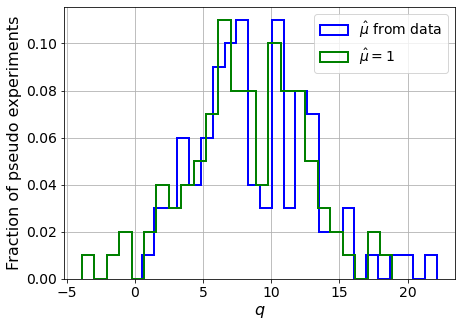

BP8_3

S_expected:  172
muhat mean:  1.0285000000000002
Z_bins:  2.8676641803084526
std Z_bins:  0.7389095771830982
Z_bins mu=1:  2.8695688527481447
std Z_bins mu=1:  0.7427444668882696

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


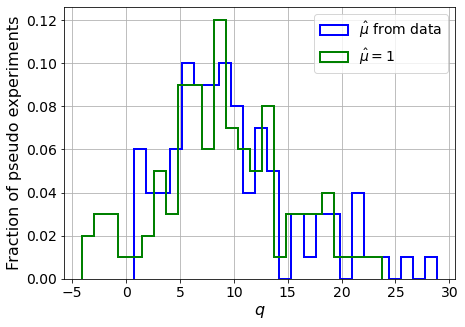

BP8_4

S_expected:  142
muhat mean:  1.0025000000000004
Z_bins:  2.969654439016459
std Z_bins:  1.0047992078960108
Z_bins mu=1:  2.969654439016459
std Z_bins mu=1:  0.9973528768789719

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.01


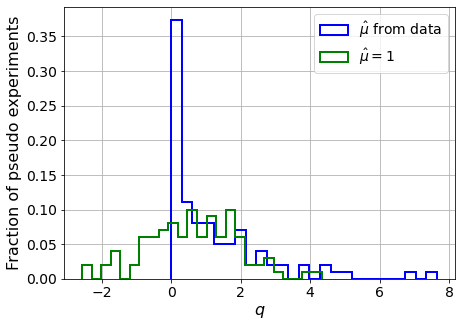

BP9_1

S_expected:  70
muhat mean:  1.0242424242424244
Z_bins:  0.8087812073094849
std Z_bins:  0.9266160101750309
Z_bins mu=1:  0.8290207140747053
std Z_bins mu=1:  0.7902748695018948

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


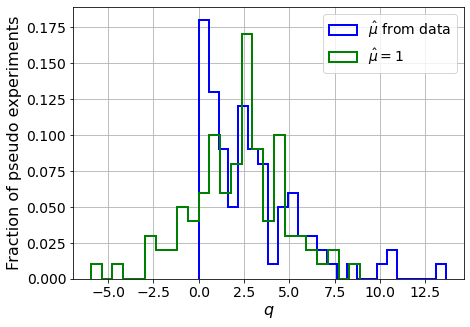

BP9_2

S_expected:  112
muhat mean:  1.031
Z_bins:  1.5540955933626361
std Z_bins:  0.8441408369036639
Z_bins mu=1:  1.5504467652593918
std Z_bins mu=1:  0.8208330039428088

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.01


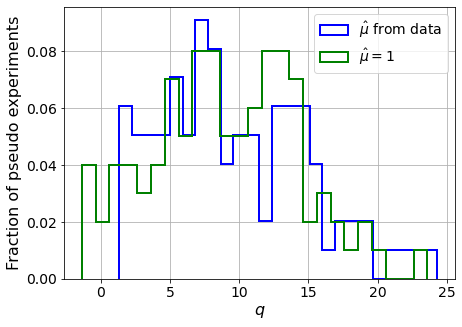

BP9_3

S_expected:  155
muhat mean:  1.0808080808080809
Z_bins:  2.940856354061168
std Z_bins:  0.9124688710646427
Z_bins mu=1:  2.9498343781706295
std Z_bins mu=1:  0.8930064012631677

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


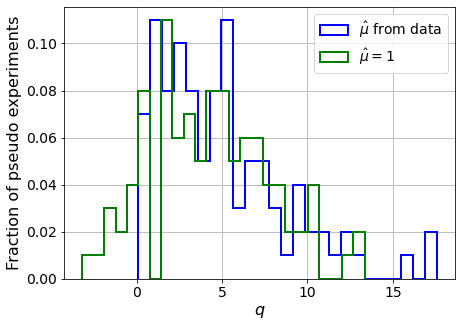

BP9_4

S_expected:  92
muhat mean:  1.0145
Z_bins:  2.085753882030749
std Z_bins:  0.9051184711955715
Z_bins mu=1:  2.085753882030749
std Z_bins mu=1:  0.848375469667441

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


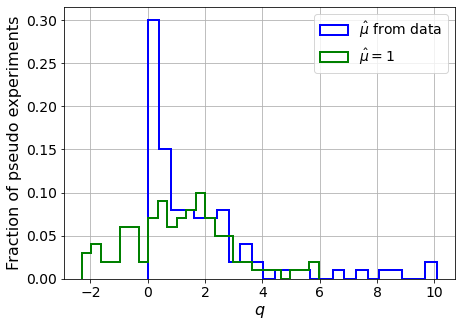

BP10_1

S_expected:  83
muhat mean:  1.012
Z_bins:  1.045864880974533
std Z_bins:  1.0219304158725961
Z_bins mu=1:  1.0517637429451947
std Z_bins mu=1:  0.8338394981012648

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


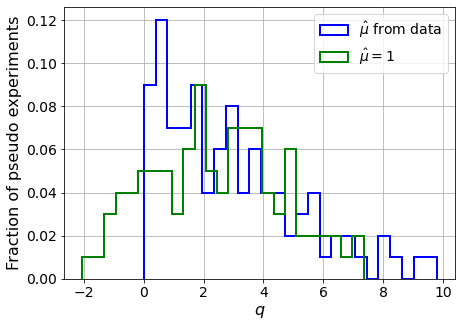

BP10_2

S_expected:  112
muhat mean:  1.0290000000000001
Z_bins:  1.5513437796281901
std Z_bins:  0.7334917125496152
Z_bins mu=1:  1.5519548534616057
std Z_bins mu=1:  0.6948648990596955

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


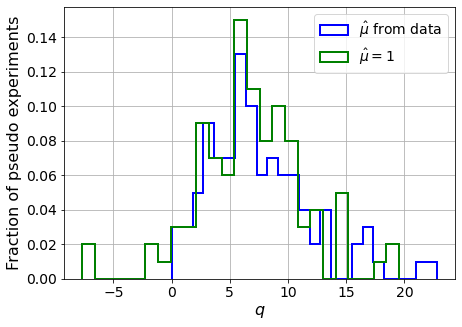

BP10_3

S_expected:  139
muhat mean:  1.02
Z_bins:  2.5870075374165262
std Z_bins:  0.8655795859345099
Z_bins mu=1:  2.589415512934827
std Z_bins mu=1:  0.8905427329912206

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


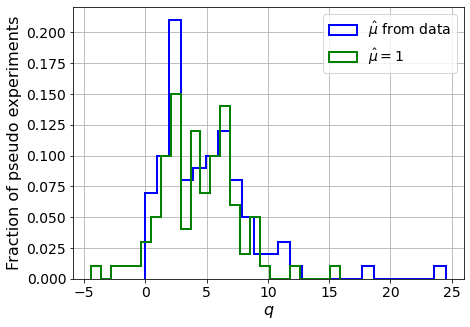

BP10_4

S_expected:  82
muhat mean:  1.1280000000000001
Z_bins:  2.0652211479610934
std Z_bins:  0.892335730982015
Z_bins mu=1:  2.05935123733925
std Z_bins mu=1:  0.7373562927167272

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


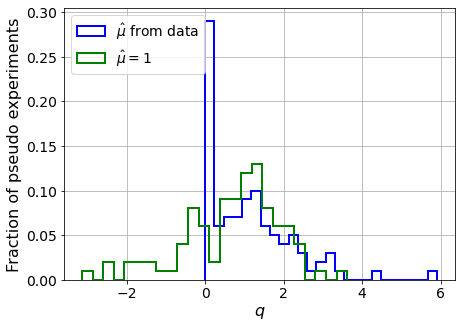

BP11_1

S_expected:  69
muhat mean:  1.0310000000000001
Z_bins:  1.0016174414860675
std Z_bins:  0.5431943726690807
Z_bins mu=1:  0.9898928030066056
std Z_bins mu=1:  0.6197781247458396

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


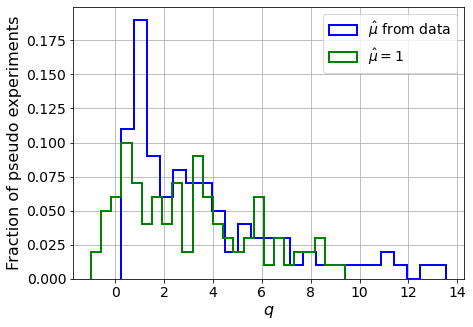

BP11_2

S_expected:  110
muhat mean:  1.0945000000000003
Z_bins:  1.6190023282770343
std Z_bins:  0.9735433095180827
Z_bins mu=1:  1.6204788056961483
std Z_bins mu=1:  0.7977544274470176

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


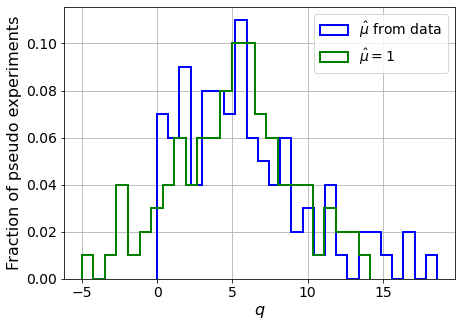

BP11_3

S_expected:  121
muhat mean:  1.0765
Z_bins:  2.2933835301646663
std Z_bins:  0.8989848665451419
Z_bins mu=1:  2.290565077307353
std Z_bins mu=1:  0.8492321494436506

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


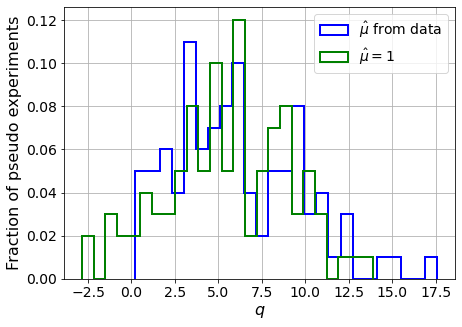

BP11_4

S_expected:  103
muhat mean:  1.0645
Z_bins:  2.311782744114757
std Z_bins:  0.7754475882274924
Z_bins mu=1:  2.312019050592849
std Z_bins mu=1:  0.7498399957256001

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


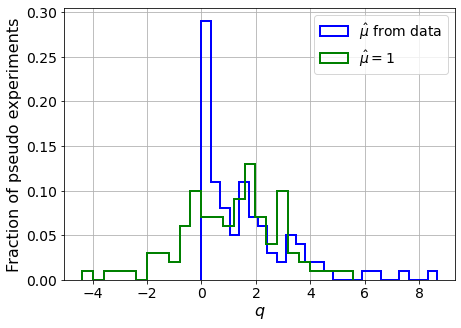

BP11_5

S_expected:  46
muhat mean:  0.9395
Z_bins:  1.1040183920181688
std Z_bins:  0.7631558831638174
Z_bins mu=1:  1.1040183920181688
std Z_bins mu=1:  0.8049358306396358

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


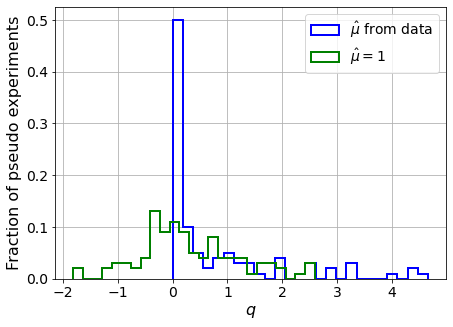

BP12_1

S_expected:  49
muhat mean:  0.9175000000000001
Z_bins:  0.43569957745848575
std Z_bins:  1.3079248423310676
Z_bins mu=1:  0.4160331422271617
std Z_bins mu=1:  1.077949046929726

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


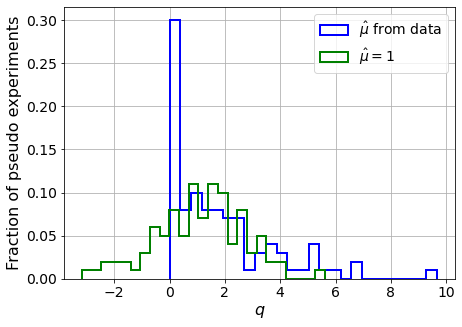

BP12_2

S_expected:  71
muhat mean:  1.1515
Z_bins:  1.1050893582031054
std Z_bins:  0.8554417968178979
Z_bins mu=1:  1.0896410717256724
std Z_bins mu=1:  0.7491065473817126

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


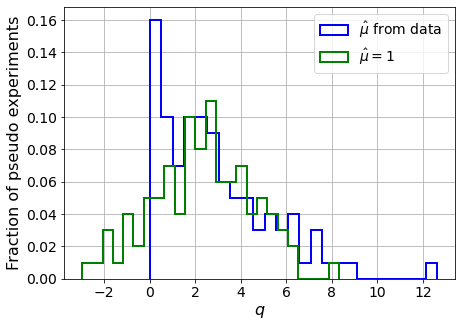

BP12_3

S_expected:  94
muhat mean:  1.0830000000000002
Z_bins:  1.5659203625921132
std Z_bins:  0.7636309998410595
Z_bins mu=1:  1.560449372289654
std Z_bins mu=1:  0.7009361390352848

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


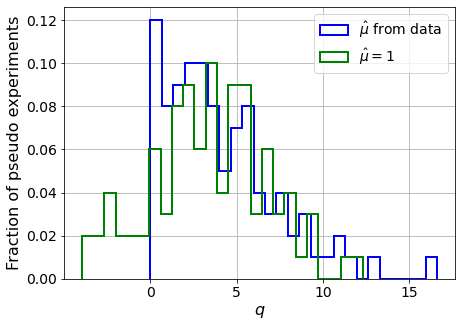

BP12_4

S_expected:  110
muhat mean:  0.9535000000000001
Z_bins:  1.8724931282623716
std Z_bins:  0.8576394633694544
Z_bins mu=1:  1.8692346733168501
std Z_bins mu=1:  0.8948955185593448

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


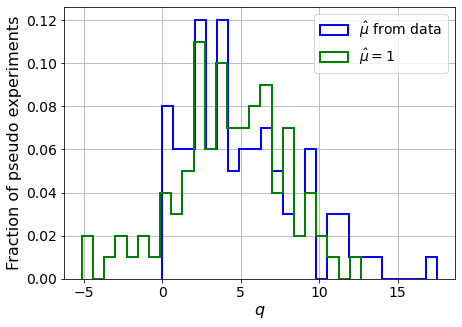

BP12_5

S_expected:  90
muhat mean:  1.087
Z_bins:  2.0542837018393345
std Z_bins:  0.8604361402057061
Z_bins mu=1:  2.0530511844393318
std Z_bins mu=1:  0.8324516864553706

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


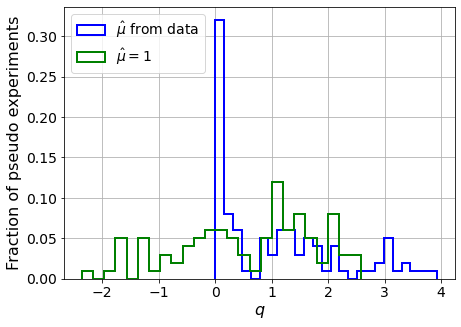

BP13_1

S_expected:  61
muhat mean:  1.0185000000000002
Z_bins:  0.9415948350244319
std Z_bins:  0.5894479718126683
Z_bins mu=1:  0.930679578694536
std Z_bins mu=1:  0.6447598678633263

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


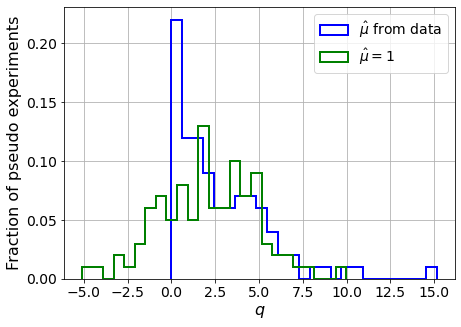

BP13_2

S_expected:  93
muhat mean:  0.9625
Z_bins:  1.4023456135154857
std Z_bins:  0.9468483917144961
Z_bins mu=1:  1.3944110917468755
std Z_bins mu=1:  0.9528335809147926

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


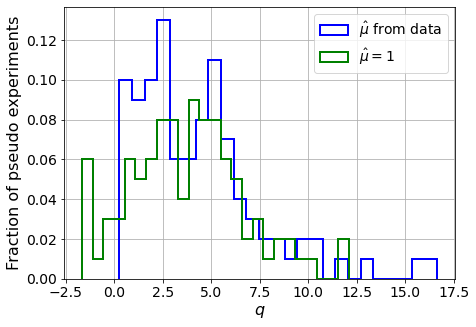

BP13_3

S_expected:  95
muhat mean:  1.037
Z_bins:  1.975539669568167
std Z_bins:  0.8170633233155599
Z_bins mu=1:  1.9750558746179308
std Z_bins mu=1:  0.7368686580388921

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


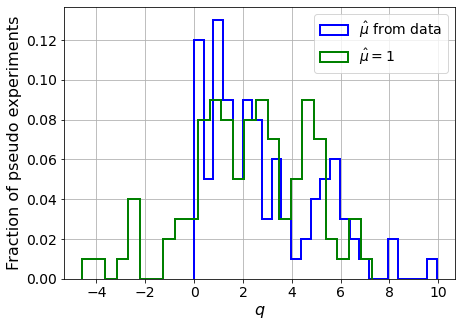

BP13_4

S_expected:  65
muhat mean:  0.9995
Z_bins:  1.4918209146694064
std Z_bins:  0.7412892777342422
Z_bins mu=1:  1.4918209146694064
std Z_bins mu=1:  0.8055579429563315

--------



In [659]:
D_or_E = 'discovery'
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]]
# requested number of pseudo experiments
num_pseudo = 100
    
print('B_expected: ', B_expected)
print('')
Z_BL_BPs = np.ones(len(BPS_analyzed)) * (-99)
Z_BL_std_BPs = np.ones(len(BPS_analyzed)) * (-99)
muhat_BL = np.ones(len(BPS_analyzed)) * (-99)
for bp in BPS_analyzed:
    S_expected = int(results[BPs_names[bp]]['pptox1n2']['#Signal_expected'] + results[BPs_names[bp]]['pptox1n3']['#Signal_expected'])
    Z_BL = BL_test_fast(D_or_E, pred_XG_SM, y_pred_xg[np.where( (df_test_array[:,24] == (bp+1)) )[0]], B_expected, int(S_expected), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 
    
    Z_BL_BPs[bp] = Z_BL[0]
    Z_BL_std_BPs[bp] = Z_BL[1]
    muhat_BL[bp] = Z_BL[2]
    
    print('BP' + BPs_names[bp] + '\n')
    print('S_expected: ', S_expected)
    print('muhat mean: ', Z_BL[2])
    print('Z_bins: ', Z_BL[0])
    print('std Z_bins: ', Z_BL[1])
    print('Z_bins mu=1: ', Z_BL[3])
    print('std Z_bins mu=1: ', Z_BL[4])
    print('')
    print('--------\n')

## KDE

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  9788.03757337  9553.45297226
  9244.89472049  8846.90975154  8349.23148752  7751.86537153
  7024.90532489  6142.14722504  5070.19748133  3750.48913154
  2113.29529155   130.75627387 -2189.12990522 -5113.59196138]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  4886.89360564  4904.44027453  4899.58858639


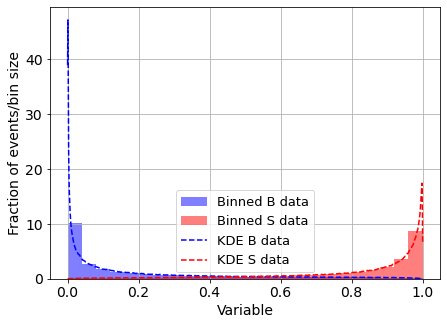

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0019008479046983867


In [660]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs

# outputs:
# 1st -> background PDF
# 2nd -> signal PDF
# 3rd -> (normalization factor of the background PDF)**-1
# 4th -> (normalization factor of the signal PDF)**-1
# 5th -> background bandwidth
# 6th -> signal bandwidth
pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] > 0)[0]]

kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                        50000, # Numero de datos para fitear
                                                                                        np.logspace(-4.0, 0.05, 20), 
                                                                                        set_kernel='epanechnikov')

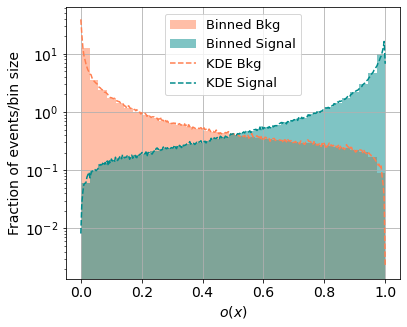

In [661]:
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

# points
s_vals = np.linspace(min_val,max_val,300)

# evaluate the PDFs for each value of s
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

# normalize
dens_bkg = dens_bkg / norm_factor_SM
dens_sig = dens_sig / norm_factor_NP

plt.figure(figsize=(6,5))

plt.hist(pred_XG_SM, 35, range=[min_val,max_val], density=True, color='coral',alpha=0.5, linewidth=2, label=r'Binned Bkg');
plt.hist(pred_XG_NP, 35, range=[min_val,max_val], density=True, color='darkcyan',alpha=0.5, linewidth=2, label=r'Binned Signal');

plt.plot(s_vals, dens_bkg, color='coral',label=r'KDE Bkg',linestyle='dashed');
plt.plot(s_vals, dens_sig, color='darkcyan',label=r'KDE Signal',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xlabel("$o(x)$",fontsize=14)
plt.ylabel("Fraction of events/bin size",fontsize=14)
plt.grid()
plt.legend(loc='upper center',fontsize=13)

plt.savefig('../graph/KDE_fit_ALLBPs.pdf', bbox_inches='tight')

In [662]:

print('This may take a while...')

pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
print('1 done')
pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
print('2 done')

# Normalize
pB_B_data = pB_B_data / norm_factor_SM
pS_B_data = pS_B_data / norm_factor_NP

This may take a while...
1 done
2 done


0:5862
3 done
4 done
0.004125018203340507
0.004125018203340507
B_expected:  147986
S_expected:  108

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


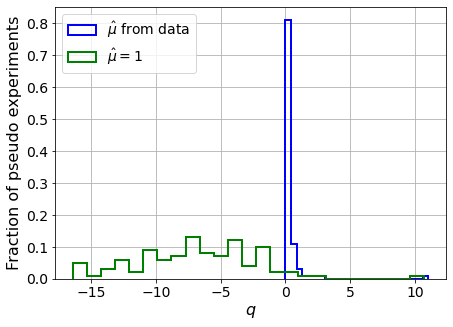

BP1_1
muhat mean:  0.05550000000000002
Z_MLL:  0.0
std Z_MLL:  inf
Z_MLL mu=1:  2.651752434889437
std Z_MLL mu=1:  0.8687101832906399
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

1:9484


/home/martinrios/martin/trabajos/MLLHC/codes/AUX_MLL_BL.py:1114: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)
/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0023297515088163464
0.0023297515088163464
B_expected:  147986
S_expected:  271

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


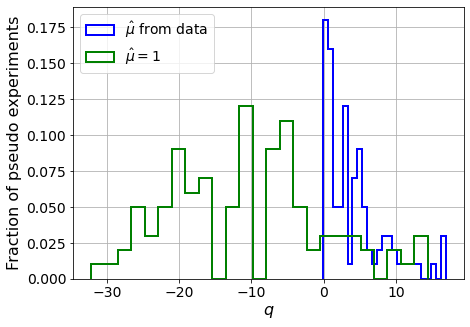

BP1_2
muhat mean:  0.3045
Z_MLL:  1.7088982801718247
std Z_MLL:  1.19595874702764
Z_MLL mu=1:  3.2734383709324186
std Z_MLL mu=1:  1.6150377783940384
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

2:11580


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.002766969224656332
0.002766969224656332
B_expected:  147986
S_expected:  484

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


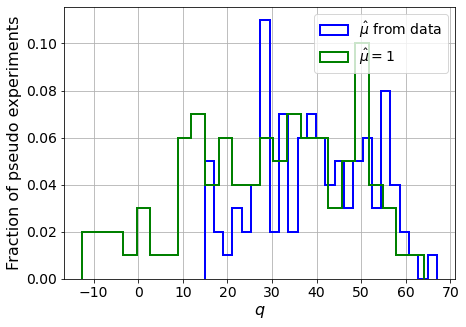

BP1_3
muhat mean:  0.6410000000000001
Z_MLL:  6.236517898995507
std Z_MLL:  1.006186152698214
Z_MLL mu=1:  5.532003842449051
std Z_MLL mu=1:  1.6421584537651477
Z_MLL new:  0.017921549797034916
std Z_MLL new:  48.60085750291572

--------

3:8004
3 done
4 done
0.0030976174358226536
0.0030976174358226536
B_expected:  147986
S_expected:  420

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


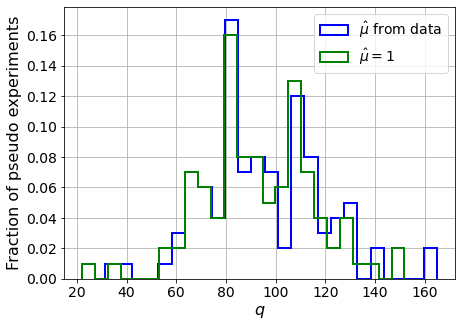

BP1_4
muhat mean:  1.129
Z_MLL:  9.585320016117274
std Z_MLL:  1.2386997636323207
Z_MLL mu=1:  9.570457304550278
std Z_MLL mu=1:  1.1694138692236342
Z_MLL new:  3.862100382447329
std Z_MLL new:  1.2175220163865705

--------

4:4231
3 done
4 done
0.0051686325329919946
0.0051686325329919946
B_expected:  147986
S_expected:  46

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


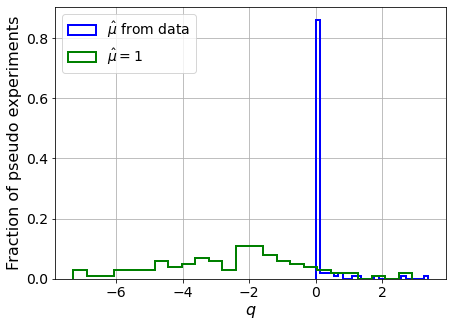

BP2_1
muhat mean:  0.05700000000000003
Z_MLL:  0.0
std Z_MLL:  inf
Z_MLL mu=1:  1.4629390904777964
std Z_MLL mu=1:  0.7186784727254237
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

5:7813


/home/martinrios/martin/trabajos/MLLHC/codes/AUX_MLL_BL.py:1114: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)
/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.003913369319767386
0.003913369319767386
B_expected:  147986
S_expected:  135

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


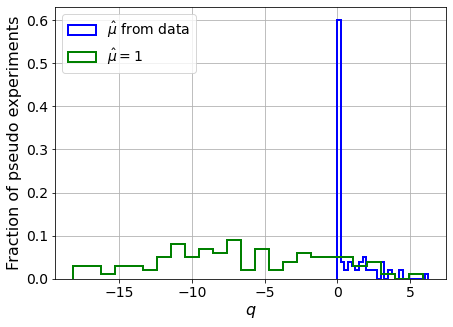

BP2_2
muhat mean:  0.158
Z_MLL:  0.2421073403726305
std Z_MLL:  2.6350979497293743
Z_MLL mu=1:  2.670397933303313
std Z_MLL mu=1:  1.0599605991856622
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

6:9997


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0033807888386784674
0.0033807888386784674
B_expected:  147986
S_expected:  223

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


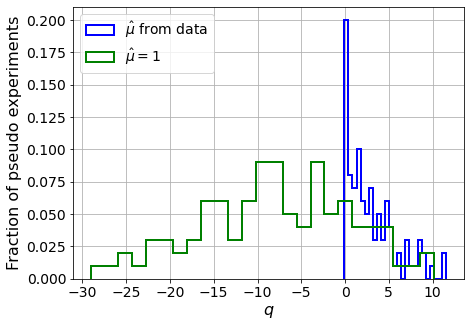

BP2_3
muhat mean:  0.2945
Z_MLL:  1.455722506158757
std Z_MLL:  0.9741177041400945
Z_MLL mu=1:  2.8456371785042314
std Z_MLL mu=1:  1.4947167497982417
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

7:11954


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0031474944877644966
0.0031474944877644966
B_expected:  147986
S_expected:  368

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


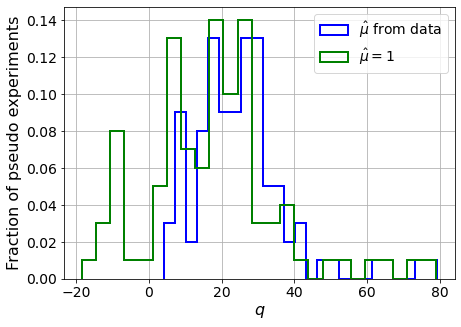

BP2_4
muhat mean:  0.6335000000000001
Z_MLL:  4.92400621953103
std Z_MLL:  1.3456195613534503
Z_MLL mu=1:  4.177585551677317
std Z_MLL mu=1:  2.127830739464359
Z_MLL new:  0.0
std Z_MLL new:  inf

--------

8:7081
3 done


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


4 done
0.00295162439624412
0.00295162439624412
B_expected:  147986
S_expected:  319

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


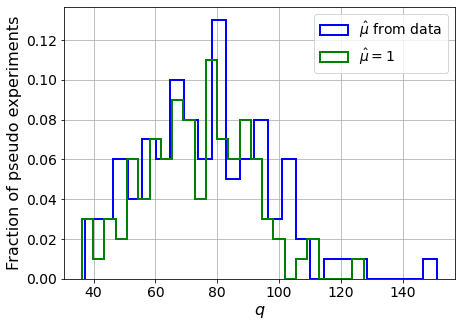

BP2_5
muhat mean:  1.284
Z_MLL:  8.70015631006009
std Z_MLL:  1.187032214768366
Z_MLL mu=1:  8.544220849044937
std Z_MLL mu=1:  1.0225695778517034
Z_MLL new:  3.137708824706973
std Z_MLL new:  1.1356543476101677

--------

9:4732
3 done
4 done
0.003243376593701468
0.003243376593701468
B_expected:  147986
S_expected:  46

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


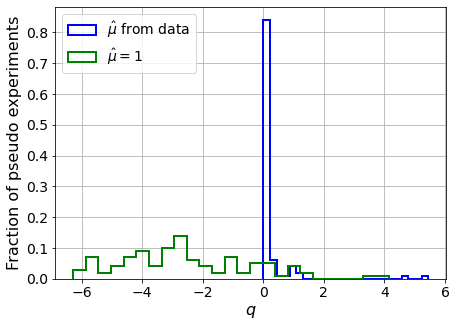

BP3_1
muhat mean:  0.09300000000000001
Z_MLL:  0.0
std Z_MLL:  inf
Z_MLL mu=1:  1.6893488467133755
std Z_MLL mu=1:  0.6284691309727851
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

10:7619


/home/martinrios/martin/trabajos/MLLHC/codes/AUX_MLL_BL.py:1114: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)
/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0028998762498398177
0.0028998762498398177
B_expected:  147986
S_expected:  103

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


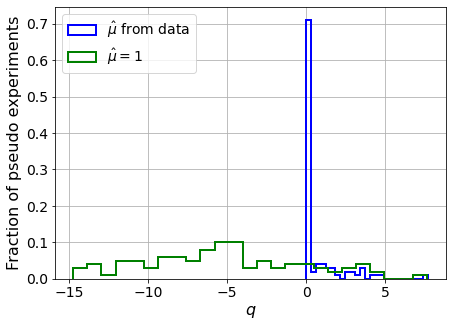

BP3_2
muhat mean:  0.138
Z_MLL:  0.0
std Z_MLL:  inf
Z_MLL mu=1:  2.3361670783102926
std Z_MLL mu=1:  1.066094661067332
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

11:11845


/home/martinrios/martin/trabajos/MLLHC/codes/AUX_MLL_BL.py:1114: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)
/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0025154754711932
0.0025154754711932
B_expected:  147986
S_expected:  346

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


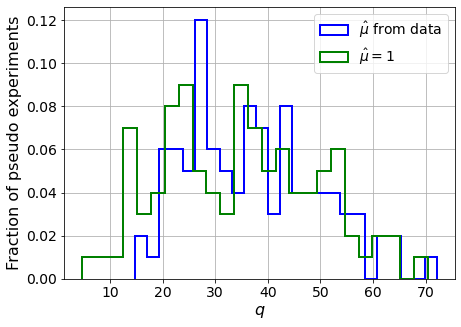

BP3_3
muhat mean:  0.8110000000000003
Z_MLL:  6.045148002472507
std Z_MLL:  1.023230691469906
Z_MLL mu=1:  5.906736839256043
std Z_MLL mu=1:  1.2213941837244644
Z_MLL new:  0.6656888785008395
std Z_MLL new:  1.9262312492328466

--------

12:4165
3 done
4 done
0.0029713686651050304
0.0029713686651050304
B_expected:  147986
S_expected:  167

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


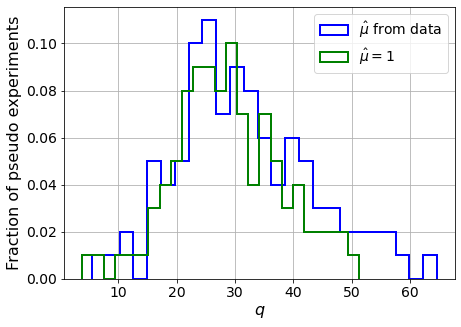

BP3_4
muhat mean:  1.433
Z_MLL:  5.489640534036415
std Z_MLL:  1.0640546351641507
Z_MLL mu=1:  5.328263199073887
std Z_MLL mu=1:  0.8584303215212864
Z_MLL new:  0.6824084459476731
std Z_MLL new:  1.4664415422580768

--------

13:1944
3 done
4 done
0.0067744435722627205
0.0067744435722627205
B_expected:  147986
S_expected:  11

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


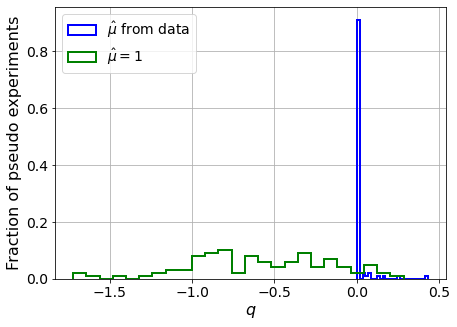

BP4_1
muhat mean:  0.029000000000000036
Z_MLL:  0.0
std Z_MLL:  inf
Z_MLL mu=1:  0.7769841746325014
std Z_MLL mu=1:  0.27390376160388796
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

14:4606


/home/martinrios/martin/trabajos/MLLHC/codes/AUX_MLL_BL.py:1114: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)
/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.004637610100406859
0.004637610100406859
B_expected:  147986
S_expected:  36

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


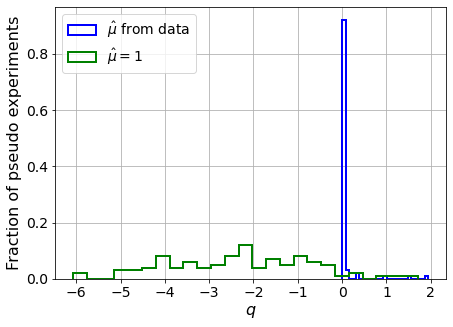

BP4_2
muhat mean:  0.002000000000000016
Z_MLL:  0.0
std Z_MLL:  inf
Z_MLL mu=1:  1.5196547233867492
std Z_MLL mu=1:  0.5184423061631956
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

15:10788


/home/martinrios/martin/trabajos/MLLHC/codes/AUX_MLL_BL.py:1114: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)
/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0026283912235865606
0.0026283912235865606
B_expected:  147986
S_expected:  182

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


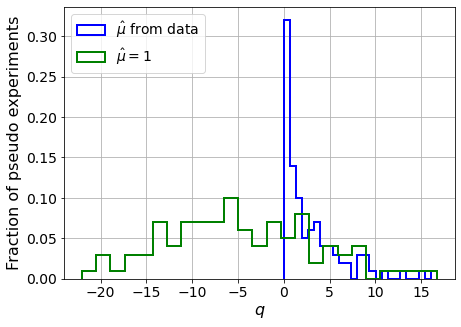

BP4_3
muhat mean:  0.33199999999999996
Z_MLL:  1.250986887849334
std Z_MLL:  1.3737373184739692
Z_MLL mu=1:  2.3413727798097277
std Z_MLL mu=1:  1.739407567104495
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

16:11466


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0030952729420155294
0.0030952729420155294
B_expected:  147986
S_expected:  302

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


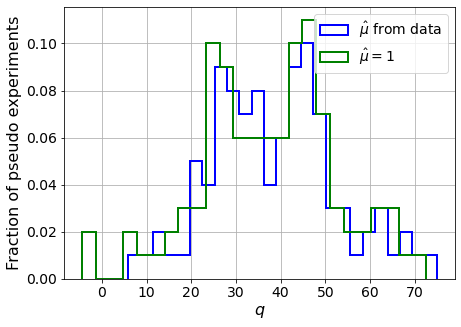

BP4_4
muhat mean:  0.939
Z_MLL:  6.140953447611532
std Z_MLL:  1.1262046258085439
Z_MLL mu=1:  6.125040951109691
std Z_MLL mu=1:  1.2255367080280304
Z_MLL new:  0.9457402968430798
std Z_MLL new:  1.3211378451308176

--------

17:4342
3 done
4 done
0.0027725209127851896
0.0027725209127851896
B_expected:  147986
S_expected:  149

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


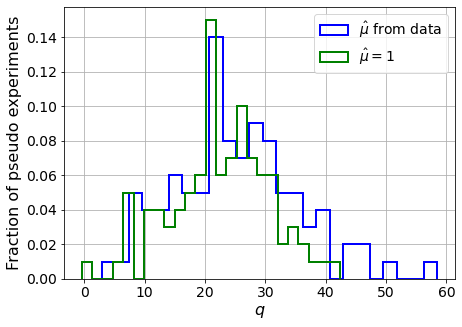

BP4_5
muhat mean:  1.4110000000000003
Z_MLL:  4.883437668538513
std Z_MLL:  1.0649764257065415
Z_MLL mu=1:  4.715603214342056
std Z_MLL mu=1:  0.8599559964286664
Z_MLL new:  0.048799256823895146
std Z_MLL new:  10.468822577385238

--------

18:3712
3 done
4 done
0.00399958077587854
0.00399958077587854
B_expected:  147986
S_expected:  21

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


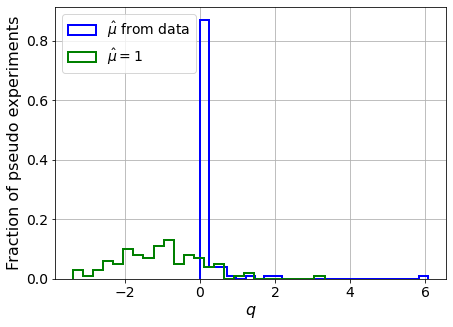

BP5_1
muhat mean:  0.16499999999999995
Z_MLL:  0.0
std Z_MLL:  inf
Z_MLL mu=1:  1.0280349589993591
std Z_MLL mu=1:  0.5384700257594202
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

19:7654


/home/martinrios/martin/trabajos/MLLHC/codes/AUX_MLL_BL.py:1114: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)
/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0037507574245264747
0.0037507574245264747
B_expected:  147986
S_expected:  76

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


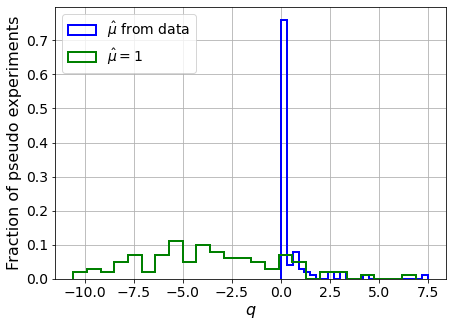

BP5_2
muhat mean:  0.11600000000000002
Z_MLL:  0.0
std Z_MLL:  inf
Z_MLL mu=1:  1.946907979451873
std Z_MLL mu=1:  0.8807504232212124
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

20:9836


/home/martinrios/martin/trabajos/MLLHC/codes/AUX_MLL_BL.py:1114: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)
/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.002936678855669339
0.002936678855669339
B_expected:  147986
S_expected:  127

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


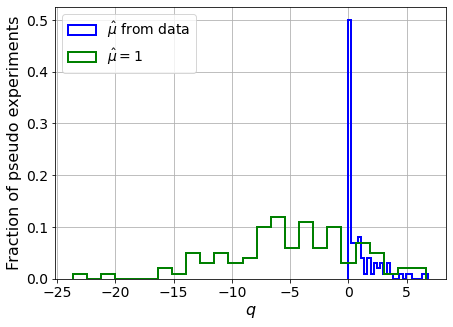

BP5_3
muhat mean:  0.22699999999999998
Z_MLL:  0.5258466170748597
std Z_MLL:  1.3955211222674144
Z_MLL mu=1:  2.2171766395040926
std Z_MLL mu=1:  1.254436714349826
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

21:11647


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.002696562365859927
0.002696562365859927
B_expected:  147986
S_expected:  262

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


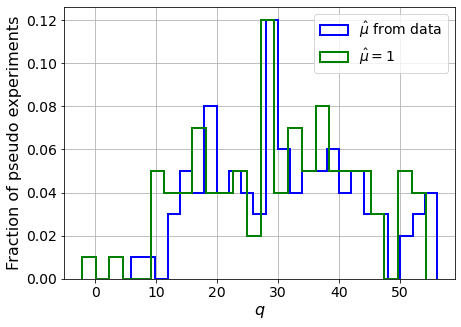

BP5_4
muhat mean:  0.951
Z_MLL:  5.466480583588439
std Z_MLL:  1.0833418976861344
Z_MLL mu=1:  5.445484434039038
std Z_MLL mu=1:  1.156865693510864
Z_MLL new:  0.20689607804339877
std Z_MLL new:  3.455855922592574

--------

22:4806
3 done
4 done
0.0028622196015070907
0.0028622196015070907
B_expected:  147986
S_expected:  138

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


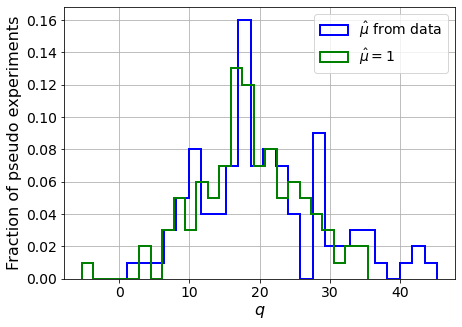

BP5_5
muhat mean:  1.3659999999999999
Z_MLL:  4.3239784446693195
std Z_MLL:  1.040290895031133
Z_MLL mu=1:  4.239695498556677
std Z_MLL mu=1:  0.8512184499323107
Z_MLL new:  0.0
std Z_MLL new:  inf

--------

23:4129


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.003536963681393346
0.003536963681393346
B_expected:  147986
S_expected:  21

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


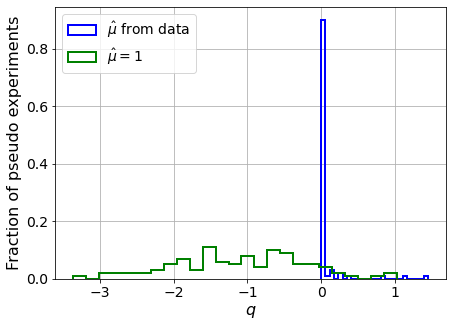

BP6_1
muhat mean:  0.046
Z_MLL:  0.0
std Z_MLL:  inf
Z_MLL mu=1:  1.0301060379041322
std Z_MLL mu=1:  0.42911027926113204
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

24:7649


/home/martinrios/martin/trabajos/MLLHC/codes/AUX_MLL_BL.py:1114: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)
/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0028429820684997944
0.0028429820684997944
B_expected:  147986
S_expected:  61

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


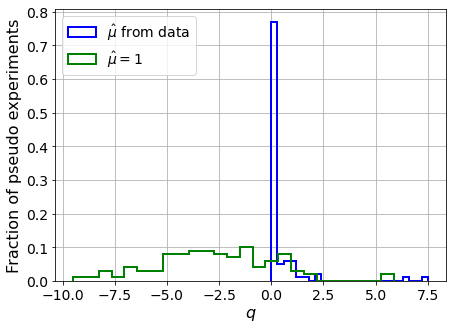

BP6_2
muhat mean:  0.15849999999999997
Z_MLL:  0.0
std Z_MLL:  inf
Z_MLL mu=1:  1.6612333084968234
std Z_MLL mu=1:  0.8526882926959025
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

25:9527


/home/martinrios/martin/trabajos/MLLHC/codes/AUX_MLL_BL.py:1114: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)
/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0029162536823393644
0.0029162536823393644
B_expected:  147986
S_expected:  101

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


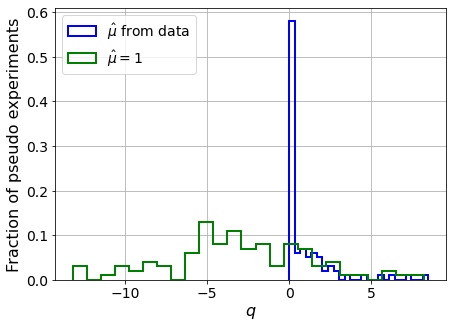

BP6_3
muhat mean:  0.2575
Z_MLL:  0.457839816985862
std Z_MLL:  1.6938686857337943
Z_MLL mu=1:  1.743086683520007
std Z_MLL mu=1:  1.2034343995582462
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

26:12677


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0028697648588097593
0.0028697648588097593
B_expected:  147986
S_expected:  206

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


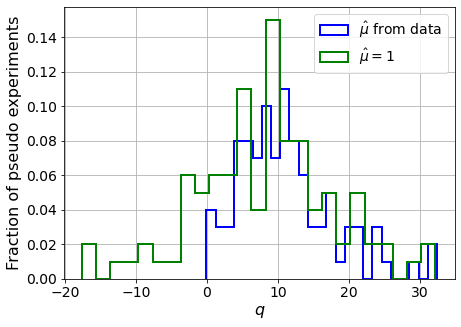

BP6_4
muhat mean:  0.6780000000000002
Z_MLL:  3.235681957783699
std Z_MLL:  1.0532365788229645
Z_MLL mu=1:  2.9151863106594136
std Z_MLL mu=1:  1.6442745512085248
Z_MLL new:  0.0
std Z_MLL new:  inf

--------

27:11333


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0027794553432468746
0.0027794553432468746
B_expected:  147986
S_expected:  222

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


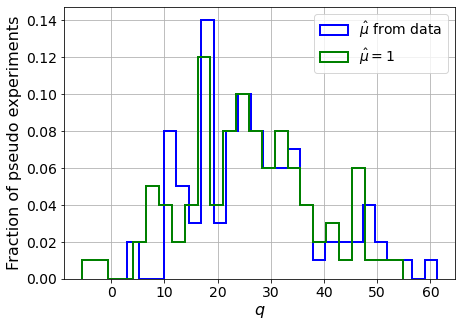

BP6_5
muhat mean:  1.0285000000000002
Z_MLL:  5.032973340050835
std Z_MLL:  1.198132344191618
Z_MLL mu=1:  5.034773553167268
std Z_MLL mu=1:  1.1921721724630872
Z_MLL new:  0.0
std Z_MLL new:  inf

--------

28:5093
3 done


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


4 done
0.0028112795961172093
0.0028112795961172093
B_expected:  147986
S_expected:  124

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


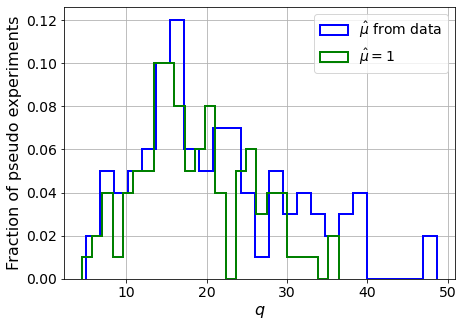

BP6_6
muhat mean:  1.5145000000000002
Z_MLL:  4.343208123352365
std Z_MLL:  1.0947766148799982
Z_MLL mu=1:  4.147306125568783
std Z_MLL mu=1:  0.836251716422346
Z_MLL new:  0.0
std Z_MLL new:  inf

--------

29:7031


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.002700061666450851
0.002700061666450851
B_expected:  147986
S_expected:  49

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


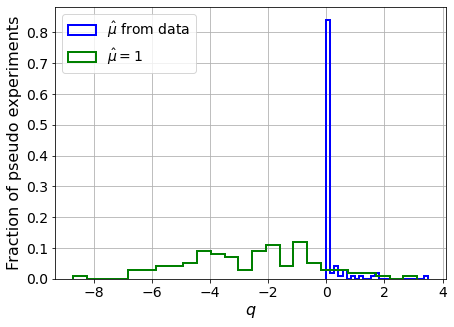

BP7_1
muhat mean:  0.07700000000000001
Z_MLL:  0.0
std Z_MLL:  inf
Z_MLL mu=1:  1.5593951993078594
std Z_MLL mu=1:  0.7031912572216203
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

30:8454


/home/martinrios/martin/trabajos/MLLHC/codes/AUX_MLL_BL.py:1114: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)
/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0028002241033027015
0.0028002241033027015
B_expected:  147986
S_expected:  119

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


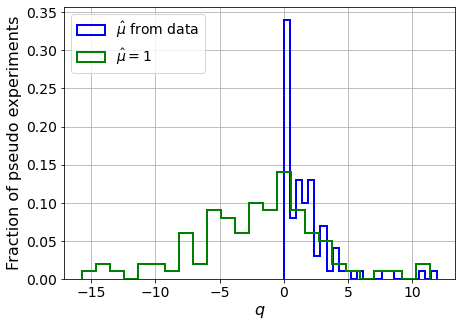

BP7_2
muhat mean:  0.365
Z_MLL:  1.0695487554211227
std Z_MLL:  0.987163956714317
Z_MLL mu=1:  1.3018968488177975
std Z_MLL mu=1:  1.8665250758623007
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

31:12911


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.002648125086899346
0.002648125086899346
B_expected:  147986
S_expected:  176

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


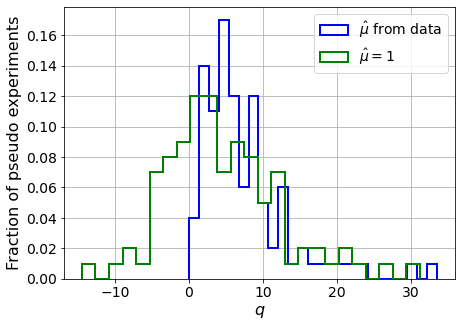

BP7_3
muhat mean:  0.6325000000000002
Z_MLL:  2.427627368709996
std Z_MLL:  1.2209360957667217
Z_MLL mu=1:  1.8606762534566064
std Z_MLL mu=1:  2.083570030809815
Z_MLL new:  0.0
std Z_MLL new:  inf

--------

32:11685


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0024530755140041455
0.0024530755140041455
B_expected:  147986
S_expected:  198

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


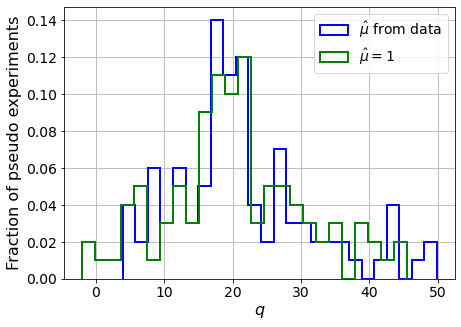

BP7_4
muhat mean:  1.012
Z_MLL:  4.4512387376006055
std Z_MLL:  1.157407925167025
Z_MLL mu=1:  4.4481847523507385
std Z_MLL mu=1:  1.1422321876112649
Z_MLL new:  0.0
std Z_MLL new:  inf

--------

33:7802


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0024321787254481773
0.0024321787254481773
B_expected:  147986
S_expected:  154

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


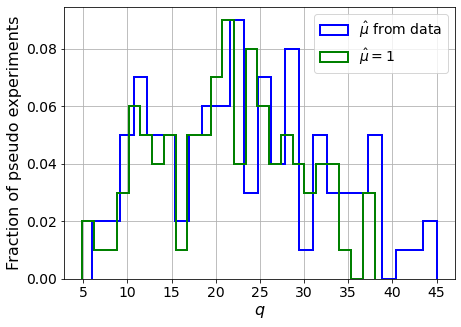

BP7_5
muhat mean:  1.3204999999999998
Z_MLL:  4.7154295677737625
std Z_MLL:  0.9967735774402948
Z_MLL mu=1:  4.613396692075399
std Z_MLL mu=1:  0.839904828945215
Z_MLL new:  0.0
std Z_MLL new:  inf

--------

34:10100


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0028697648588097593
0.0028697648588097593
B_expected:  147986
S_expected:  84

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


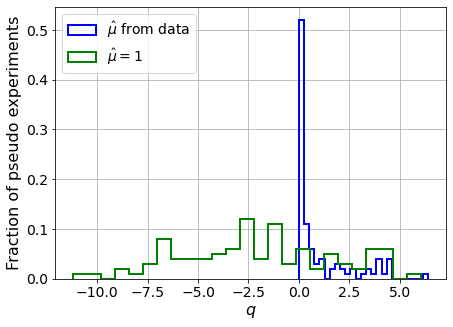

BP8_1
muhat mean:  0.31649999999999995
Z_MLL:  0.42152816666077725
std Z_MLL:  1.7523773221614436
Z_MLL mu=1:  1.5379738082831595
std Z_MLL mu=1:  1.2347971734095826
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

35:12436


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0028560410294691603
0.0028560410294691603
B_expected:  147986
S_expected:  133

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


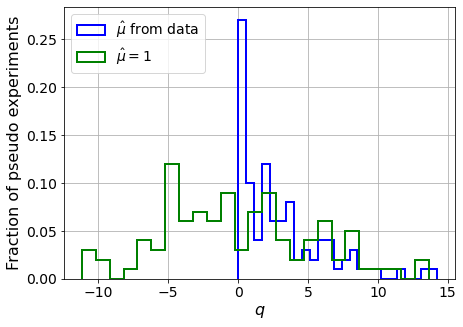

BP8_2
muhat mean:  0.485
Z_MLL:  1.4605426210322534
std Z_MLL:  1.062266345512612
Z_MLL mu=1:  0.7989342795978853
std Z_MLL mu=1:  3.3743267167077864
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

36:12775


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0024437139735301473
0.0024437139735301473
B_expected:  147986
S_expected:  172

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


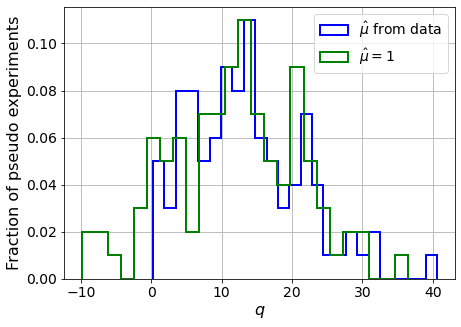

BP8_3
muhat mean:  0.8815000000000002
Z_MLL:  3.5740447988140938
std Z_MLL:  1.1108761465561792
Z_MLL mu=1:  3.5376819270349262
std Z_MLL mu=1:  1.284801139694463
Z_MLL new:  0.0
std Z_MLL new:  inf

--------

37:8324


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.002352475058032033
0.002352475058032033
B_expected:  147986
S_expected:  142

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


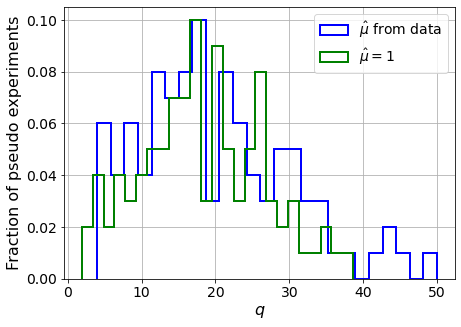

BP8_4
muhat mean:  1.2889999999999997
Z_MLL:  4.232449242903442
std Z_MLL:  1.1957105472746234
Z_MLL mu=1:  4.180794538832735
std Z_MLL mu=1:  0.9818894281416963
Z_MLL new:  0.0
std Z_MLL new:  inf

--------

38:9989


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0025568334355868774
0.0025568334355868774
B_expected:  147986
S_expected:  70

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


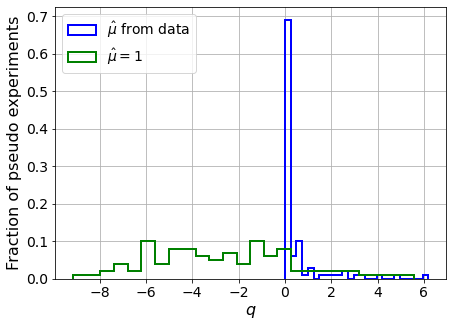

BP9_1
muhat mean:  0.19049999999999997
Z_MLL:  0.0
std Z_MLL:  inf
Z_MLL mu=1:  1.7203632431874782
std Z_MLL mu=1:  0.8868581076540035
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

39:12391


/home/martinrios/martin/trabajos/MLLHC/codes/AUX_MLL_BL.py:1114: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)
/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.002810589059457917
0.002810589059457917
B_expected:  147986
S_expected:  112

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


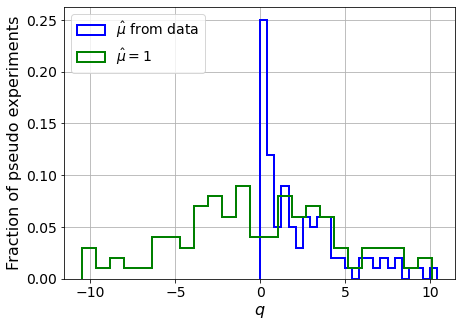

BP9_2
muhat mean:  0.4895000000000001
Z_MLL:  1.272629515866864
std Z_MLL:  0.976791626406259
Z_MLL mu=1:  0.7028286306629076
std Z_MLL mu=1:  3.2943926266738495
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

40:12457


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.002362657836246466
0.002362657836246466
B_expected:  147986
S_expected:  155

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


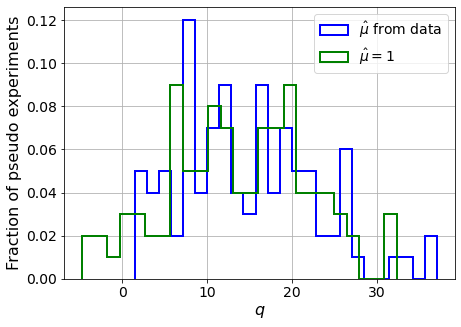

BP9_3
muhat mean:  1.0145
Z_MLL:  3.6674908514723383
std Z_MLL:  1.0984964546531188
Z_MLL mu=1:  3.667023478481673
std Z_MLL mu=1:  1.1178253784906513
Z_MLL new:  0.0
std Z_MLL new:  inf

--------

41:5826
3 done


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


4 done
0.0024516359100825117
0.0024516359100825117
B_expected:  147986
S_expected:  92

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


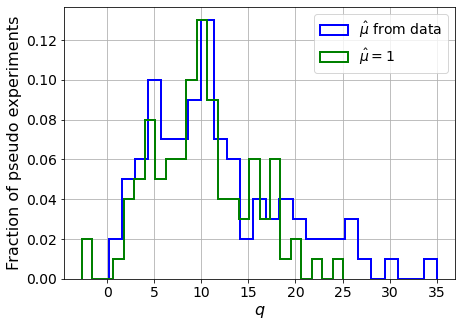

BP9_4
muhat mean:  1.4135
Z_MLL:  3.229496159875143
std Z_MLL:  1.0996199204763883
Z_MLL mu=1:  3.1308812496495237
std Z_MLL mu=1:  0.8435299435628651
Z_MLL new:  0.0
std Z_MLL new:  inf

--------

42:4096
3 done


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


4 done
0.0025368916936721153
0.0025368916936721153
B_expected:  147986
S_expected:  83

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


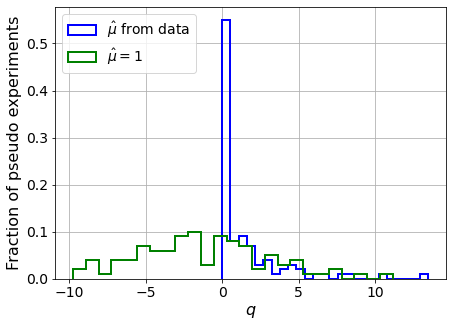

BP10_1
muhat mean:  0.39399999999999996
Z_MLL:  0.5469139262534461
std Z_MLL:  2.151280636748475
Z_MLL mu=1:  1.3271841158587168
std Z_MLL mu=1:  1.6000526564246285
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

43:13049


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0025133310001106478
0.0025133310001106478
B_expected:  147986
S_expected:  112

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


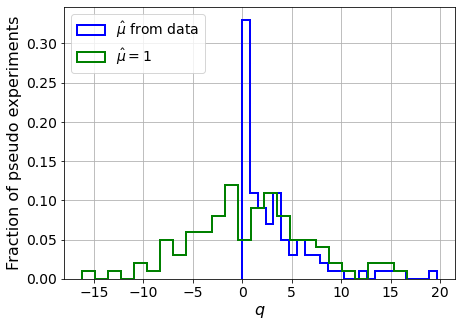

BP10_2
muhat mean:  0.562
Z_MLL:  1.4751657874503334
std Z_MLL:  1.337679916267609
Z_MLL mu=1:  0.8725633317449217
std Z_MLL mu=1:  3.449159344102903
Z_MLL new:  0.0
std Z_MLL new:  nan

--------

44:12634


/tmp/ipykernel_1082598/821805479.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0027112497595696097
0.0027112497595696097
B_expected:  147986
S_expected:  139



In [ ]:
D_or_E = "discovery"

Z_MLL_BPs = np.ones(len(BPS_analyzed)) * (-99)
Z_MLL_std_BPs = np.ones(len(BPS_analyzed)) * (-99)
Z_MLL_BPs_new = np.ones(len(BPS_analyzed)) * (-99)
Z_MLL_std_BPs_new = np.ones(len(BPS_analyzed)) * (-99)
muhat_MLL = np.ones(len(BPS_analyzed)) * (-99)
muhat_MLL_new = np.ones(len(BPS_analyzed)) * (-99)

#BPS_analyzed = [0,1,2,3,4,5,6,7]
for bp in BPS_analyzed:
    pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == (bp+1))[0]]
    #BP_indices = np.random.choice(np.arange(len(pred_XG_NP)), size = 10000, replace = False)
    pred_XG_NP = pred_XG_NP#[BP_indices]
    S_expected = int(results[BPs_names[bp]]['pptox1n2']['#Signal_expected'] + results[BPs_names[bp]]['pptox1n3']['#Signal_expected'])

    print(str(bp) + ':' + str(len(pred_XG_NP)))
    # FOR DISCOVERY:
    # we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    print(np.min(pB_S_data))
    pB_S_data[np.where(pB_S_data == 0 )[0]] = np.min(pB_S_data[np.where(pB_S_data > 0 )[0]])
    pS_S_data[np.where(pS_S_data == 0 )[0]] = np.min(pS_S_data[np.where(pS_S_data > 0 )[0]])
    print(np.min(pB_S_data))

    print('B_expected: ', int(B_expected))
    print('S_expected: ', int(S_expected))
    print('')

    Z_MLL = MLL_test_fast(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, int(S_expected), num_pseudo = 100, pred_XG_SM = pred_XG_SM, pred_XG_NP = pred_XG_NP)
    #Z_MLL = MLL_test_fsolve(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, int(S_expected[bp]), num_pseudo, path = '../graph/BP' + str(bp+1) + '/')

    Z_MLL_BPs[bp] = Z_MLL[0]
    Z_MLL_std_BPs[bp] = Z_MLL[1]
    muhat_MLL[bp] = Z_MLL[2]
    
    Z_MLL_BPs_new[bp] = abs( np.median(Z_MLL[6]) )**0.5
    Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])
    
    muhat_MLL_new[bp] = np.mean(Z_MLL[5])
    print('BP' + BPs_names[bp])
    print('muhat mean: ', Z_MLL[2])
    print('Z_MLL: ', Z_MLL[0])
    print('std Z_MLL: ', Z_MLL[1])
    print('Z_MLL mu=1: ', Z_MLL[3])
    print('std Z_MLL mu=1: ', Z_MLL[4])
    print('Z_MLL new: ', Z_MLL_BPs_new[bp])
    print('std Z_MLL new: ', Z_MLL_std_BPs_new[bp])
    print('')
    print('--------\n')

In [ ]:
plt.hist(np.log10((1-pred_XG_SM)/pred_XG_SM))

In [ ]:
plt.scatter( (1-pred_XG_SM)/pred_XG_SM, pB_B_data / pS_B_data)
plt.xscale('log')
plt.yscale('log')
plt.plot([1e-3,1e6],[1e-3,1e6])
plt.axvline(x=2750)
plt.axvline(x=100)
plt.xlim(1e1,1e5)
plt.ylim(1e1,1e5)

In [ ]:
plt.scatter(pred_XG_SM,pB_B_data)
plt.xscale('log')
plt.axvline(x=1/101)
plt.axvline(x=1/2750)

In [ ]:
if len(Z_BL_loops) == 0:
    Z_BL_loops = []
    Z_BL_std_loops = []
    muhat_BL_loops = []

    Z_MLL_loops = []
    Z_MLL_std_loops = []
    muhat_MLL_loops = []

    Z_MLL_new_loops = []
    Z_MLL_new_std_loops = []
    muhat_MLL_new_loops = []

    Z_sbc_loops = []
    Z_sbc_std_loops = []

Z_BL_loops.append( Z_BL_BPs )
Z_BL_std_loops.append( Z_BL_std_BPs )
muhat_BL_loops.append( muhat_BL )

Z_MLL_loops.append( Z_MLL_BPs )
Z_MLL_std_loops.append( Z_MLL_std_BPs )
muhat_MLL_loops.append( muhat_MLL )

Z_MLL_new_loops.append( Z_MLL_BPs_new )
Z_MLL_new_std_loops.append( Z_MLL_std_BPs_new )
muhat_MLL_new_loops.append( muhat_MLL_new )

#Z_sbc_loops.append( Z_sbc_BPs )
#Z_sbc_std_loops.append( Z_sbc_std_BPs )

In [ ]:
Z_BL_loops_ar = np.asarray(Z_BL_loops)
Z_BL_std_loops_ar = np.asarray(Z_BL_std_loops)
muhat_BL_loops_ar = np.asarray(muhat_BL_loops)

Z_MLL_loops_ar = np.asarray(Z_MLL_loops)
Z_MLL_std_loops_ar = np.asarray(Z_MLL_std_loops)
muhat_MLL_loops_ar = np.asarray(muhat_MLL_loops)

Z_MLL_new_loops_ar = np.asarray(Z_MLL_new_loops)
Z_MLL_new_std_loops_ar = np.asarray(Z_MLL_new_std_loops)
muhat_MLL_new_loops_ar = np.asarray(muhat_MLL_new_loops)

#Z_sbc_loops_ar = np.asarray(Z_sbc_loops)
#Z_sbc_std_loops_ar = np.asarray(Z_sbc_std_loops)

In [670]:
Z_MLL_loops_ar.shape

(10, 60)

In [671]:
np.save('../data/models/Z_BL_MET100_BPI.npy', Z_BL_loops_ar)
np.save('../data/models/Z_BL_std_MET100_BPI.npy', Z_BL_std_loops_ar)
np.save('../data/models/muhat_BL_MET100_BPI.npy', muhat_BL_loops_ar)
np.save('../data/models/Z_MLL_MET100_BPI.npy', Z_MLL_loops_ar)
np.save('../data/models/Z_MLL_std_MET100_BPI.npy', Z_MLL_std_loops_ar)
np.save('../data/models/muhat_MLL_MET100_BPI.npy', muhat_MLL_loops_ar)
np.save('../data/models/Z_MLL_new_MET100_BPI.npy', Z_MLL_new_loops_ar)
np.save('../data/models/Z_MLL_new_std_MET100_BPI.npy', Z_MLL_new_std_loops_ar)
np.save('../data/models/muhat_MLL_new_MET100_BPI.npy', muhat_MLL_new_loops_ar)
#np.save('../data/models/Z_sbc_MET100_BPI.npy', Z_sbc_loops_ar)
#np.save('../data/models/Z_sbc_std_MET100_BPI.npy', Z_sbc_std_loops_ar)

In [672]:
for i in range(len(Z_BL_loops_ar[0,:])):
    #print('BP' + str(i+1) + ': Z_SBC: ' + str(np.mean(Z_sbc_loops_ar, axis = 0)[i]) + ' +/- ' + str(np.std(Z_sbc_loops_ar, axis = 0)[i]) + ' +/- ' + str(np.mean(Z_sbc_std_loops_ar[10:,:], axis = 0)[i]))
    print('BP' + str(i+1) + ':+ Z_BL: ' + str(np.mean(Z_BL_loops_ar, axis = 0)[i]) + ' +/- ' + str(np.std(Z_BL_loops_ar, axis = 0)[i]) + ' +/- ' + str(np.mean(Z_BL_std_loops_ar[10:,:], axis = 0)[i]))
    print('BP' + str(i+1) + ': Z_MLL: ' + str(np.mean(Z_MLL_loops_ar, axis = 0)[i]) + ' +/- ' + str(np.std(Z_MLL_loops_ar, axis = 0)[i]) + ' +/- ' + str(np.mean(Z_MLL_std_loops_ar[10:,:], axis = 0)[i]))
    print('BP' + str(i+1) + ': Z_new: ' + str(np.mean(Z_MLL_new_loops_ar, axis = 0)[i]) + ' +/- ' + str(np.std(Z_MLL_new_loops_ar, axis = 0)[i]) + ' +/- ' + str(np.mean(Z_MLL_new_std_loops_ar[10:,:], axis = 0)[i]))
    print('\n')

BP1:+ Z_BL: 0.7629193718845418 +/- 0.06864369307972336 +/- nan
BP1: Z_MLL: 0.31165409362381424 +/- 0.2841462012577753 +/- nan
BP1: Z_new: 0.0 +/- 0.0 +/- nan


BP2:+ Z_BL: 2.5272942544902453 +/- 0.07241061652600808 +/- nan
BP2: Z_MLL: 2.1393469218709864 +/- 0.5296127674208527 +/- nan
BP2: Z_new: 0.0 +/- 0.0 +/- nan


BP3:+ Z_BL: 6.284504111945498 +/- 0.1298082316593394 +/- nan
BP3: Z_MLL: 6.719832882358247 +/- 0.6019919534033369 +/- nan
BP3: Z_new: 1.2645657774381838 +/- 0.588833734123047 +/- nan


BP4:+ Z_BL: 7.875618496619228 +/- 0.0996067601793177 +/- nan
BP4: Z_MLL: 9.993899579776055 +/- 0.5529636106368363 +/- nan
BP4: Z_new: 4.545672201967305 +/- 0.4145980886437245 +/- nan


BP5:+ Z_BL: 0.3252100668941231 +/- 0.1242775671683067 +/- nan
BP5: Z_MLL: 0.019684676337296887 +/- 0.043862132735992654 +/- nan
BP5: Z_new: 0.0 +/- 0.0 +/- nan


BP6:+ Z_BL: 1.1926878979670794 +/- 0.08124989800629086 +/- nan
BP6: Z_MLL: 0.6888990551176523 +/- 0.4041772282996111 +/- nan
BP6: Z_new: 0.0 +/- 0.0 

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


### Let's try

In [84]:

q_muhat_MLL_mu = []
q_muhat_MLL = []
muhat_selected_MLL_list = []
mu_list = []
q_list = []


B_rand = np.random.poisson(int(B_expected))

ran_ind = np.random.choice(indices_B, B_rand)
pb_ps_B_data = (1 - pred_XG_SM[ran_ind]) / pred_XG_SM[ran_ind]

pB_B_data_shuf = []
pS_B_data_shuf = []

# for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
for i in ran_ind:
    pB_B_data_shuf.append(pB_B_data[i])
    pS_B_data_shuf.append(pS_B_data[i])

pB_B_data_shuf  = np.array(pB_B_data_shuf)
pS_B_data_shuf  = np.array(pS_B_data_shuf)
        
    
S_rand = np.random.poisson(int(S_expected[bp]))
                
ran_ind = np.random.choice(indices_S, S_rand)
pb_ps_S_data = (1 - pred_XG_NP[ran_ind]) / pred_XG_NP[ran_ind]

pB_S_data_shuf = []
pS_S_data_shuf = []

# for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
for i in ran_ind:
    pB_S_data_shuf.append(pB_S_data[i])
    pS_S_data_shuf.append(pS_S_data[i])

pB_S_data_shuf  = np.array(pB_S_data_shuf)
pS_S_data_shuf  = np.array(pS_S_data_shuf)                

# p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

# p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])

pb_ps_exp = np.concatenate([pb_ps_B_data, pb_ps_S_data])
mu = find_mu(pb_ps_exp, S_expected[bp], B_expected)
if mu < 0: mu = 0
if mu > 2: mu = 2
mu_list.append(mu)
q_list.append(2*(np.sum(np.log( 1 + ( (mu*S_expected[bp]/B_expected) / (pb_ps_exp)))) - mu*S_expected[bp]))

if np.min(prob_x_given_B) == 0:
    print('There are events with p(s)=0')
    prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])
    print(np.min(prob_x_given_B))

# NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

# approximation: mu_hat=1 (discovery)
q_muhat_MLL_mu.append( 2 * ( ( -1. * S_expected[bp]) + sum( [np.log( 1 + ( (1.*S_expected[bp]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


# ESTIMATE mu_hat for this particular ensemble (implicit equation)
B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

# reference points
sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


# we need (implicit eq. for mu_hat) = 1
# conditions considering the reference points
if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):

    muhat_selected_MLL = 2.1

elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):

    muhat_selected_MLL = -0.1

elif sum_muhat_zero < 1 < sum_muhat_two:

    # grid, mu_hat is around 1
    muhat_test = np.arange(0, 2.05, 0.05)

    for vv in range(len(muhat_test)):

        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        if mu_hat_condition_equal_1 > 1:
            muhat_selected_MLL = muhat_test[vv]
            break

elif sum_muhat_two < 1 < sum_muhat_zero:

    # grid, mu_hat is around 1
    muhat_test = np.arange(0, 2.05, 0.05)

    for vv in range(len(muhat_test)):

        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        if mu_hat_condition_equal_1 < 1:
            muhat_selected_MLL = muhat_test[vv]
            break

muhat_selected_MLL_list.append(muhat_selected_MLL)

# compute the test statistic for each pseudo_exp considering mu_hat
if muhat_selected_MLL > 0:
    q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * S_expected[bp]) + sum( [np.log( 1 + ( (muhat_selected_MLL*S_expected[bp]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

else:
    q_muhat_MLL.append( 0 )

There are events with p(s)=0
0.016781813945873785


In [85]:
print('mu:', muhat_selected_MLL)
print('q:', q_muhat_MLL)

mu: -0.1
q: [0]


In [86]:
bp = 3
pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == (bp+1))[0]]
BP_indices = np.random.choice(np.arange(len(pred_XG_NP)), size = 10000, replace = False)
pred_XG_NP = pred_XG_NP[BP_indices]

print(str(bp) + ':' + str(len(pred_XG_NP)))
# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
print('3 done')
pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
print('4 done')

# Normalize
pB_S_data = pB_S_data / norm_factor_SM
pS_S_data = pS_S_data / norm_factor_NP

print(np.min(pB_S_data))
pB_S_data[np.where(pB_S_data == 0 )[0]] = np.min(pB_S_data[np.where(pB_S_data > 0 )[0]])
pS_S_data[np.where(pS_S_data == 0 )[0]] = np.min(pS_S_data[np.where(pS_S_data > 0 )[0]])
print(np.min(pB_S_data))

print('B_expected: ', int(B_expected))
print('S_expected: ', int(S_expected[bp]))
print('')

3:10000
3 done
4 done
0.0
2.698293741968835e-05
B_expected:  147986
S_expected:  295



In [90]:
muhat_selected_MLL_list = []
q_muhat_MLL = []
q_muhat_MLL_mu = []
mu_list = []
q_list = []

# loop over the number of pseudo experiments

fail_pseudo = 0
for its in range(num_pseudo):

    # this pseudo-exp has B_rand number of B events
    B_rand = np.random.poisson(int(B_expected))

    ran_ind = np.random.choice(indices_B, B_rand)
    pb_ps_B_data = (1 - pred_XG_SM[ran_ind]) / pred_XG_SM[ran_ind]

    pB_B_data_shuf = []
    pS_B_data_shuf = []

    # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
    for i in ran_ind:
        pB_B_data_shuf.append(pB_B_data[i])
        pS_B_data_shuf.append(pS_B_data[i])

    pB_B_data_shuf  = np.array(pB_B_data_shuf)
    pS_B_data_shuf  = np.array(pS_B_data_shuf)

    # this pseudo-exp has S_rand number of S events
    S_rand = np.random.poisson(int(S_expected[bp]))

    ran_ind = np.random.choice(indices_S, S_rand)
    pb_ps_S_data = (1 - pred_XG_NP[ran_ind]) / pred_XG_NP[ran_ind]

    pB_S_data_shuf = []
    pS_S_data_shuf = []

    # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
    for i in ran_ind:
        pB_S_data_shuf.append(pB_S_data[i])
        pS_S_data_shuf.append(pS_S_data[i])

    pB_S_data_shuf  = np.array(pB_S_data_shuf)
    pS_S_data_shuf  = np.array(pS_S_data_shuf)                

    # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
    prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

    # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
    prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])

    pb_ps_exp = np.concatenate([pb_ps_B_data, pb_ps_S_data])
    mu = find_mu(pb_ps_exp, S_expected[bp], B_expected)
    if mu < 0: mu = 0
    if mu > 2: mu = 2
    mu_list.append(mu)
    q_list.append(2*(np.sum(np.log( 1 + ( (mu*S_expected[bp]/B_expected) / (pb_ps_exp)))) - mu*S_expected[bp]))

    if np.min(prob_x_given_B) == 0:
        print('There are events with p(s)=0')
        prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])
        print(np.min(prob_x_given_B))

    # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

    # approximation: mu_hat=1 (discovery)
    q_muhat_MLL_mu.append( 2 * ( ( -1. * S_expected[bp]) + sum( [np.log( 1 + ( (1.*S_expected[bp]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



    # ESTIMATE mu_hat for this particular ensemble (implicit equation)
    B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

    # reference points
    sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


    # we need (implicit eq. for mu_hat) = 1
    # conditions considering the reference points
    if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):

        muhat_selected_MLL = 2.1

    elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):

        muhat_selected_MLL = -0.1

    elif sum_muhat_zero < 1 < sum_muhat_two:

        # grid, mu_hat is around 1
        muhat_test = np.arange(0, 2.05, 0.05)

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            if mu_hat_condition_equal_1 > 1:
                muhat_selected_MLL = muhat_test[vv]
                break

    elif sum_muhat_two < 1 < sum_muhat_zero:

        # grid, mu_hat is around 1
        muhat_test = np.arange(0, 2.05, 0.05)

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            if mu_hat_condition_equal_1 < 1:
                muhat_selected_MLL = muhat_test[vv]
                break


    # save the computed mu_hat (within range) for each pseudo_experiment
    if 'muhat_selected_MLL' not in locals():
        print('muhat2', sum_muhat_two)
        print('muhat0', sum_muhat_zero)
    muhat_selected_MLL_list.append(muhat_selected_MLL)


    # compute the test statistic for each pseudo_exp considering mu_hat
    if muhat_selected_MLL > 0:
        q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * S_expected[bp]) + sum( [np.log( 1 + ( (muhat_selected_MLL*S_expected[bp]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

    else:
        q_muhat_MLL.append( 0 )

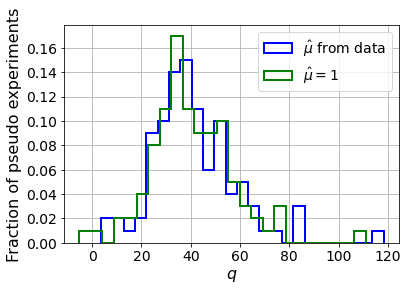

In [91]:
weights = np.ones_like(q_muhat_MLL)/float(len(q_muhat_MLL))
plt.hist(q_muhat_MLL, 25, weights=weights, histtype='step', color='blue', linewidth=2, label=r'$\hat{\mu}$ from data')

weights = np.ones_like(q_muhat_MLL_mu)/float(len(q_muhat_MLL_mu))
plt.hist(q_muhat_MLL_mu, 25, weights=weights, histtype='step', color='green', linewidth=2, label=r'$\hat{\mu}=1$')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q$",fontsize=16)
plt.ylabel("Fraction of pseudo experiments",fontsize=16)
plt.grid()
plt.legend(fontsize=14)

In [93]:
def MLL_test_fast(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, S_expected, num_pseudo, pred_XG_SM,pred_XG_NP):

	# FIND THE SIGNIFICANCE WITH MLL USING THE TEST STATISTIC FORMALISM (gives statistical error) 
	# Inputs:
		# D_or_E -> statistical test. Options: "exclusion" or "discovery"
		# pB_B_data -> array with BACKGROUND PDF evaluated in each BACKGROUND event,   p_B(background),   shape (len(background), )
		# pS_B_data -> array with SIGNAL PDF evaluated in each BACKGROUND event,       p_B(background),   shape (len(background), )
		# pB_S_data -> array with BACKGROUND PDF evaluated in each SIGNAL event,       p_B(background),   shape (len(signal), )
		# pS_S_data -> array with SIGNAL PDF evaluated in each SIGNAL event,           p_B(background),   shape (len(signal), )
		# B_expected -> number of Background events expected in a pseudo experiment
		# S_expected -> number of Signal events expected in a pseudo experiment
		# num_pseudo -> number of pseudo experiments that are used to compute the test statistic distribution
		
	# Outputs:
		# Z_bins -> value of the significance (using mu_hat that fits the data sample)
		# Z_bins_std -> statistical error (1 sigma) of the significance (using mu_hat that fits the data sample)
		# muhat_mean_bins -> mean of the mu_hat computed from the data sample
		# Z_bins_mu -> value of the significance (using a FIXED mu_hat=0 for exclusion, mu_hat=1 for discovery)
		# Z_bins_std_mu -> statistical error (1 sigma) of the significance (using a FIXED mu_hat=0 for exclusion, mu_hat=1 for discovery)
    
    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]

    if D_or_E == 'discovery':
        indices_S = [i for i in range(len(pS_S_data))]
        
        
    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    mu_list = []
    q_list = []
    
    # loop over the number of pseudo experiments
    
    fail_pseudo = 0
    for its in range(num_pseudo):
        
        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)
        pb_ps_B_data = (1 - pred_XG_SM[ran_ind]) / pred_XG_SM[ran_ind]

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)
        
        try:
            if D_or_E == 'exclusion': # only Background events
            
                # p_b(o(x_ensemble)) =  p_b(o(B_ensemble))
                prob_x_given_B = pB_B_data_shuf
    
                # p_s(o(x_ensemble)) =  p_s(o(B_ensemble))
                prob_x_given_S = pS_B_data_shuf
    
                if np.min(prob_x_given_B) == 0:
                    print('There are events with p(s)=0')
                    prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])
    
                # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment
    
                # approximation: mu_hat=0 (exclusion)
                q_muhat_MLL_mu.append( 2 * ( ( (1.-0.) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (0.*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
    
                
                # ESTIMATE mu_hat for this particular ensemble (implicit equation)
                B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
                
                # reference points
                sum_muhat_zero = sum ( [(x*1.) / ( (x * (-0.25) * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
                sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
                
                # we need (implicit eq. for mu_hat) = 1
                # conditions considering the reference points
                if (sum_muhat_zero < sum_muhat_one < 1) or (1 < sum_muhat_one < sum_muhat_zero):
                    
                    muhat_selected_MLL = 1.1
                    
                elif (sum_muhat_one < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_one):
                    
                    muhat_selected_MLL = -0.3
    
                elif sum_muhat_zero < 1 < sum_muhat_one:
                    
                    # grid, mu_hat is around 0
                    muhat_test = np.arange(-0.25, 1., 0.05)
    
                    for vv in range(len(muhat_test)):
    
                        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
                        if mu_hat_condition_equal_1 > 1:
                            muhat_selected_MLL = muhat_test[vv]
                            break
    
                elif sum_muhat_one < 1 < sum_muhat_zero:
                    
                    # grid, mu_hat is around 0
                    muhat_test = np.arange(-0.25, 1., 0.05)
    
                    for vv in range(len(muhat_test)):
    
                        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
                        if mu_hat_condition_equal_1 < 1:
                            muhat_selected_MLL = muhat_test[vv]
                            break
                            
                            
                # save the computed mu_hat (within range) for each pseudo_experiment
                muhat_selected_MLL_list.append(muhat_selected_MLL)
                            
                            
                # compute the test statistic for each pseudo_exp considering mu_hat
                if muhat_selected_MLL > 1:
                    q_muhat_MLL.append( 0 )
    
                elif muhat_selected_MLL > 0:
                    q_muhat_MLL.append( 2 * ( ( (1.-muhat_selected_MLL) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (muhat_selected_MLL*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
    
                else:
                    q_muhat_MLL.append( 2 * ( ( (1.-0.) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (0*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
    
                
                
                
                
    
    
            if D_or_E == 'discovery': # Background and Signal events
                
                # this pseudo-exp has S_rand number of S events
                S_rand = np.random.poisson(int(S_expected))
                
                ran_ind = np.random.choice(indices_S, S_rand)
                pb_ps_S_data = (1 - pred_XG_NP[ran_ind]) / pred_XG_NP[ran_ind]
    
                pB_S_data_shuf = []
                pS_S_data_shuf = []
    
                # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
                for i in ran_ind:
                    pB_S_data_shuf.append(pB_S_data[i])
                    pS_S_data_shuf.append(pS_S_data[i])
    
                pB_S_data_shuf  = np.array(pB_S_data_shuf)
                pS_S_data_shuf  = np.array(pS_S_data_shuf)                
                
                # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
                prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])
    
                # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
                prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])
    
                pb_ps_exp = np.concatenate([pb_ps_B_data, pb_ps_S_data])
                mu = find_mu(pb_ps_exp, S_expected, B_expected)
                if mu < 0: mu = 0
                if mu > 2: mu = 2
                mu_list.append(mu)
                q_list.append(2*(np.sum(np.log( 1 + ( (mu*S_expected/B_expected) / (pb_ps_exp)))) - mu*S_expected))

                if np.min(prob_x_given_B) == 0:
                    print('There are events with p(s)=0')
                    prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])
                    print(np.min(prob_x_given_B))
    
                # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment
    
                # approximation: mu_hat=1 (discovery)
                q_muhat_MLL_mu.append( 2 * ( ( -1. * S_expected) + sum( [np.log( 1 + ( (1.*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
    
                
                
                # ESTIMATE mu_hat for this particular ensemble (implicit equation)
                B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
                
                # reference points
                sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
                sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
                
                # we need (implicit eq. for mu_hat) = 1
                # conditions considering the reference points
                if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
                    
                    muhat_selected_MLL = 2.1
                    
                elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
                    
                    muhat_selected_MLL = -0.1
    
                elif sum_muhat_zero < 1 < sum_muhat_two:
                    
                    # grid, mu_hat is around 1
                    muhat_test = np.arange(0, 2.05, 0.05)
    
                    for vv in range(len(muhat_test)):
    
                        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
                        if mu_hat_condition_equal_1 > 1:
                            muhat_selected_MLL = muhat_test[vv]
                            break
    
                elif sum_muhat_two < 1 < sum_muhat_zero:
                    
                    # grid, mu_hat is around 1
                    muhat_test = np.arange(0, 2.05, 0.05)
    
                    for vv in range(len(muhat_test)):
    
                        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
                        if mu_hat_condition_equal_1 < 1:
                            muhat_selected_MLL = muhat_test[vv]
                            break
                            
                            
                # save the computed mu_hat (within range) for each pseudo_experiment
                if 'muhat_selected_MLL' not in locals():
                    print('muhat2', sum_muhat_two)
                    print('muhat0', sum_muhat_zero)
                muhat_selected_MLL_list.append(muhat_selected_MLL)
                
                
                # compute the test statistic for each pseudo_exp considering mu_hat
                if muhat_selected_MLL > 0:
                    q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * S_expected) + sum( [np.log( 1 + ( (muhat_selected_MLL*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
    
                else:
                    q_muhat_MLL.append( 0 )
        except:
            fail_pseudo += 1
                
            
    print('Ratio of pseudo experiments that do not satisfied the MIN_EVS condition: ', fail_pseudo/num_pseudo)
    # Histogram of q_muhats
    plt.figure(figsize=(7,5))
    
    weights = np.ones_like(q_muhat_MLL)/float(len(q_muhat_MLL))
    plt.hist(q_muhat_MLL, 25, weights=weights, histtype='step', color='blue', linewidth=2, label=r'$\hat{\mu}$ from data')
    
    weights = np.ones_like(q_muhat_MLL_mu)/float(len(q_muhat_MLL_mu))
    if D_or_E == 'exclusion':
        plt.hist(q_muhat_MLL_mu, 25, weights=weights, histtype='step', color='green', linewidth=2, label=r'$\hat{\mu}=0$')
    if D_or_E == 'discovery':
        plt.hist(q_muhat_MLL_mu, 25, weights=weights, histtype='step', color='green', linewidth=2, label=r'$\hat{\mu}=1$')
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q$",fontsize=16)
    plt.ylabel("Fraction of pseudo experiments",fontsize=16)
    plt.grid()
    plt.legend(fontsize=14)
    plt.show()
    
    
    
    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)

    Z_MLL = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)
    
    
    # With the approximation of mu_hat
    Z_MLL_mu = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_std_mu = np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu)
    
    
    return Z_MLL, Z_MLL_std, muhat_mean_MLL, Z_MLL_mu, Z_MLL_std_mu, mu_list, q_list





Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


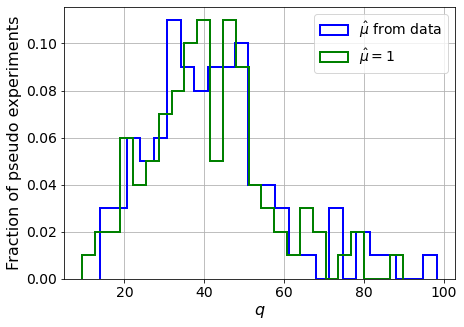

In [94]:
Z_MLL = MLL_test_fast(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, int(S_expected[bp]), num_pseudo = 100,pred_XG_SM=pred_XG_SM,pred_XG_NP=pred_XG_NP)

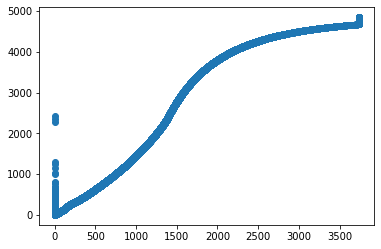

0.5580613340067002
0.10439617397580987
0.10439712693887603


In [81]:
indices_B = [i for i in range(len(pS_B_data))]

indices_S = [i for i in range(len(pS_S_data))]


muhat_selected_MLL_list = []
q_muhat_MLL = []
q_muhat_MLL_mu = []
mu_list = []
q_list = []


# this pseudo-exp has B_rand number of B events
B_rand = np.random.poisson(int(B_expected))

ran_ind = np.random.choice(indices_B, B_rand)
pb_ps_B_data = (1 - pred_XG_SM[ran_ind]) / pred_XG_SM[ran_ind]

pb_ps_B_data[np.where(pb_ps_B_data > 3736.33)[0]] = 3736.337 # To match previous method

pB_B_data_shuf = []
pS_B_data_shuf = []

# for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
for i in ran_ind:
    pB_B_data_shuf.append(pB_B_data[i])
    pS_B_data_shuf.append(pS_B_data[i])

pB_B_data_shuf  = np.array(pB_B_data_shuf)
pS_B_data_shuf  = np.array(pS_B_data_shuf)

# this pseudo-exp has S_rand number of S events
S_rand = np.random.poisson(int(S_expected[bp]))

ran_ind = np.random.choice(indices_S, S_rand)
pb_ps_S_data = (1 - pred_XG_NP[ran_ind]) / pred_XG_NP[ran_ind]

pB_S_data_shuf = []
pS_S_data_shuf = []

# for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
for i in ran_ind:
    pB_S_data_shuf.append(pB_S_data[i])
    pS_S_data_shuf.append(pS_S_data[i])

pB_S_data_shuf  = np.array(pB_S_data_shuf)
pS_S_data_shuf  = np.array(pS_S_data_shuf)


# p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

# p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])

#%pb_ps_exp = prob_x_given_B / prob_x_given_S
pb_ps_exp = np.concatenate([pb_ps_B_data, pb_ps_S_data])

plt.scatter(pb_ps_exp, prob_x_given_B / prob_x_given_S)
#plt.xscale('log')
#plt.yscale('log')
#%fig,ax = plt.subplots(1,2)
#%ax[0].scatter(pb_ps_B_data, pB_B_data_shuf / pS_B_data_shuf)
#%ax[0].set_xscale('log')
#%ax[0].set_yscale('log')
#%#ax[1].plot([0,400],[0,400])
#%ax[1].scatter(pb_ps_S_data, pB_S_data_shuf / pS_S_data_shuf)
#%#ax[1].plot([0,400],[0,400])
plt.show()

mu = find_mu(pb_ps_exp, S_expected[bp], B_expected)
print(mu)
print(find_mu(prob_x_given_B / prob_x_given_S, S_expected[bp], B_expected))
if mu < 0: mu = 0
if mu > 2: mu = 2
mu_list.append(mu)
q_list.append(2*(np.sum(np.log( 1 + ( (mu*S_expected[bp]/B_expected) / (pb_ps_exp)))) - mu*S_expected[bp]))

if np.min(prob_x_given_B) == 0:
    print('There are events with p(s)=0')
    prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])
    print(np.min(prob_x_given_B))

# NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

# approximation: mu_hat=1 (discovery)
q_muhat_MLL_mu.append( 2 * ( ( -1. * S_expected[bp]) + sum( [np.log( 1 + ( (1.*S_expected[bp]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


# compute mu_hat from implicit equation
def f_mu_hat(mu_h, prob_x_given_B=prob_x_given_B, prob_x_given_S=prob_x_given_S):
    return sum ( [x / ( (x * mu_h * S_expected[bp]) + (y * B_expected) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) - 1


muhat_selected_MLL = fsolve(f_mu_hat,1, xtol=1e-2)[0]
print(muhat_selected_MLL)

Text(0, 0.5, 'KDE')

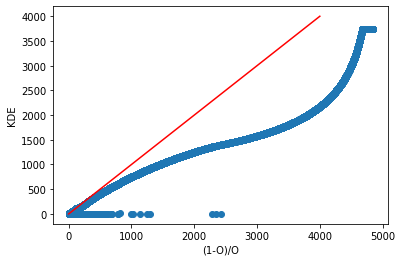

In [82]:
plt.scatter(prob_x_given_B / prob_x_given_S, pb_ps_exp)
#plt.xscale('log')
#plt.yscale('log')
plt.plot([1e-3,4e3],[1e-3,4e3],c = 'red')
plt.xlabel('(1-O)/O')
plt.ylabel('KDE')
#plt.savefig('../graph/comparison_KDE.pdf')

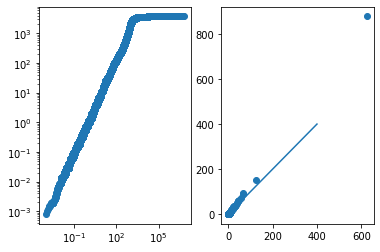

In [189]:
fig,ax = plt.subplots(1,2)

ax[0].scatter((1-pred_XG_SM)/pred_XG_SM, pB_B_data / pS_B_data)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
#ax[1].plot([0,400],[0,400])
ax[1].scatter((1-pred_XG_NP)/pred_XG_NP, pB_S_data / pS_S_data)
ax[1].plot([0,400],[0,400])

In [190]:
print(Z_MLL[0], Z_MLL[1])

5.3811970408441665 1.2407660614726699


In [191]:
print(abs( np.median(Z_MLL[8]) )**0.5)

2.693032119628668


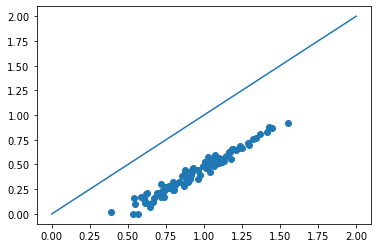

In [192]:
plt.scatter(Z_MLL[5], Z_MLL[7])
plt.plot([0,2],[0,2])

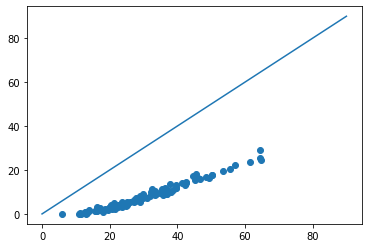

In [193]:
plt.scatter(Z_MLL[6], Z_MLL[8])
plt.plot([0,90],[0,90])

In [118]:
pb_ps_B_data = (1 - pred_XG_SM) / pred_XG_SM
pb_ps_S_data = (1 - pred_XG_NP) / pred_XG_NP

pb_ps_B_data[np.where(pb_ps_B_data > 3736.33)[0]] = 3736.337

In [116]:
np.max(pB_B_data / pS_B_data)

3736.337703153999

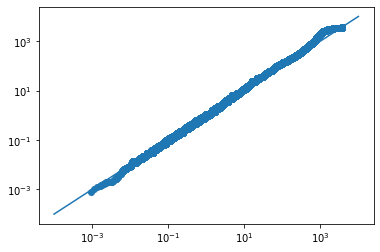

In [119]:
fig,ax = plt.subplots(1,1)

ax.scatter(pb_ps_B_data, pB_B_data / pS_B_data)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim(1e-4,1e4)
#ax.set_ylim(1e-4,1e4)
ax.plot([1e-4,1e4], [1e-4,1e4])



In [122]:
start = time.time()

D_or_E = "discovery"

indices_B = np.arange(len(pS_B_data))
indices_S = np.arange(len(pS_S_data))

Z_MLL_BPs_new = np.ones(8) * (-99)
Z_MLL_std_BPs_new = np.ones(8) * (-99)
BPS_analyzed = [0,1,2,3,4,5,6,7]

for bp in BPS_analyzed:
    pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == (bp+1))[0]]
    BP_indices = np.random.choice(np.arange(len(pred_XG_NP)), size = 10000, replace = False)
    pred_XG_NP = pred_XG_NP[BP_indices]

    print(str(bp) + ':' + str(len(pred_XG_NP)))
    # FOR DISCOVERY:
    # we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS
    mu_list = []
    q_list = []
    for its in range(100):
        B_rand = np.random.poisson(int(B_expected))
        ran_ind = np.random.choice(indices_B, B_rand)
        pb_ps_B_data = (1 - pred_XG_SM[ran_ind]) / pred_XG_SM[ran_ind]

        pb_ps_B_data[np.where(pb_ps_B_data > 3736.33)[0]] = 3736.337 # To match previous method

        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)
        pb_ps_S_data = (1 - pred_XG_NP[ran_ind]) / pred_XG_NP[ran_ind]

        pb_ps_exp = np.concatenate([pb_ps_B_data, pb_ps_S_data])
        
        mu = find_mu(pb_ps_exp, S_expected[bp], B_expected)
        if mu < 0: mu = 0
        if mu > 2: mu = 2
        mu_list.append(mu)
        q_list.append(2*(np.sum(np.log( 1 + ( (mu*S_expected[bp]/B_expected) / (pb_ps_exp)))) - mu*S_expected[bp]))


    
    Z_MLL_aux = abs( np.median(q_list) )**0.5
    Z_MLL_std_aux = np.std(q_list) / (2.*Z_MLL_aux)
    Z_MLL_BPs_new[bp] = Z_MLL_aux
    Z_MLL_std_BPs_new[bp] = Z_MLL_std_aux
    
    print('BP' + str(bp+1))
    print('muhat mean: ', np.mean(mu_list))
    print('Z_MLL: ', Z_MLL_aux)
    print('std Z_MLL: ', Z_MLL_std_aux)
    print('')
    print('--------\n')
    
stop = time.time()
print(f'Last {(stop-start)/60} minutes to perform the MLL')

0:10000
BP1
muhat mean:  0.5442385047467352
Z_MLL:  6.109123444572321
std Z_MLL:  1.2123884367551674

--------

1:10000
BP2
muhat mean:  0.3214808589536529
Z_MLL:  3.6939276760846163
std Z_MLL:  1.1017282297370747

--------

2:10000
BP3
muhat mean:  0.0974402414695244
Z_MLL:  0.18822815395286005
std Z_MLL:  4.5450778118234725

--------

3:10000
BP4
muhat mean:  0.3823396975331739
Z_MLL:  2.6417028317976627
std Z_MLL:  1.0201257683993008

--------

4:10000
BP5
muhat mean:  0.10804492916927216
Z_MLL:  0.06299995003594464
std Z_MLL:  10.900230841905575

--------

5:10000
BP6
muhat mean:  0.3645914169005714
Z_MLL:  1.617844385175915
std Z_MLL:  1.2889051380132766

--------

6:10000


/tmp/ipykernel_1817670/256691188.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std_aux = np.std(q_list) / (2.*Z_MLL_aux)


BP7
muhat mean:  0.03924409566239821
Z_MLL:  0.0
std Z_MLL:  inf

--------

7:10000
BP8
muhat mean:  0.20397367896242258
Z_MLL:  0.1450419818870122
std Z_MLL:  5.654111573570895

--------

Last 0.07608150641123454 minutes to perform the MLL


(0.0, 20.0)

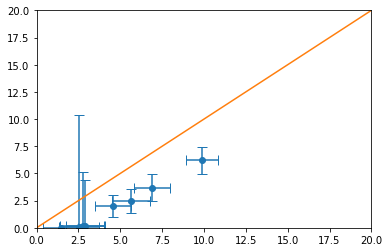

In [120]:
plt.errorbar(Z_MLL_BPs, Z_MLL_BPs_new, xerr=Z_MLL_std_BPs, yerr=Z_MLL_std_BPs_new, fmt='o', capsize=5)
plt.plot([0,20],[0,20])
plt.xlim(0,20)
plt.ylim(0,20)

In [112]:
print(np.min(pB_B_data))
pB_B_data[np.where(pB_B_data == 0 )[0]] = np.min(pB_B_data[np.where(pB_B_data > 0 )[0]])
pS_B_data[np.where(pS_B_data == 0 )[0]] = np.min(pS_B_data[np.where(pS_B_data > 0 )[0]])
print(np.min(pB_B_data))

0.012822047002307902
0.012822047002307902


In [154]:
pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == 1)[0]]
BP_indices = np.random.choice(np.arange(len(pred_XG_NP)), size = 10000, replace = False)
pred_XG_NP = pred_XG_NP[BP_indices]

In [155]:
pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
print('3 done')
pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
print('4 done')

# Normalize
pB_S_data = pB_S_data / norm_factor_SM
pS_S_data = pS_S_data / norm_factor_NP

print(np.min(pB_S_data))
pB_S_data[np.where(pB_S_data == 0 )[0]] = np.min(pB_S_data[np.where(pB_S_data > 0 )[0]])
pS_S_data[np.where(pS_S_data == 0 )[0]] = np.min(pS_S_data[np.where(pS_S_data > 0 )[0]])
print(np.min(pB_S_data))

3 done
4 done
0.001973469036674877
0.001973469036674877


In [156]:
pb_ps_S_data = (1 - pred_XG_NP) / pred_XG_NP

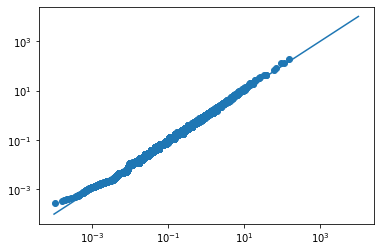

In [157]:
plt.scatter(pb_ps_S_data, pB_S_data / pS_S_data)
plt.yscale('log')
plt.xscale('log')
#plt.xlim(1e-4,1e4)
#plt.ylim(1e-4,1e4)
plt.plot([1e-4,1e4], [1e-4,1e4])

In [132]:
indices_B = np.arange(len(pS_B_data))
indices_S = np.arange(len(pS_S_data))

In [147]:
S_expected = S_expected[0]

In [184]:
mu_list = []
q_muhat_new_list = []

q_muhat_MLL_mu_aprox_list = []

muhat_MLL_list = []
q_muhat_MLL_list = []
for its in tqdm(range(100)):
    # this pseudo-exp has B_rand number of B events
    B_rand = np.random.poisson(int(B_expected))

    ran_ind = np.random.choice(indices_B, B_rand)
    pb_ps_B_data = (1 - pred_XG_SM[ran_ind]) / pred_XG_SM[ran_ind]

    pB_B_data_shuf  = pB_B_data[ran_ind]
    pS_B_data_shuf  = pS_B_data[ran_ind]

    # this pseudo-exp has S_rand number of S events
    S_rand = np.random.poisson(int(S_expected))

    ran_ind = np.random.choice(indices_S, S_rand)
    pb_ps_S_data = (1 - pred_XG_NP[ran_ind]) / pred_XG_NP[ran_ind]

    pB_S_data_shuf  = pB_S_data[ran_ind]
    pS_S_data_shuf  = pS_S_data[ran_ind]

    # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
    prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

    # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
    prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])

    pb_ps_exp = np.concatenate([pb_ps_B_data, pb_ps_S_data])
    if np.min(prob_x_given_B) == 0:
        print('There are events with p(s)=0')
        prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])
        print(np.min(prob_x_given_B))

    # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment
    
    mu = find_mu(pb_ps_exp, S_expected, B_expected)
    mu_list.append(mu)
    #%print("Valor de mu:", mu)

    q_muhat_new =  2*(np.sum(np.log( 1 + ( (mu*S_expected/B_expected) / (pb_ps_exp)))) - mu*S_expected)
    #%print(q_muhat_new)
    q_muhat_new_list.append(q_muhat_new)
    
    # approximation: mu_hat=1 (discovery)
    q_muhat_MLL_mu_aprox = 2 * ( ( -1. * S_expected) + sum( [np.log( 1 + ( (1.*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) 
    q_muhat_MLL_mu_aprox_list.append(q_muhat_MLL_mu_aprox)
    #%print(q_muhat_MLL_mu_aprox)
    
    # ESTIMATE mu_hat for this particular ensemble (implicit equation)
    B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

    # reference points
    sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


    # we need (implicit eq. for mu_hat) = 1
    # conditions considering the reference points
    if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):

        muhat_selected_MLL = 2.1

    elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):

        muhat_selected_MLL = -0.1

    elif sum_muhat_zero < 1 < sum_muhat_two:

        # grid, mu_hat is around 1
        muhat_test = np.arange(0, 2.05, 0.05)

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            if mu_hat_condition_equal_1 > 1:
                muhat_selected_MLL = muhat_test[vv]
                break

    elif sum_muhat_two < 1 < sum_muhat_zero:

        # grid, mu_hat is around 1
        muhat_test = np.arange(0, 2.05, 0.05)

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            if mu_hat_condition_equal_1 < 1:
                muhat_selected_MLL = muhat_test[vv]
                break


    # save the computed mu_hat (within range) for each pseudo_experiment

    #%print('muhat0', muhat_selected_MLL)
    muhat_MLL_list.append(muhat_selected_MLL)


    # compute the test statistic for each pseudo_exp considering mu_hat
    q_muhat_MLL =  2 * ( (-1.*muhat_selected_MLL * S_expected) + sum( [np.log( 1 + ( (muhat_selected_MLL*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) )
    #%print(q_muhat_MLL)
    q_muhat_MLL_list.append(q_muhat_MLL)


In [185]:
muhat_mean_MLL = np.mean(muhat_MLL_list)

Z_MLL = abs( np.median(q_muhat_MLL_list) )**0.5
Z_MLL_std = np.std(q_muhat_MLL_list) / (2.*Z_MLL)
print(f'ZMLL: {Z_MLL} $\pm$ {Z_MLL_std} ')

muhat_mean_MLL = np.mean(mu_list)

Z_MLL = abs( np.median(q_muhat_new_list) )**0.5
Z_MLL_std = np.std(q_muhat_new_list) / (2.*Z_MLL)
print(f'Z new: {Z_MLL} $\pm$ {Z_MLL_std} ')

ZMLL: 9.317668003149484 $\pm$ 1.147704000162548 
Z new: 6.447860629854573 $\pm$ 1.163543629839523 


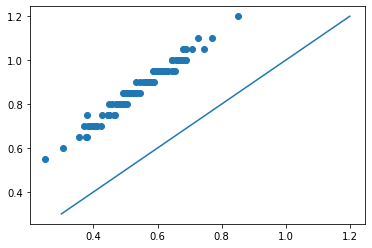

In [186]:
plt.scatter(mu_list, muhat_MLL_list)
plt.plot([0.3,1.2],[0.3,1.2])

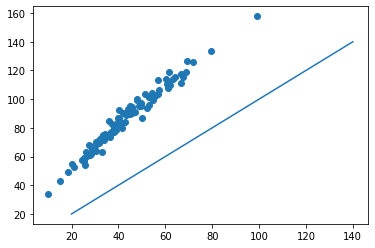

In [187]:
plt.scatter(q_muhat_new_list, q_muhat_MLL_list)
plt.plot([20,140],[20,140])

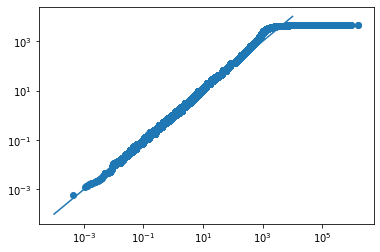

In [160]:
plt.scatter(pb_ps_exp, prob_x_given_B/prob_x_given_S)
plt.yscale('log')
plt.xscale('log')
#plt.xlim(1e-4,1e4)
#plt.ylim(1e-4,1e4)
plt.plot([1e-4,1e4], [1e-4,1e4])

In [172]:
mu = find_mu(pb_ps_exp, S_expected, B_expected)
print("Valor de mu:", mu)

q_muhat_new =  2*(np.sum(np.log( 1 + ( (mu*S_expected/B_expected) / (pb_ps_exp)))) - mu*S_expected)
print(q_muhat_new)

Valor de mu: 0.44645641239308653
24.166161124378277


In [173]:
# approximation: mu_hat=1 (discovery)
q_muhat_MLL_mu_aprox = 2 * ( ( -1. * S_expected) + sum( [np.log( 1 + ( (1.*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) 
print(q_muhat_MLL_mu_aprox)

59.967517429790405


In [163]:
# ESTIMATE mu_hat for this particular ensemble (implicit equation)
B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

# reference points
sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


# we need (implicit eq. for mu_hat) = 1
# conditions considering the reference points
if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):

    muhat_selected_MLL = 2.1

elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):

    muhat_selected_MLL = -0.1

elif sum_muhat_zero < 1 < sum_muhat_two:

    # grid, mu_hat is around 1
    muhat_test = np.arange(0, 2.05, 0.05)

    for vv in range(len(muhat_test)):

        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        if mu_hat_condition_equal_1 > 1:
            muhat_selected_MLL = muhat_test[vv]
            break

elif sum_muhat_two < 1 < sum_muhat_zero:

    # grid, mu_hat is around 1
    muhat_test = np.arange(0, 2.05, 0.05)

    for vv in range(len(muhat_test)):

        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        if mu_hat_condition_equal_1 < 1:
            muhat_selected_MLL = muhat_test[vv]
            break


# save the computed mu_hat (within range) for each pseudo_experiment

print('muhat2', sum_muhat_two)
print('muhat0', sum_muhat_zero)
print(muhat_selected_MLL)


# compute the test statistic for each pseudo_exp considering mu_hat
q_muhat_MLL =  2 * ( (-1.*muhat_selected_MLL * S_expected) + sum( [np.log( 1 + ( (muhat_selected_MLL*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) )
print(q_muhat_MLL)

                

muhat2 0.8961234816352464
muhat0 1.1638868810727716
0.8
63.66409979037803


0:10000
3 done
4 done
0.001721028958048736
0.001721028958048736
B_expected:  147986
S_expected:  641

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


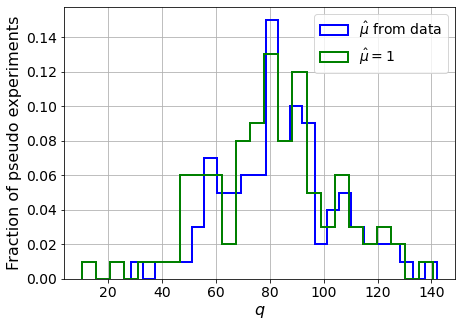

BP1
muhat mean:  0.8634999999999999
Z_MLL:  9.096951076680819
std Z_MLL:  1.138374475447136
Z_MLL mu=1:  8.980095994461541
std Z_MLL mu=1:  1.306797849416438

--------

1:10000
3 done
4 done
0.002030144740528514
0.002030144740528514
B_expected:  147986
S_expected:  582

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


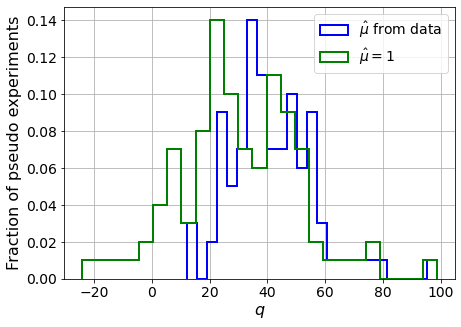

BP2
muhat mean:  0.6470000000000001
Z_MLL:  6.2861269460759335
std Z_MLL:  1.1457998889842997
Z_MLL mu=1:  5.414980994687844
std Z_MLL mu=1:  1.9011878352246527

--------

4:10000
3 done
4 done
0.002073417992791542
0.002073417992791542
B_expected:  147986
S_expected:  177

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


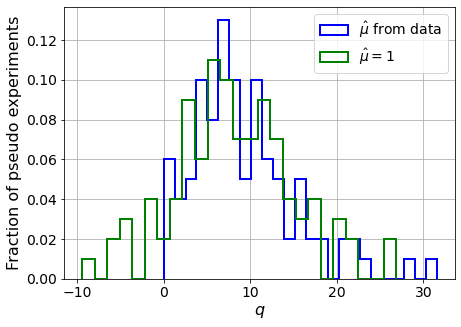

BP5
muhat mean:  0.853
Z_MLL:  2.8424321835072397
std Z_MLL:  1.0670429437461688
Z_MLL mu=1:  2.780341210288127
std Z_MLL mu=1:  1.2305447476669242

--------

7:10000
3 done
4 done
0.001864271943901527
0.001864271943901527
B_expected:  147986
S_expected:  107

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


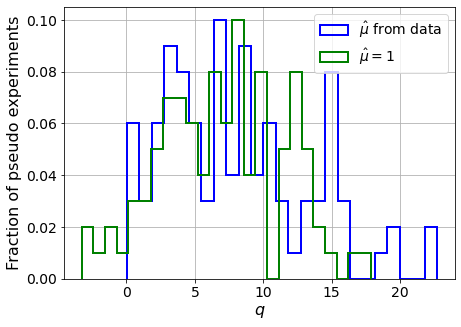

BP8
muhat mean:  1.241
Z_MLL:  2.687331059577332
std Z_MLL:  0.9798436365439029
Z_MLL mu=1:  2.657345857927333
std Z_MLL mu=1:  0.8466127214984356

--------



ValueError: 'a' cannot be empty unless no samples are taken

## Plotting results

In [14]:

from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from scipy.interpolate import SmoothBivariateSpline
# BENCHMARK POINTS DATA

mchi1 = np.array([133.6, 141. , 147.5, 152.7, 143.2, 151.7, 156.1, 161.9, 168.9,
       153.7, 160.5, 174.5, 180.6, 152.3, 162.2, 176.6, 185.1, 190.6,
       169.1, 179.8, 184.3, 194.7, 200.5, 179.1, 188.6, 193.3, 201.3,
       205.9, 210.5, 197.5, 205.8, 210.7, 215.7, 218.9, 213.3, 218.5,
       223.7, 228.8, 222.5, 227.9, 235.1, 240.3, 235.4, 239.2, 244.8,
       250.3, 244.8, 250.6, 254.5, 258.3, 262.1, 252.1, 256.1, 260.2,
       264.2, 268.2, 265.5, 271.8, 276. , 280.1])

mchi2 = np.array([158.5, 158.5, 158.5, 158.5, 173.8, 173.8, 173.8, 173.8, 173.8,
       184. , 184. , 184. , 184. , 194.2, 194.2, 194.2, 194.2, 194.2,
       204.4, 204.4, 204.4, 204.4, 204.4, 214.5, 214.5, 214.5, 214.5,
       214.5, 214.5, 224.7, 224.7, 224.7, 224.7, 224.7, 234.8, 234.8,
       234.8, 234.8, 245. , 245. , 245. , 245. , 255.1, 255.1, 255.1,
       255.1, 265.2, 265.2, 265.2, 265.2, 265.2, 275.3, 275.3, 275.3,
       275.3, 275.3, 285.4, 285.4, 285.4, 285.4])

sigma_SI = np.array([2.50e-49, 6.50e-49, 1.30e-48, 2.26e-48, 2.20e-49, 6.20e-49,
       9.90e-49, 1.92e-48, 3.99e-48, 3.95e-49, 7.30e-49, 2.76e-48,
       5.10e-48, 2.25e-49, 4.70e-49, 1.50e-48, 3.40e-48, 5.60e-48,
       4.70e-49, 9.70e-49, 1.40e-48, 3.50e-48, 5.96e-48, 5.50e-49,
       1.00e-48, 1.40e-48, 2.70e-48, 4.10e-48, 6.30e-48, 1.00e-48,
       1.80e-48, 2.70e-48, 4.10e-48, 5.60e-48, 1.60e-48, 2.30e-48,
       3.60e-48, 5.70e-48, 1.60e-48, 2.30e-48, 4.20e-48, 6.80e-48,
       2.02e-48, 2.64e-48, 4.20e-48, 6.70e-48, 2.00e-48, 3.00e-48,
       4.10e-48, 5.80e-48, 8.10e-48, 1.70e-48, 2.20e-48, 3.00e-48,
       4.10e-48, 5.80e-48, 2.20e-48, 3.40e-48, 4.80e-48, 7.00e-48])

relic = np.array([7.50e+00, 9.00e-01, 1.00e-02, 2.80e-02, 1.38e+01, 2.96e+00,
       5.50e-01, 1.10e-01, 2.44e-02, 1.16e+01, 3.45e+00, 7.00e-02,
       1.80e-02, 5.33e+01, 1.35e+01, 3.60e-01, 5.80e-02, 2.00e-02,
       1.88e+01, 2.70e+00, 5.60e-01, 6.35e-02, 2.00e-02, 1.67e+01,
       2.85e+00, 6.20e-01, 1.20e-01, 5.20e-02, 2.30e-02, 3.10e+00,
       3.40e-01, 1.34e-01, 5.70e-02, 3.30e-02, 4.70e-01, 1.90e-01,
       8.10e-02, 8.10e-02, 5.10e-01, 2.10e-01, 7.00e-02, 3.00e-02,
       3.00e-01, 1.70e-01, 7.00e-02, 3.00e-02, 3.20e-01, 1.30e-01,
       7.70e-02, 4.50e-02, 2.60e-02, 4.70e-01, 2.60e-01, 1.40e-01,
       8.30e-02, 4.80e-02, 2.70e-01, 1.17e-01, 6.70e-02, 4.00e-02])

################
# NEUTRINO FOG # (https://arxiv.org/pdf/2109.03116)
################

# m[GeV]     SI DM-nuecleon cross-section [cm**2]
nufog = np.array([[1.00000000e-01, 3.92570544e-45],
       [1.40819255e-01, 7.58827590e-45],
       [1.78947432e-01, 1.37323851e-44],
       [2.27399183e-01, 2.56838490e-44],
       [3.46847646e-01, 4.80368189e-44],
       [4.61342841e-01, 6.25265405e-44],
       [5.47463043e-01, 6.04996874e-44],
       [6.27797560e-01, 5.13093815e-44],
       [7.28181836e-01, 3.45510729e-44],
       [9.04466462e-01, 1.09035290e-44],
       [1.08562264e+00, 4.19314857e-45],
       [1.37956548e+00, 1.66657433e-45],
       [1.69410196e+00, 1.12224956e-45],
       [2.22776398e+00, 1.01661294e-45],
       [3.03155195e+00, 1.19870409e-45],
       [4.31799821e+00, 1.41341057e-45],
       [5.42488437e+00, 1.36759362e-45],
       [6.43756321e+00, 9.51772374e-46],
       [7.13378669e+00, 5.08884195e-46],
       [7.63928174e+00, 2.16035906e-46],
       [7.63928174e+00, 6.38276632e-47],
       [9.06532854e+00, 9.75588219e-48],
       [1.16520510e+01, 1.70125428e-48],
       [1.48069567e+01, 6.33039963e-49],
       [1.81828951e+01, 4.26280911e-49],
       [2.33712458e+01, 3.61525999e-49],
       [3.25378238e+01, 3.61525999e-49],
       [5.69119114e+01, 4.26280911e-49],
       [1.16786719e+02, 6.76166526e-49],
       [2.47999012e+02, 1.26464258e-48],
       [6.32110296e+02, 3.07873347e-48],
       [1.40498265e+03, 6.56948471e-48],
       [3.70578381e+03, 1.76550686e-47],
       [1.00000000e+04, 4.59088320e-47]])

# INTERPOLATE THE NEUTRINO FOG
sigma_nufog = interp1d(nufog[:,0], nufog[:,1], bounds_error=False, fill_value="extrapolate")



# PLOT
m_range = np.logspace(-1, 4, 100)
nufog_cross = [sigma_nufog(m) for m in m_range]

##################################
# BPs Effective SI cross section # (considering the relic density)
##################################

# sigma_eff = sigma_SI * (relic / 0.12)
sigma_eff = np.zeros(len(relic))

for i_rel in range(len(relic)):
    if relic[i_rel] > 0.12:
        sigma_eff[i_rel] = sigma_SI[i_rel]
    else:
        sigma_eff[i_rel] = sigma_SI[i_rel] * (relic[i_rel] / 0.12)
        
        
#########################
# CONTOUR PLOTS, LEVELS # (compare BPs cross section with neutrino fog)
#########################

x = mchi2            # x axis
y = mchi2 - mchi1    # y axis
# z is the BP cross-section - nu fog cross section. We want level z=0
z = np.log10(sigma_eff) - np.log10(sigma_nufog(mchi1)) # log diff, easier to interpolate


# Grid to interpolate
xi = np.linspace(150, 300, 300)
yi = np.linspace(3, 45, 300)
xi, yi = np.meshgrid(xi, yi)

# Interpolate
zi_nufog = griddata((x, y), z, (xi, yi), method='cubic')



##########
# SMOOTH #
##########

# let's smooth it with spline
spline = SmoothBivariateSpline(x, y, z, s=0.25)  # parameter s controls the smoothness
zi_nufog_smooth = spline.ev(xi, yi)

zi_nufog_smooth[(xi < 170) & (yi < 5)] = np.min(zi_nufog_smooth)


In [15]:
ATLAS = np.loadtxt('../../susyatLHC/data/LHC/ATLAS.txt')
CMS   = np.loadtxt('../../susyatLHC/data/LHC/CMS.txt')
DD_bounds = np.loadtxt('../../susyatLHC/data/dd_bound.csv', delimiter=',')

In [16]:
mx01_new = np.linspace(140, 300, 30)
mx02_new = np.linspace(140, 310, 30)
mx03_new = np.linspace(140, 320, 30)
mx1_new  = np.linspace(140, 320, 30)

deltam_new = np.linspace(1,55,30)

In [17]:
# Bps
mx01 = np.asarray(bps_data['m_x01'])# np.asarray([151.8, 146.9, 178.2, 187.9, 232.9, 241.9, 282.9, 291.9])
mx02 = np.asarray(bps_data['m_x02'])# np.asarray([163.6, 163.6, 199.6, 199.6, 253.3, 255.1, 305.5, 305.5])
mx03 = np.asarray(bps_data['m_x03'])# np.asarray([170.1, 170.0, 205.6, 205.6, 262.5, 262.0, 312.8, 312.8])
mx1  = np.asarray(bps_data['m_x1'])# np.asarray([167.0, 167.0, 205.8, 205.8, 259.1, 259.1, 310.0, 310.0])

deltam = np.abs(mx02 - mx01)

In [18]:
dm_rd = np.asarray(bps_data['om_DM'])
tck_DM   = interpolate.bisplrep(mx02, deltam, dm_rd, kx = 2, ky = 2)
DM_new = interpolate.bisplev(mx02_new, deltam_new, tck_DM)

i = 0
deltam_min = []
deltam_max = []
dm0_new = []

mx02_bins = np.linspace(140, 310, 6)
ind = np.digitize(mx02, mx02_bins) - 1
deltam_new0 = np.linspace(10,17,10)

for i in range(len(mx02_bins)):
    try:
        aux_ind = np.where(ind == i)[0]
        tck_dm = interpolate.interp1d(x = deltam[aux_ind], y = dm_rd[aux_ind], kind = 'linear', fill_value='extrapolate')
        aux = tck_dm(deltam_new0)
        deltam_min.append( deltam_new0[np.argmin(np.abs(aux - 0.10))] )
        deltam_max.append( deltam_new0[np.argmin(np.abs(aux - 0.14))] )
        dm0_new.append( mx02_bins[i] + (mx02_bins[1] - mx02_bins[0])/2 )
    except:
        pass

In [19]:
tck_dm_min = interpolate.interp1d(x = dm0_new, y = deltam_min, kind = 'linear', fill_value='extrapolate')
tck_dm_max = interpolate.interp1d(x = dm0_new, y = deltam_max, kind = 'linear', fill_value='extrapolate')

dm0_new = np.linspace(140, 310, 20)
deltam_min = tck_dm_min(dm0_new)
deltam_max = tck_dm_max(dm0_new)

In [20]:
bps_data.columns

Index(['BP', 'm_x01', 'm_x02', 'm_x03', 'm_x1', 'BR_x02_x01', 'BR_x03_x02',
       'BR_x1_x01W', 'sigma_x1_x02', 'sigma_x1_x03', 'sigma_DD', 'om_DM'],
      dtype='object')

In [21]:
Z_BL          = np.mean(np.load('../data/models/Z_BL_MET100_BPI.npy'), axis = 0)
Z_BL_std      = np.nan_to_num(np.mean(np.load('../data/models/Z_BL_std_MET100_BPI.npy'), axis = 0), posinf=2)

Z_MLL         = np.mean(np.load('../data/models/Z_MLL_MET100_BPI.npy'), axis = 0)
Z_MLL_std     = np.nan_to_num(np.mean(np.load('../data/models/Z_MLL_std_MET100_BPI.npy'), axis = 0), posinf=2)

Z_MLL_new     = np.mean(np.load('../data/models/Z_MLL_new_MET100_BPI.npy'), axis = 0)
Z_MLL_new_std = np.mean(np.load('../data/models/Z_MLL_new_std_MET100_BPI.npy'), axis = 0)

#Z_SBC         = np.mean(np.load('../data/models/Z_sbc_MET100_BPI.npy')[10:,:], axis = 0)
#Z_SBC_std     = np.mean(np.load('../data/models/Z_sbc_std_MET100_BPI.npy')[10:,:], axis = 0)

In [22]:
S_expected = np.zeros(60)
for i in range(60):
    S_expected[i] = results[bps_data['BP'][i]]['pptox1n2']['#Signal_expected'] + results[bps_data['BP'][i]]['pptox1n3']['#Signal_expected'] 
Z_base = S_expected / np.sqrt(B_expected)

NameError: name 'results' is not defined

In [23]:
dm_planck = 0.12
sd_planck = 0.02

In [24]:
tck_BL   = interpolate.bisplrep(mx02, deltam, Z_BL, kx = 4, ky = 4)
Z_BL_new = interpolate.bisplev(mx02_new, deltam_new, tck_BL)
tck_BL_max   = interpolate.bisplrep(mx02, deltam, (Z_BL + Z_BL_std), kx = 4, ky = 4)
Z_BL_new_max = interpolate.bisplev(mx02_new, deltam_new, tck_BL_max)
tck_BL_min   = interpolate.bisplrep(mx02, deltam, (Z_BL - Z_BL_std), kx = 4, ky = 4)
Z_BL_new_min = interpolate.bisplev(mx02_new, deltam_new, tck_BL_min)

tck_MLL   = interpolate.bisplrep(mx02, deltam, Z_MLL, kx = 4, ky = 4)
Z_MLL_new = interpolate.bisplev(mx02_new, deltam_new, tck_MLL)
tck_MLL_max   = interpolate.bisplrep(mx02, deltam, (Z_MLL + Z_MLL_std), kx = 4, ky = 4)
Z_MLL_new_max = interpolate.bisplev(mx02_new, deltam_new, tck_MLL_max)
tck_MLL_min   = interpolate.bisplrep(mx02, deltam, (Z_MLL - Z_MLL_std), kx = 4, ky = 4)
Z_MLL_new_min = interpolate.bisplev(mx02_new, deltam_new, tck_MLL_min)

#tck_SBC   = interpolate.bisplrep(mx02, deltam, Z_SBC, kx = 1, ky = 1)
#Z_SBC_new = interpolate.bisplev(mx02_new, deltam_new, tck_SBC)
#tck_SBC_max   = interpolate.bisplrep(mx02, deltam, (Z_SBC + Z_SBC_std), kx = 1, ky = 1)
#Z_SBC_new_max = interpolate.bisplev(mx02_new, deltam_new, tck_SBC_max)
#tck_SBC_min   = interpolate.bisplrep(mx02, deltam, (Z_SBC - Z_SBC_std), kx = 1, ky = 1)
#Z_SBC_new_min = interpolate.bisplev(mx02_new, deltam_new, tck_SBC_min)

tck_base   = interpolate.bisplrep(mx02, deltam, S_expected, kx = 1, ky = 1)
Z_base_new = interpolate.bisplev(mx02_new, deltam_new, tck_base)

In [25]:
from matplotlib.lines import Line2D

In [26]:
norm = mpl.colors.Normalize(vmin=Z_MLL.min(), vmax=Z_MLL.max())

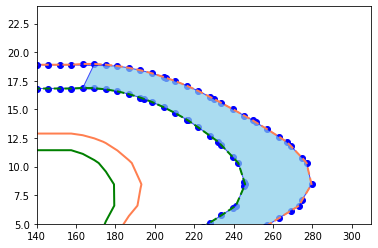

In [137]:
fig,ax = plt.subplots(1,1)

c0 = ax.contour(mx02_new, deltam_new, Z_BL_new.T, levels = [-100,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2], alpha = 1)
#cM = ax.contour(mx02_new, deltam_new, Z_BL_new_max.T, levels = [0,2,5,16], 
#            linestyles = ['dotted','dashed', 'solid'], colors = ['magenta'], linewidths = [2], alpha = 1)
cm = ax.contour(mx02_new, deltam_new, Z_BL_new_min.T, levels = [-1000,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['green'], linewidths = [2], alpha = 1)

aux_ind = np.where(c0.allsegs[1][0][:,1] > 0)[0]

plt.scatter(c0.allsegs[1][0][aux_ind,0], c0.allsegs[1][0][aux_ind,1], color = 'blue')
plt.scatter(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], color = 'blue')
f0 = interp1d(c0.allsegs[1][0][aux_ind,0], c0.allsegs[1][0][aux_ind,1], fill_value = 'extrapolate')
#fM = interp1d(cM.allsegs[1][0][:,0], cM.allsegs[1][0][:,1], fill_value = 'extrapolate')
aux_ind = np.where(cm.allsegs[1][0][:,1] > 0)[0]

fm = interp1d(cm.allsegs[1][0][aux_ind,0], cm.allsegs[1][0][aux_ind,1], fill_value = 'extrapolate')
aux_ind = np.where(f0(mx02_new) > 0)[0]
#ax.fill_between(mx02_new[aux_ind], f0(mx02_new[aux_ind]), fm(mx02_new[aux_ind]), facecolor ='none', hatch ='-', edgecolor = 'coral', alpha = 1, lw = 2)
ax.set_ylim(5,24)

y1 = c0.allsegs[1][0][:,1]
aux_ind = np.argsort(y1)
y1 = y1[aux_ind]
x1 = c0.allsegs[1][0][aux_ind,0]
y2 = cm.allsegs[1][0][:,1]
aux_ind = np.argsort(y2)
y2 = y2[aux_ind]
x2 = cm.allsegs[1][0][aux_ind,0]
x = np.concatenate([x1, x2[::-1]])
y = np.concatenate([y1, y2[::-1]])
ax.fill(x, y, color='skyblue', alpha=0.7, edgecolor='blue')

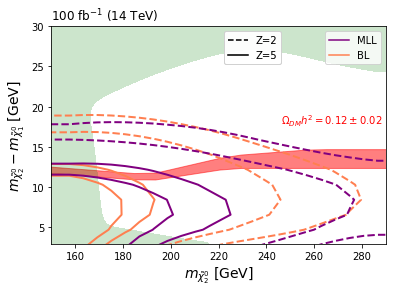

In [33]:
fig,ax = plt.subplots(1,1)

MLL_color = mcolors.to_rgb('purple')

#%c0 = ax.contour(mx02_new, deltam_new, Z_SBC_new.T, levels = [-1,2,5,16], 
#%            linestyles = ['dotted','dashed', 'solid'], colors = ['darkcyan'], linewidths = [2], alpha = 1, zorder = 4)
#%cm = ax.contour(mx02_new, deltam_new, Z_SBC_new_min.T, levels = [0,2,5,16], 
#%            linestyles = ['dotted','dashed', 'solid'], colors = ['darkcyan'], linewidths = [2], alpha = 0, zorder = 4)

#%f0 = interp1d(c0.allsegs[1][0][:,0], c0.allsegs[1][0][:,1], fill_value = 'extrapolate')
#%fm = interp1d(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], fill_value = 'extrapolate')
#%ax.fill_between(mx02_new, fm(mx02_new), f0(mx02_new), facecolor ='none', hatch = '|', edgecolor = 'darkcyan', alpha = 1, linewidth = 2, linestyle = '--', zorder = 4)

c0 = ax.contour(mx02_new, deltam_new, Z_BL_new.T, levels = [-100,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2], alpha = 1)
#cM = ax.contour(mx02_new, deltam_new, Z_BL_new_max.T, levels = [0,2,5,16], 
#            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2], alpha = 0)
cm = ax.contour(mx02_new, deltam_new, Z_BL_new_min.T, levels = [-1000,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2], alpha = 1)

f0 = interp1d(c0.allsegs[2][0][:,0], c0.allsegs[2][0][:,1], fill_value = 'extrapolate')
#fM = interp1d(cM.allsegs[2][0][:,0], cM.allsegs[2][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[2][0][:,0], cm.allsegs[2][0][:,1], fill_value = 'extrapolate')
#ax.fill_between(mx02_new, fm(mx02_new), f0(mx02_new), facecolor ='none', hatch ='-', edgecolor = 'coral', alpha = 1, lw = 2)

#%f0 = interp1d(c0.allsegs[1][0][:,0], c0.allsegs[1][0][:,1], fill_value = 'extrapolate')
#%fM = interp1d(cM.allsegs[1][0][:,0], cM.allsegs[1][0][:,1], fill_value = 'extrapolate')
#%fm = interp1d(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], fill_value = 'extrapolate')
#%ax.fill_between(mx02_new, fm(mx02_new), np.nan_to_num(f0(mx02_new), neginf = 45, posinf = 45), facecolor = 'none', hatch ='-', edgecolor = 'coral', alpha = 1, linewidth = 2, linestyle = '--')

c0 = ax.contour(mx02_new, deltam_new, Z_MLL_new.T, levels = [-100,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2],alpha=1)
#cM = ax.contour(mx02_new, deltam_new, Z_MLL_new_max.T, levels = [0,2,5,16], 
#            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2], alpha = 0)
cm = ax.contour(mx02_new, deltam_new, Z_MLL_new_min.T, levels = [-100,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2], alpha = 1)

f0 = interp1d(c0.allsegs[2][0][:,0], c0.allsegs[2][0][:,1], fill_value = 'extrapolate')
#fM = interp1d(cM.allsegs[2][0][:,0], cM.allsegs[2][0][:,1], fill_value = 'extrapolate')
fm = interp1d(cm.allsegs[2][0][:,0], cm.allsegs[2][0][:,1], fill_value = 'extrapolate')
#ax.fill_between(mx02_new, fm(mx02_new), f0(mx02_new), facecolor = 'none', edgecolor = MLL_color, hatch='/', alpha = 1, linewidth = 2)

#%f0 = interp1d(c0.allsegs[1][0][:,0], c0.allsegs[1][0][:,1], fill_value = 'extrapolate')
#%fM = interp1d(cM.allsegs[1][0][:,0], cM.allsegs[1][0][:,1], fill_value = 'extrapolate')
#%fm = interp1d(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], fill_value = 'extrapolate')
#%ax.fill_between(mx02_new, fm(mx02_new), np.nan_to_num(f0(mx02_new), neginf = 45, posinf = 45), facecolor = 'none', hatch='/', edgecolor = MLL_color, alpha = 1, linewidth = 2, linestyle = '--')


ax.set_xlabel(r'$m_{\tilde{\chi}_2^0}$ [GeV]', fontsize=14)
ax.set_ylabel(r'$m_{\tilde{\chi}_2^0}-m_{\tilde{\chi}_1^0}$ [GeV]', fontsize=14)
#plt.grid(True)

line_MLL = Line2D([0], [0], label='MLL', color=MLL_color)
line_BL = Line2D([0], [0], label='BL', color='coral')
#line_SCB = Line2D([0], [0], label='SCB', color='darkcyan')

handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([line_MLL, line_BL])
legend0 = ax.legend(handles=handles, loc = 'upper right')
plt.gca().add_artist(legend0)

line_2 = Line2D([0], [0], label='Z=2', color='black', linestyle = 'dashed')
line_5 = Line2D([0], [0], label='Z=5', color='black', linestyle = 'solid')
legend1 = ax.legend([line_2, line_5], ["Z=2", "Z=5"], loc=2, bbox_to_anchor=(0.5,1))
plt.gca().add_artist(legend1)

#ind = np.argsort(ATLAS[:,3])
#ax.fill_betweenx(y = ATLAS[ind,3], x1 = ATLAS[ind,0], color = 'lightgray', alpha = 1)
#ind = np.argsort(CMS[:,3])
#ax.fill_betweenx(y = CMS[ind,3], x1 = CMS[ind,0], color = 'lightgray', alpha = 1)
#ax.text(165, 23, 'LHC exc.', fontsize = 12)

#ax.fill_between(DD_bounds[:,0], DD_bounds[:,1], 41, alpha=0.2, color='blue', zorder = 0)

#ax.scatter(mx02, deltam, c = Z_MLL, cmap = 'viridis')
#for i, (xi, yi) in enumerate(zip(mx02, deltam)):
#    if (yi > 3) & (yi < 30):
        #ax.text(xi, yi, bps_data['BP'][i], fontsize=10, ha='center', va='center', fontweight='bold', c = plt.get_cmap('viridis')(norm(Z_MLL[i])))
#        ax.text(xi, yi, '{:.2f}'.format(Z_MLL[i] - Z_MLL_std[i]), fontsize=10, ha='center', va='center', fontweight='bold', c = plt.get_cmap('viridis')(norm(Z_MLL[i])))

#ax.text(165, 23, 'LHC exc.', fontsize = 12)
ax.text(246, 17.8, '$\\Omega_{DM}h^{2} = 0.12 \\pm 0.02$', color = 'red')

#img2 = ax.contourf(mx02_new, deltam_new, Z_base_new.T, levels = 10,cmap='Reds',zorder=0)
#cb2 = plt.colorbar(img2, ax= ax,orientation='vertical')


#dm0 = ax.contour(mx02_new, deltam_new, DM_new.T, levels = [-10,0.10,0.14], 
#            linestyles = ['dotted','dashed', 'solid'], colors = ['red'], linewidths = [2], alpha = 1)
plt.fill_between(dm0_new, deltam_min, deltam_max, color = 'red', zorder = 1, alpha = 0.5)

ax.set_title('$100$ fb$^{-1}$ (14 TeV)', loc = 'left')
#plt.colorbar()
#cax = ax.inset_axes([1.05,0.1,0.05,0.8])
#cb1 = mpl.colorbar.ColorbarBase(cax, cmap=plt.get_cmap('viridis'),
#                                norm=norm,
#                                orientation='vertical')

ax.contourf(xi, yi, zi_nufog_smooth, levels=[np.min(zi_nufog_smooth), 0], colors=['green'], alpha=0.2)


ax.set_ylim(3,30)
ax.set_xlim(150,290)

plt.savefig('../graph/contour_plot_BPI_preliminar_w-statErrors.pdf', bbox_inches="tight")